### Imports

In [70]:

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np
from sklearn.utils import resample
import random
# Import necessary libraries
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

In [71]:

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


GPU is not available


### Config

In [72]:
import datetime
import os
import json
from datetime import datetime

config = {
    'currentModel' : 'pretrained',
    'training' : True,
    'overFit' : False,
    'heldOutClasses' : False,
    'epochs' : 30,
    'startEpochs': 1,
    'patience' : 10,
    'saveModel' : True,
    'seed': 0,
    'batchSize' : 32,
    'dropout_rate': 0.2,
    'testing': False
}

config['ensembleSize'] = 20 if 'ENSEMBLE' in config['currentModel'] else 1
config['startEpochs'] = 20 if 'overFit' in config['currentModel'] else 1

TESTING_DATASET = False

In [73]:
# Here we want to load every config.json file in the ./models/** folder and create a dataframe with all the results

import glob
import json
import pandas as pd

# Path to search for 'config.json' files
path = './models/**/config.json'
# path = ''

# Find all matching files
files = glob.glob(path, recursive=True)
data = []
for file in files:
    with open(file, 'r') as f:
        content = json.load(f)
        content['path'] = file
        data.append(content)
df_test = pd.DataFrame(data)


matching_conditions = [
    ('currentModel', 'BNN'),

    ('heldOutClasses', False),
    ('batchSize', 32),
    # ('dropout_rate', 0.2)

]

# for condition in matching_conditions:
#     df_test = df_test[df_test[condition[0]] == condition[1]]

# Display the DataFrame
print(df_test)


   currentModel  training  overFit heldOutClasses  epochs  startEpochs  \
0           BNN      True    False          False      30            1   
1           BNN      True    False          False      30            1   
2    pretrained      True    False          False      30            1   
3    pretrained      True    False          False      30            1   
4           BNN      True    False          False      30            1   
5    pretrained      True    False          False      30            1   
6    pretrained      True    False          False      30            1   
7           BNN      True    False             []      30            1   
8    pretrained      True    False          False      30            1   
9    pretrained      True    False          False      30            1   
10          BNN      True    False          False      30            1   
11          BNN      True    False          False      30            1   
12          BNN      True    False    

#### Choosing model file

In [74]:

LOAD_MODEL_LOCATION =  './models/2024-05-23/4/'

# LOAD_MODEL_LOCATION =  ''

if LOAD_MODEL_LOCATION:
    config = json.load(open(f'{LOAD_MODEL_LOCATION}/config.json'))
    print(json.dumps(config, indent=4))

{
    "currentModel": "pretrained",
    "training": true,
    "overFit": false,
    "heldOutClasses": false,
    "epochs": 30,
    "startEpochs": 1,
    "patience": 10,
    "saveModel": true,
    "seed": 0,
    "batchSize": 32,
    "dropout_rate": 0.2,
    "testing": false,
    "ensembleSize": 1,
    "dateRun": "2024-05-23",
    "model": "vgg16"
}


In [75]:

if LOAD_MODEL_LOCATION:
    config = json.load(open(f'{LOAD_MODEL_LOCATION}/config.json'))
    config['training'] = False
    config['saveModel'] = False
    config['testing'] = TESTING_DATASET
    MODEL_FILE = f'{LOAD_MODEL_LOCATION}'
    # Pretty print config

    print(json.dumps(config, indent=4))
else:
    # Formatted as 'YYYY-MM-DD'
    today = datetime.today().strftime('%Y-%m-%d')
    config['dateRun'] = today
    # Get all the directories in the models folder
    os.makedirs(f'./models/{today}', exist_ok=True)
    dirs = os.listdir(f'./models/{today}')
    dir_name = max([int(d) for d in dirs]) + 1 if dirs else 0

    MODEL_FILE = f'./models/{today}/' + str(dir_name)

    os.makedirs(f'{MODEL_FILE}', exist_ok=True)

    with open(f'{MODEL_FILE}/config.json', 'w+') as f:
        # write json to file as double quoted and formatted
        json.dump(config, f, indent=4)


np.random.seed(config['seed'])
# set random seed for tf
tf.random.set_seed(config['seed'])
# random seed for python built-in random module
random.seed(config['seed'])

print(f"Model file: {MODEL_FILE}")

{
    "currentModel": "pretrained",
    "training": false,
    "overFit": false,
    "heldOutClasses": false,
    "epochs": 30,
    "startEpochs": 1,
    "patience": 10,
    "saveModel": false,
    "seed": 0,
    "batchSize": 32,
    "dropout_rate": 0.2,
    "testing": false,
    "ensembleSize": 1,
    "dateRun": "2024-05-23",
    "model": "vgg16"
}
Model file: ./models/2024-05-23/4/


### Data loading

In [76]:
from sklearn.model_selection import train_test_split

dataset = cifar10.load_data()

# Turn it into a binary classification problem by making it frogs or not frogs
(train_images, train_labels), (test_images, test_labels) = dataset

if config['testing']: 
    train_images = train_images[:100]
    train_labels = train_labels[:100]
    test_images = test_images[:100]
    test_labels = test_labels[:100]

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images.astype('float32') / 255.0, test_images.astype('float32') / 255.0

# Separate frog and not frog images
frog_indices = np.where(train_labels == 6)[0]
not_frog_indices = np.where(train_labels != 6)[0]

if config['heldOutClasses']:
    config['heldOutClasses'] = [0, 1]
else:
    config['heldOutClasses'] = []

held_out_class_indices_train = np.where(np.isin(train_labels, config['heldOutClasses']))[0]    
held_out_class_indices_test = np.where(np.isin(test_labels, config['heldOutClasses']))[0]    

not_frog_indices = np.setdiff1d(not_frog_indices, held_out_class_indices_train)

# Downsample majority (not frog)
not_frog_downsampled = resample(not_frog_indices,
                                replace=False, # sample without replacement
                                n_samples=len(frog_indices), # match minority n
                                random_state=27) # reproducible results

# Combine minority and downsampled majority
downsampled_indices = np.concatenate([frog_indices, not_frog_downsampled])

# Downsampled feature and label sets
train_labels = np.where(train_labels == 6, 1, 0)
test_labels = np.where(test_labels == 6, 1, 0)

train_images = train_images[downsampled_indices]
train_labels = train_labels[downsampled_indices]

test_images_held_out = test_images[held_out_class_indices_test]
test_labels_held_out = test_labels[held_out_class_indices_test]

test_images = np.delete(test_images, held_out_class_indices_test, axis=0)
test_labels = np.delete(test_labels, held_out_class_indices_test, axis=0)


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(train_images)


#### Corruption

In [77]:

# Create a new test set with corrupted data
# apply gaussian blur to the images

from scipy.ndimage import gaussian_filter


from skimage.util import random_noise
from skimage.color import rgb2hsv, hsv2rgb
import numpy as np

import copy

def corrupt_images(images, sigma=1, filter='gaussian_filter'):
    if filter == 'gaussian_filter':
        return gaussian_filter(images, sigma=sigma)
    if filter == 'saturation':
        # Saturate images by converting to HSV and increasing the saturation
        hsv_images = rgb2hsv(images)
        hsv_images[:, :, :, 1] = np.clip(hsv_images[:, :, :, 1] * 5, 0, 1)
        return hsv2rgb(hsv_images)
    if filter == 'noise':
        return random_noise(images, mode='s&p', amount=0.3)




corruption = 'noise'


# Split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=config['seed'])

corrupted_test_images = corrupt_images(test_images, sigma=1, filter=corruption)
corrupted_test_labels = copy.deepcopy(test_labels)

if config['heldOutClasses']:
    corrupted_held_out_images = corrupt_images(test_images_held_out, sigma=1, filter=corruption)
    corrupted_held_out_labels = copy.deepcopy(test_labels_held_out)

corrupted_val_images = corrupt_images(val_images, sigma=1, filter=corruption)
corrupted_val_labels = copy.deepcopy(val_labels)








In [78]:

# import tensorflow as tf
# import tensorflow_datasets as tfds

# def extract_images_and_labels(corruption='gaussian_blur_5'):
#     test_data, ds_info = tfds.load(
#         f'cifar10_corrupted/{corruption}',
#         split='test',
#         as_supervised=True,
#         with_info=True,
#         shuffle_files=True
#     )
#     images = []
#     labels = []
#     for image, label in tfds.as_numpy(test_data):
#         images.append(image)
#         labels.append(label)
#     return np.array(images), np.array(labels)

# corrupted_test_images, corrupted_test_labels = extract_images_and_labels()

# corrupted_test_labels = np.where(corrupted_test_labels == 6, 1, 0).reshape(-1, 1)


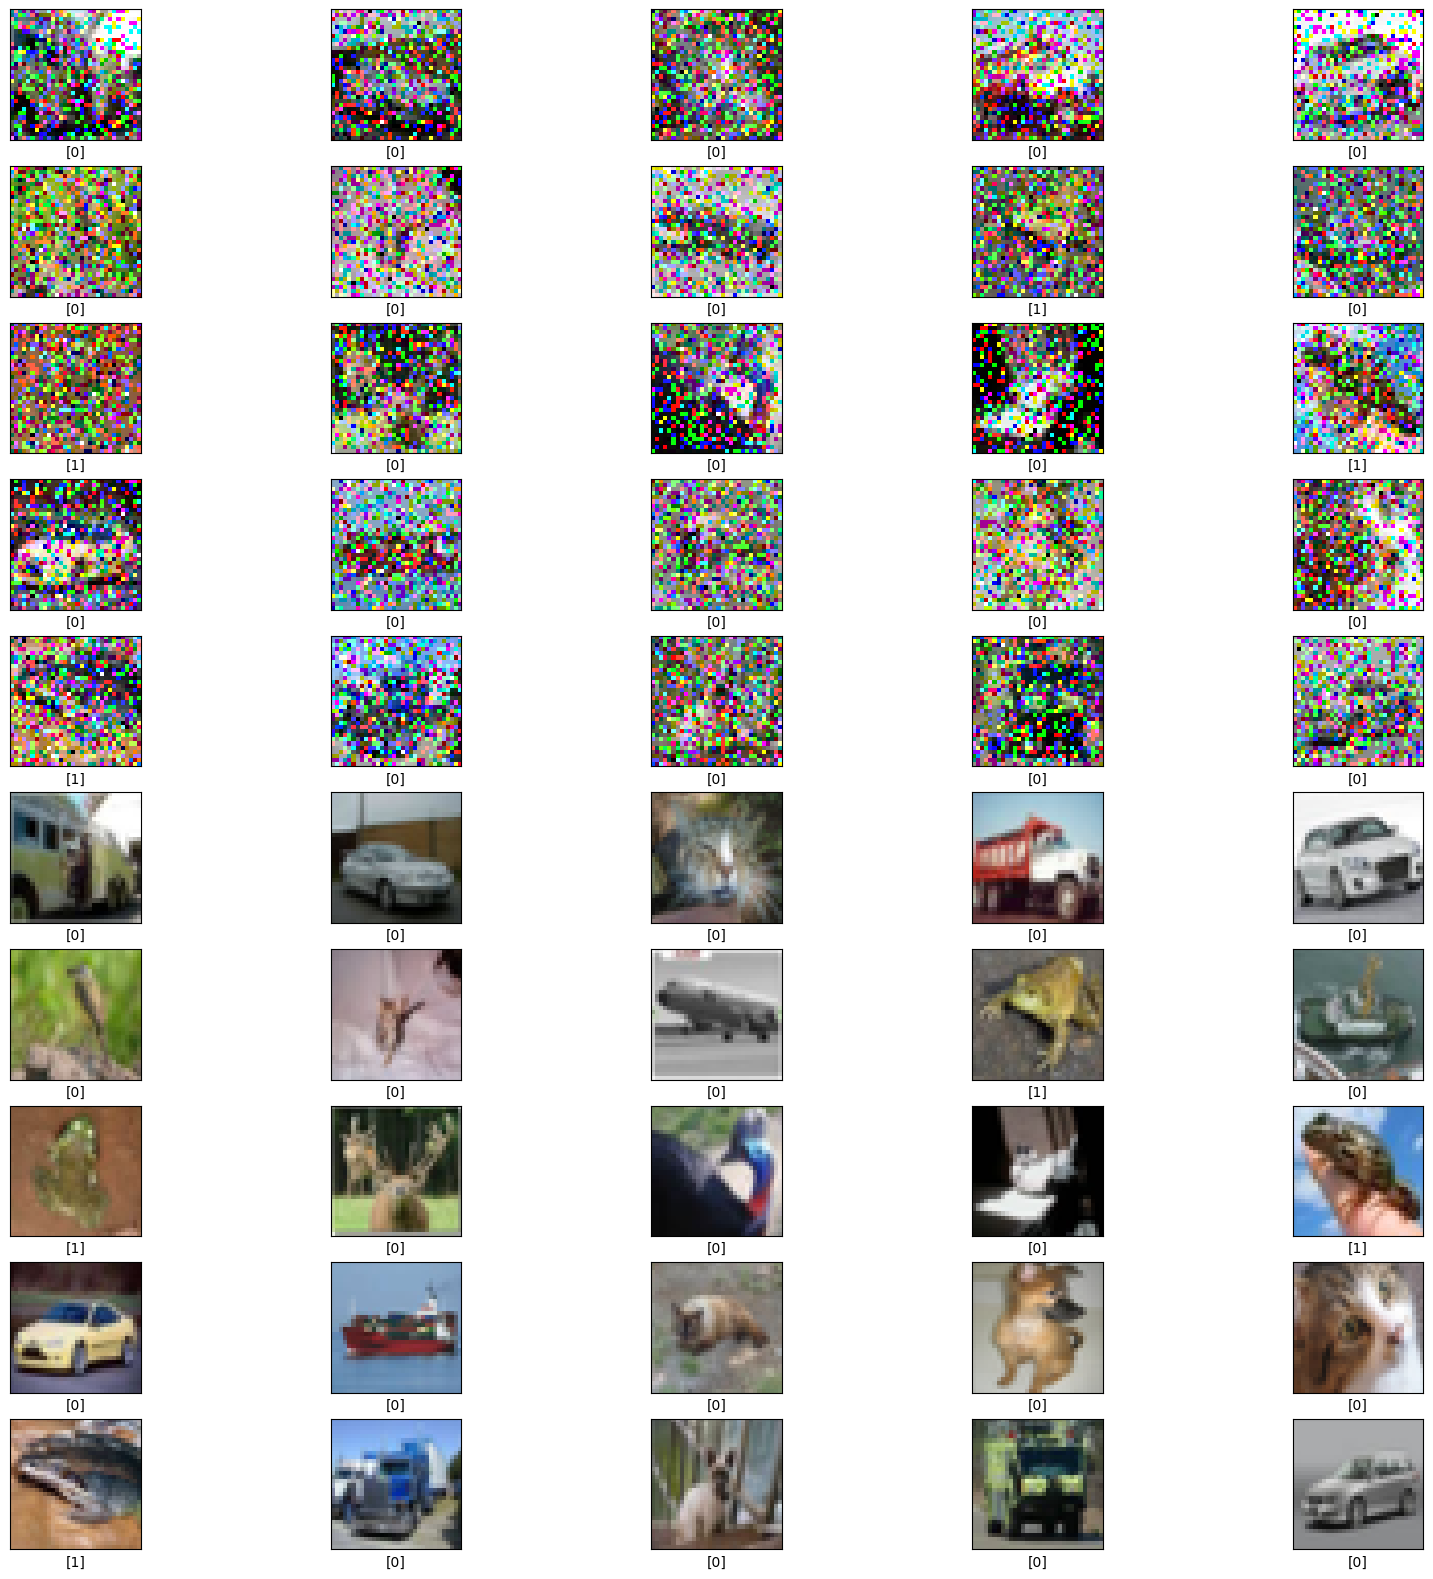

In [79]:
if True:
    class_names = ['not_frog', 'frog']

    randomly_chosen_indexes = np.random.uniform(0, len(corrupted_test_images), 25).astype(int)
    plt.figure(figsize=(20,20))
    for i, value in enumerate(randomly_chosen_indexes):
        plt.subplot(10,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(corrupted_test_images[value])
        # plt.imshow(test_images[value])
        plt.xlabel(corrupted_test_labels[value])


        plt.subplot(10,5,i + 25 +1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[value])
        # plt.imshow(test_images[value])
        plt.xlabel(test_labels[value])
    plt.show()

In [80]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



history_list = {}

history_dict_base = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

history_dict = {}


for i in range(config['ensembleSize']): 
    history_dict[i] = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
    }

    history_list[i] = []

print(history_dict)



{0: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}}


In [81]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model

# Function to set dropout rate
def set_dropout_rate(model, new_rate):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.rate = new_rate


def create_flat_dropout_model(dropout_rate=0.2, return_intermediate=False):
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu')(x)
    # Output layer
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(2, activation='linear')(x)

    intermediate_output = x


    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    if return_intermediate:
        model = Model(inputs=inputs, outputs=[outputs, intermediate_output])

    return model


def create_dropout_model(dropout_rate=0.5, return_intermediate=False):
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    # Output layer
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    intermediate_output = x


    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    if return_intermediate:
        model = Model(inputs=inputs, outputs=[outputs, intermediate_output])

    return model
 

In [82]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
# import VGG16
from tensorflow.keras.applications import VGG16



def create_pretrained_model(input_shape=(32, 32, 3), num_classes=1, return_intermediate=False):
    # Load the ResNet50 model pre-trained on ImageNet, excluding the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    intermediate_output = x
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers (optional)
    for layer in base_model.layers:
        layer.trainable = True

    if return_intermediate:
        model = Model(inputs=base_model.input, outputs=[predictions, intermediate_output])

    # Compile the model
    return model

# describe model
if config['currentModel'] == 'pretrained':
    model = create_pretrained_model()
    model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [83]:
 
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model

def create_model(return_intermediate=False):
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dense(64, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    intermediate_output = x  # Saving the intermediate output

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    if return_intermediate:
        # Return a model that will output intermediate results alongside the main output
        model = Model(inputs=inputs, outputs=[outputs, intermediate_output])

    return model

### Training loop

In [84]:

# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.datasets import cifar10
# import numpy as np



# # Load CIFAR-10 data
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # Create binary labels for "frog" (class 6) vs. "no frog" (all other classes)
# y_train_binary = np.where(y_train == 6, 1, 0)
# y_test_binary = np.where(y_test == 6, 1, 0)

# # Normalize images
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# # Define the image data generator for augmentation
# datagen = ImageDataGenerator(
#     # rotation_range=20,
#     # width_shift_range=0.2,
#     # height_shift_range=0.2,
#     # horizontal_flip=True
# )

# datagen.fit(x_train)



# # Create the full model
# model = create_pretrained_model()

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# randomly_chosen_indexes = np.random.uniform(0, len(train_images), 25).astype(int)
# plt.figure(figsize=(20,20))
# for i, value in enumerate(randomly_chosen_indexes):
#     plt.subplot(10,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train[value])
#     # plt.imshow(test_images[value])
#     plt.xlabel(y_train_binary[value])

# plt.show()


# # Train the model
# history = model.fit(
#     datagen.flow(x_train, y_train_binary, batch_size=32),
#     steps_per_epoch=len(x_train) // 32,
#     epochs=10,
#     validation_data=(x_test, y_test_binary)
# )


# # Evaluate the model
# loss, accuracy = model.evaluate(x_test, y_test_binary, verbose=0)
# print(f'Test accuracy: {accuracy * 100:.2f}%')


In [85]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.utils import resample

if config['training']:
    for i in range(config['ensembleSize']):
        print(i)

        early_stopping = EarlyStopping(monitor='val_auc', patience=config['patience'], restore_best_weights=True, mode='max')
        log_dir = f"{MODEL_FILE}/tenserboard/{i}"
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
        model_checkpoint = ModelCheckpoint(f'{MODEL_FILE}/{i}.keras', monitor='val_auc', save_best_only=True, mode='max')

        callbacks = [early_stopping, tensorboard_callback]

        if config['saveModel']:
            callbacks.append(model_checkpoint)

        if config['currentModel'] == 'pretrained':
            model = create_pretrained_model()
        elif config['currentModel'] == 'BNN':
            model = create_dropout_model()
        elif config['currentModel'] == 'ENSEMBLE':
            model = create_model()

        if config['currentModel'] != 'pretrained':
            model.compile(optimizer='adam',
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve='ROC')])
        else:
            model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve='ROC')])

        if config['currentModel'] == 'BNN':
            set_dropout_rate(model, np.nextafter(np.float32(0), np.float32(1)))

        X_train_subset, y_train_subset = resample(train_images, train_labels)

        history = model.fit(datagen.flow(X_train_subset, y_train_subset, batch_size=32), epochs=config['epochs'],
                            validation_data=(val_images, val_labels),
                            callbacks=callbacks, batch_size=32, steps_per_epoch=len(X_train_subset) // 32)

        if config['currentModel'] == 'BNN':
            set_dropout_rate(model, 0.5)

        history_list[i].append(history)

        for history in history_list[i]:
            for key in history_dict_base.keys():
                history_dict[i][key].extend(history.history[key])


In [86]:
if config['currentModel'] == 'BNN':
    import numpy as np
    from tensorflow.keras.models import load_model

    class MCDropoutModel():
        def __init__(self, base_model, num_predictions=100, dropout_rate=config['dropout_rate']):
            self.base_model = base_model
            self.num_predictions = num_predictions
            self.dropout_rate = dropout_rate
            self.model_with_intermediates = create_dropout_model(return_intermediate=True)
            self.model_with_intermediates.set_weights(self.base_model.get_weights())

        def verbose_predict(self, inputs):
            outputs = []
            set_dropout_rate(self.base_model, self.dropout_rate)
            for _ in range(self.num_predictions):
                # Enable dropout during prediction
                outputs.append(self.base_model(inputs, training=True))

            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack
        
        def verbose_predict_with_intermediate(self, inputs):

            intermediate_outputs = []
            outputs = []
            set_dropout_rate(self.base_model, self.dropout_rate)
            for _ in range(self.num_predictions):
                # Enable dropout during prediction
                y, intermediate_output = self.model_with_intermediates(inputs, training=True)
                outputs.append(y)
                intermediate_outputs.append(intermediate_output)

            outputs_stack = tf.stack(outputs, axis=0)
            intermediate_outputs_stack = tf.stack(intermediate_outputs, axis=0)

            return outputs_stack, intermediate_outputs_stack
        
        

    loaded_model = load_model(f'{MODEL_FILE}/0.keras')

    # Wrap the base model with the MCDropoutModel
    model_under_test = MCDropoutModel(loaded_model, num_predictions=20)


In [87]:

if config['currentModel'] == 'pretrained':
    import numpy as np
    from tensorflow.keras.models import load_model

    class Pretrained_MCDropoutModel():
        def __init__(self, base_model, num_predictions=2, dropout_rate=config['dropout_rate']):
            self.base_model = base_model
            self.num_predictions = num_predictions
            self.dropout_rate = dropout_rate
            self.model_with_intermediates = create_pretrained_model(return_intermediate=True)
            self.model_with_intermediates.set_weights(self.base_model.get_weights())

        def verbose_predict(self, inputs):
            outputs = []
            set_dropout_rate(self.base_model, self.dropout_rate)
            for i in range(self.num_predictions):
                print(i)
                # Enable dropout during prediction
                outputs.append(self.base_model(inputs, training=True))

            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack
        
        def verbose_predict_with_intermediate(self, inputs):

            intermediate_outputs = []
            outputs = []
            set_dropout_rate(self.base_model, self.dropout_rate)
            for _ in range(self.num_predictions):
                # Enable dropout during prediction
                y, intermediate_output = self.model_with_intermediates(inputs, training=True)
                outputs.append(y)
                intermediate_outputs.append(intermediate_output)

            outputs_stack = tf.stack(outputs, axis=0)
            intermediate_outputs_stack = tf.stack(intermediate_outputs, axis=0)

            return outputs_stack, intermediate_outputs_stack
        
        

    loaded_model = load_model(f'{MODEL_FILE}/0.keras')

    # Wrap the base model with the MCDropoutModel
    model_under_test = Pretrained_MCDropoutModel(loaded_model, num_predictions=2)


In [88]:
if config['currentModel'] == 'ENSEMBLE':
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Average
    from tensorflow.keras.models import load_model


    class EnsembleModel:
        def __init__(self, models, **kwargs):
            super(EnsembleModel, self).__init__(**kwargs)
            self.models = models

        def verbose_predict(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack


    model_list = []

    for i in range(config['ensembleSize']): 
        ensemble_member = load_model(f'{MODEL_FILE}/{i}.keras')
        ensemble_member.evaluate(test_images, test_labels)
        model_list.append(ensemble_member)


    # Create the ensemble model
    model_under_test = EnsembleModel(model_list)

    

### Getting output stack

In [89]:
import pandas as pd
import tensorflow as tf
import numpy as np


# def get_average_variance_across_features(a):
#     # Convert to double precision for increased numerical stability
#     a = np.array(a, dtype=np.float64)
    
#     # Compute variance along the predictions axis (axis=0) directly using np.var
#     variance_per_sample_and_feature = np.var(a, axis=0, ddof=0)
    
#     # Average across samples (axis=0) to get the average variance per feature
#     average_variance_per_feature = np.mean(variance_per_sample_and_feature, axis=0)
    
#     return average_variance_per_feature

def get_output_stack(model, images, intermediate=True):

   if config['currentModel'] == 'ENSEMBLE' or not intermediate:
        y = model.verbose_predict(images)
        return y, None
   else:
      y, intermediate_output = model.verbose_predict_with_intermediate(images)
      return y, intermediate_output

print('1')
os_test, is_test = get_output_stack(model_under_test, test_images)

print('2')
os_val, is_val = get_output_stack(model_under_test, val_images)

print('3')
os_train, is_train = get_output_stack(model_under_test, train_images)

print('4')
#os_held_out, is_held_out = get_output_stack(model_under_test, test_images_held_out)
os_held_out, is_held_out = None, None

print('5')
os_corrupted, is_corrupted = get_output_stack(model_under_test, corrupted_test_images)

print('6')
os_val_corrupted, is_val_corrupted = get_output_stack(model_under_test, corrupted_val_images)


# if pickle file does not exist


1
2
3
4
5
6


### Loading output stack

In [90]:

if not os.path.exists(f'{MODEL_FILE}/os_is_dict.pkl'):

   os_is_dict = {
      'is_test': os_test,
      'is_test': is_test,
      'is_val': os_val,
      'is_val': is_val,
      'is_train': os_train,
      'is_train': is_train,
      'is_held_out': os_held_out,
      'is_held_out': is_held_out,
      'is_corrupted': os_corrupted,
      'is_corrupted': is_corrupted,
      'is_val_corrupted': os_val_corrupted,
      'is_val_corrupted': is_val_corrupted
   }

   import pickle

   with open(f'{MODEL_FILE}/os_is_dict.pkl', 'wb') as f:
      pickle.dump(is_test, f)


In [91]:

def get_average_variance_across_features(a):

    # number of predictions, number of test samples, number of features
    # if a is eager tensor we need to convert it to numpy array
    # b = np.mean(a, axis=0)
    # c = a - b
    # d = np.mean(c**2, axis=0)
    # e = np.mean(d, axis=1)
    # print(e)
    # return e

    # Euclidean distance version


    b = np.mean(a, axis=0)
    c = a - b
    d = np.mean(np.abs(c), axis=0)
    e = np.mean(d, axis=1)
    # print(e)
    return e

In [92]:

def logit(p):
    return np.log(p / (1 - p))

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))
    

# Example usage:


def produce_df_from_predictions(test_labels, outputs_stack, intermediate_stack, reduce_to_ensemble_members=None):
    if outputs_stack != None:
        if reduce_to_ensemble_members != None:
            outputs_stack = outputs_stack[reduce_to_ensemble_members]
            intermediate_stack = intermediate_stack[reduce_to_ensemble_members]
            outputs_mean = outputs_stack
        else:
            outputs_mean = np.mean(outputs_stack, axis=0)
    
        ensemble_predictions = np.where(outputs_mean > 0.5, 1, 0)
        individual_outputs = np.array(outputs_stack).squeeze().T.tolist()
        output_confidence = np.abs(outputs_mean - 0.5)
        prediction_outcome = np.where(ensemble_predictions != test_labels, 0, 1)
        output_logits = logit(outputs_stack)
        # turn to sigmoid
        output_logits = sigmoid(output_logits)
    
        if reduce_to_ensemble_members == None:
            outputs_variance = np.var(output_logits, axis=0)
            if config['currentModel'] == 'BNN' and False:
                sd = get_average_variance_across_features(intermediate_stack).reshape(-1, 1)
                outputs_variance = sd
    
        # test if outputs variance is not defined
        if 'outputs_variance' not in locals():
            outputs_variance = np.zeros_like(output_confidence)
        # make sure all the arrays are the n x 1 shape
        np_df = np.hstack((output_confidence, outputs_variance, prediction_outcome, outputs_mean, test_labels, ensemble_predictions))
        df = pd.DataFrame(np_df, columns=['confidence', 'variance', 'outcome', 'mean', 'label', 'prediction'])
        df['individual_predictions'] = individual_outputs
        df['tp'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 1), axis=1)
        df['fp'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 1), axis=1)
        df['tn'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 0), axis=1)
        df['fn'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 0), axis=1)
    
        return df

df_test = produce_df_from_predictions(test_labels, os_test, is_test)

df_val = produce_df_from_predictions(val_labels, os_val, is_val)

df_train = produce_df_from_predictions( train_labels, os_train, is_train)

df_held_out = produce_df_from_predictions(test_labels_held_out, os_held_out, is_held_out)

df_corrupted = produce_df_from_predictions(corrupted_test_labels, os_corrupted, is_corrupted)

df_val_corrupted = produce_df_from_predictions(corrupted_val_labels, os_val_corrupted, is_val_corrupted)

plt.show()


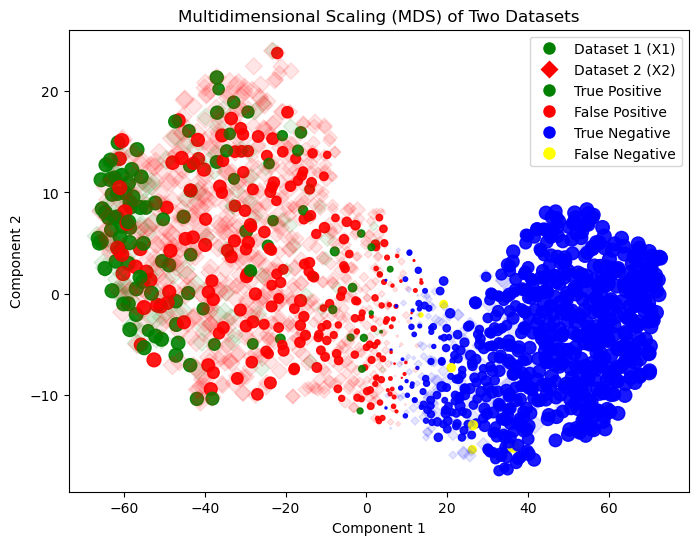

<Figure size 640x480 with 0 Axes>

In [93]:
if config['currentModel'] == 'pretrained':
    is_test_averaged = np.mean(is_test, axis=0)
    is_corrupted_averaged = np.mean(is_corrupted, axis=0)

    from sklearn.manifold import MDS, TSNE
    from sklearn.decomposition import PCA

    # Combine both datasets

    import matplotlib.lines as mlines
    def show_cluster_plot(X1, X2, df_test, df_corrupted, highlight_samples=None):
        def return_color(x):
            if x['tp']: 
                return 'green'
            if x['fp']:
                return 'red'
            if x['tn']:
                return 'blue'
            if x['fn']:
                return 'yellow'


        combined_data = np.vstack([X1, X2])

        # Apply MDS to the combined dataset
        # mds = MDS(n_components=2, random_state=0)
        # combined_clustering = mds.fit_transform(combined_data)

        # try tsne
        tsne = TSNE(n_components=2, random_state=0)
        combined_clustering = tsne.fit_transform(combined_data)

        # combined_clustering = combined_data

        # Separate the transformed data for each dataset
        X1_clustered = combined_clustering[:len(X1), :]
        X2_clustered = combined_clustering[len(X1):, :]

        # Plot both datasets in the same figure
        plt.figure(figsize=(8, 6))

        color_test = df_test[:len(X1)].apply(return_color, axis=1)
        color_corrupted = df_corrupted[:len(X1)].apply(return_color, axis=1)


        plt.scatter(X1_clustered[:, 0], X1_clustered[:, 1], c=color_test, alpha=0.9, label='Dataset 1 (X1)', s=df_test['confidence'][:len(X1)].to_numpy() * 200)
        plt.scatter(X2_clustered[:, 0], X2_clustered[:, 1], c=color_corrupted, alpha=0.1, label='Dataset 2 (X2)', s=df_corrupted['confidence'][:len(X2)].to_numpy() * 200, marker='D')
        if highlight_samples != None:
            for i in highlight_samples:
                plt.scatter(X1_clustered[i['sample'], 0], X1_clustered[i['sample'], 1], c=i['colour'], alpha=1, label=i['name'], s=200, marker='x')



        plt.title('Multidimensional Scaling (MDS) of Two Datasets')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')

        # Create legend elements
        legend_elements = [mlines.Line2D([0], [0], marker='o', color='w', label='Dataset 1 (X1)', markerfacecolor='g', markersize=10),
                        mlines.Line2D([0], [0], marker='D', color='w', label='Dataset 2 (X2)', markerfacecolor='r', markersize=10),
                        mlines.Line2D([0], [0], marker='o', color='w', label='True Positive', markerfacecolor='green', markersize=10),
                        mlines.Line2D([0], [0], marker='o', color='w', label='False Positive', markerfacecolor='red', markersize=10),
                        mlines.Line2D([0], [0], marker='o', color='w', label='True Negative', markerfacecolor='blue', markersize=10),
                        mlines.Line2D([0], [0], marker='o', color='w', label='False Negative', markerfacecolor='yellow', markersize=10)]

        # Add the legend to the plot
        if highlight_samples == None:
            plt.legend(handles=legend_elements, loc='upper right')
        plt.show()

        # ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c='red', alpha=0.6, label='t-SNE')
        # ax[1].set_title('t-Distributed Stochastic Neighbor Embedding (t-SNE)')
        # ax[1].set_xlabel('Component 1')
        # ax[1].set_ylabel('Component 2')
        # ax[1].legend()

        # ax[2].scatter(X_pca[:, 0], X_pca[:, 1], c='green', alpha=0.6, label='PCA')
        # ax[2].set_title('Principal Component Analysis (PCA)')
        # ax[2].set_xlabel('Component 1')
        # ax[2].set_ylabel('Component 2')
        # ax[2].legend()

        plt.tight_layout()
        plt.show()


    X1 = is_test_averaged[:1000]
    X2 = is_corrupted_averaged[:1000]

    # X1 = is_test[0][:1000]
    # X2 = is_corrupted[0][:1000]

    show_cluster_plot(X1, X2, df_test, df_corrupted)


confidence                                                 0.016805
variance                                                        0.0
outcome                                                         1.0
mean                                                       0.483195
label                                                           0.0
prediction                                                      0.0
individual_predictions    [0.48333337903022766, 0.4830569922924042]
tp                                                                0
fp                                                                0
tn                                                                1
fn                                                                0
Name: 0, dtype: object
individual prediction 0.48333337903022766
individual label predicted 0.0


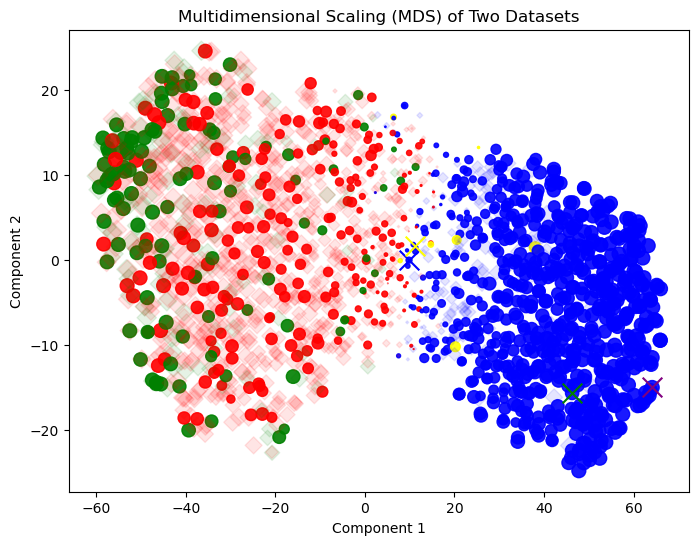

<Figure size 640x480 with 0 Axes>

confidence                                                 0.016805
variance                                                        0.0
outcome                                                         1.0
mean                                                       0.483195
label                                                           0.0
prediction                                                      0.0
individual_predictions    [0.48333337903022766, 0.4830569922924042]
tp                                                                0
fp                                                                0
tn                                                                1
fn                                                                0
Name: 0, dtype: object
individual prediction 0.4830569922924042
individual label predicted 0.0


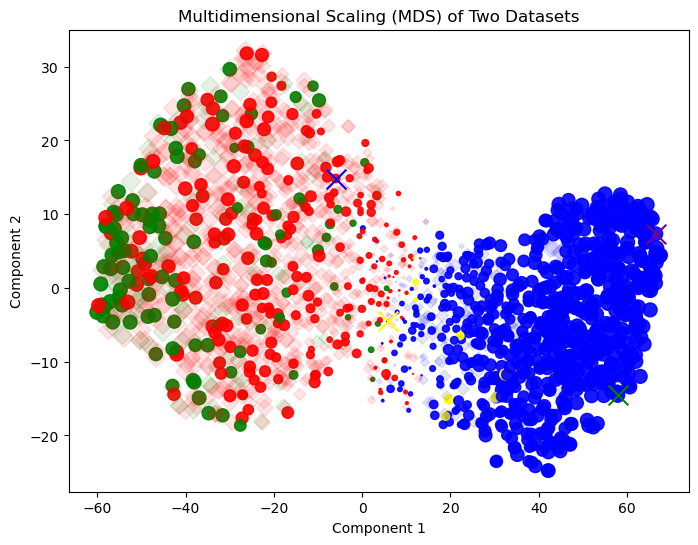

<Figure size 640x480 with 0 Axes>

2024-05-23 15:05:15.082479: W tensorflow/core/framework/op_kernel.cc:1763] OP_REQUIRES failed at strided_slice_op.cc:102 : Invalid argument: slice index 2 of dimension 0 out of bounds.


InvalidArgumentError: slice index 2 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [94]:
if config['currentModel'] == 'pretrained':
    for i in range(10):
        highlight_sample = 0

        # X1_i is the is stack for the ith ensemble member
        X1_i = is_test[i][:1000]
        X2_i = is_corrupted[i][:1000]

        # We use df to get the labels and confidence values

        df_test_for_i = produce_df_from_predictions(test_labels, os_test, is_test, reduce_to_ensemble_members=i)
        df_corrupted_for_i = produce_df_from_predictions(corrupted_test_labels, os_corrupted, is_corrupted, reduce_to_ensemble_members=i)

        # Find the sample with the highest variance

        low_confidence_high_variance = df_test.loc[(df_test.index < 1000) & (df_test['confidence'] < 0.05)].sort_values('variance', ascending=False).index[0]
        high_confidence_high_variance = df_test.loc[(df_test.index < 1000) & (df_test['confidence'] > 0.475)].sort_values('variance', ascending=False).index[0]
        low_confidence_low_variance = df_test.loc[(df_test.index < 1000) & (df_test['confidence'] < 0.05)].sort_values('variance', ascending=True).index[0]
        high_confidence_low_variance = df_test.loc[(df_test.index < 1000) & (df_test['confidence'] > 0.475)].sort_values('variance', ascending=True).index[0]

        highlighted_samples = [
            {'name': 'Low Confidence, High Variance', 'sample': low_confidence_high_variance, 'colour': 'blue'},
            {'name': 'High Confidence, High Variance', 'sample': high_confidence_high_variance, 'colour': 'green'},
            {'name': 'Low Confidence, Low Variance', 'sample': low_confidence_low_variance, 'colour': 'yellow'},
            {'name': 'High Confidence, Low Variance', 'sample': high_confidence_low_variance, 'colour': 'purple'}
        ]

        print(df_test.iloc[low_confidence_low_variance])
        print('individual prediction', df_test.iloc[low_confidence_low_variance]['individual_predictions'][i])
        print('individual label predicted', df_test_for_i.iloc[low_confidence_low_variance]['prediction'])


        show_cluster_plot(X1_i, X2_i, df_test_for_i, df_corrupted_for_i, highlight_samples=highlighted_samples)

### Plotting

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


blue red blue red


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


green orange green orange


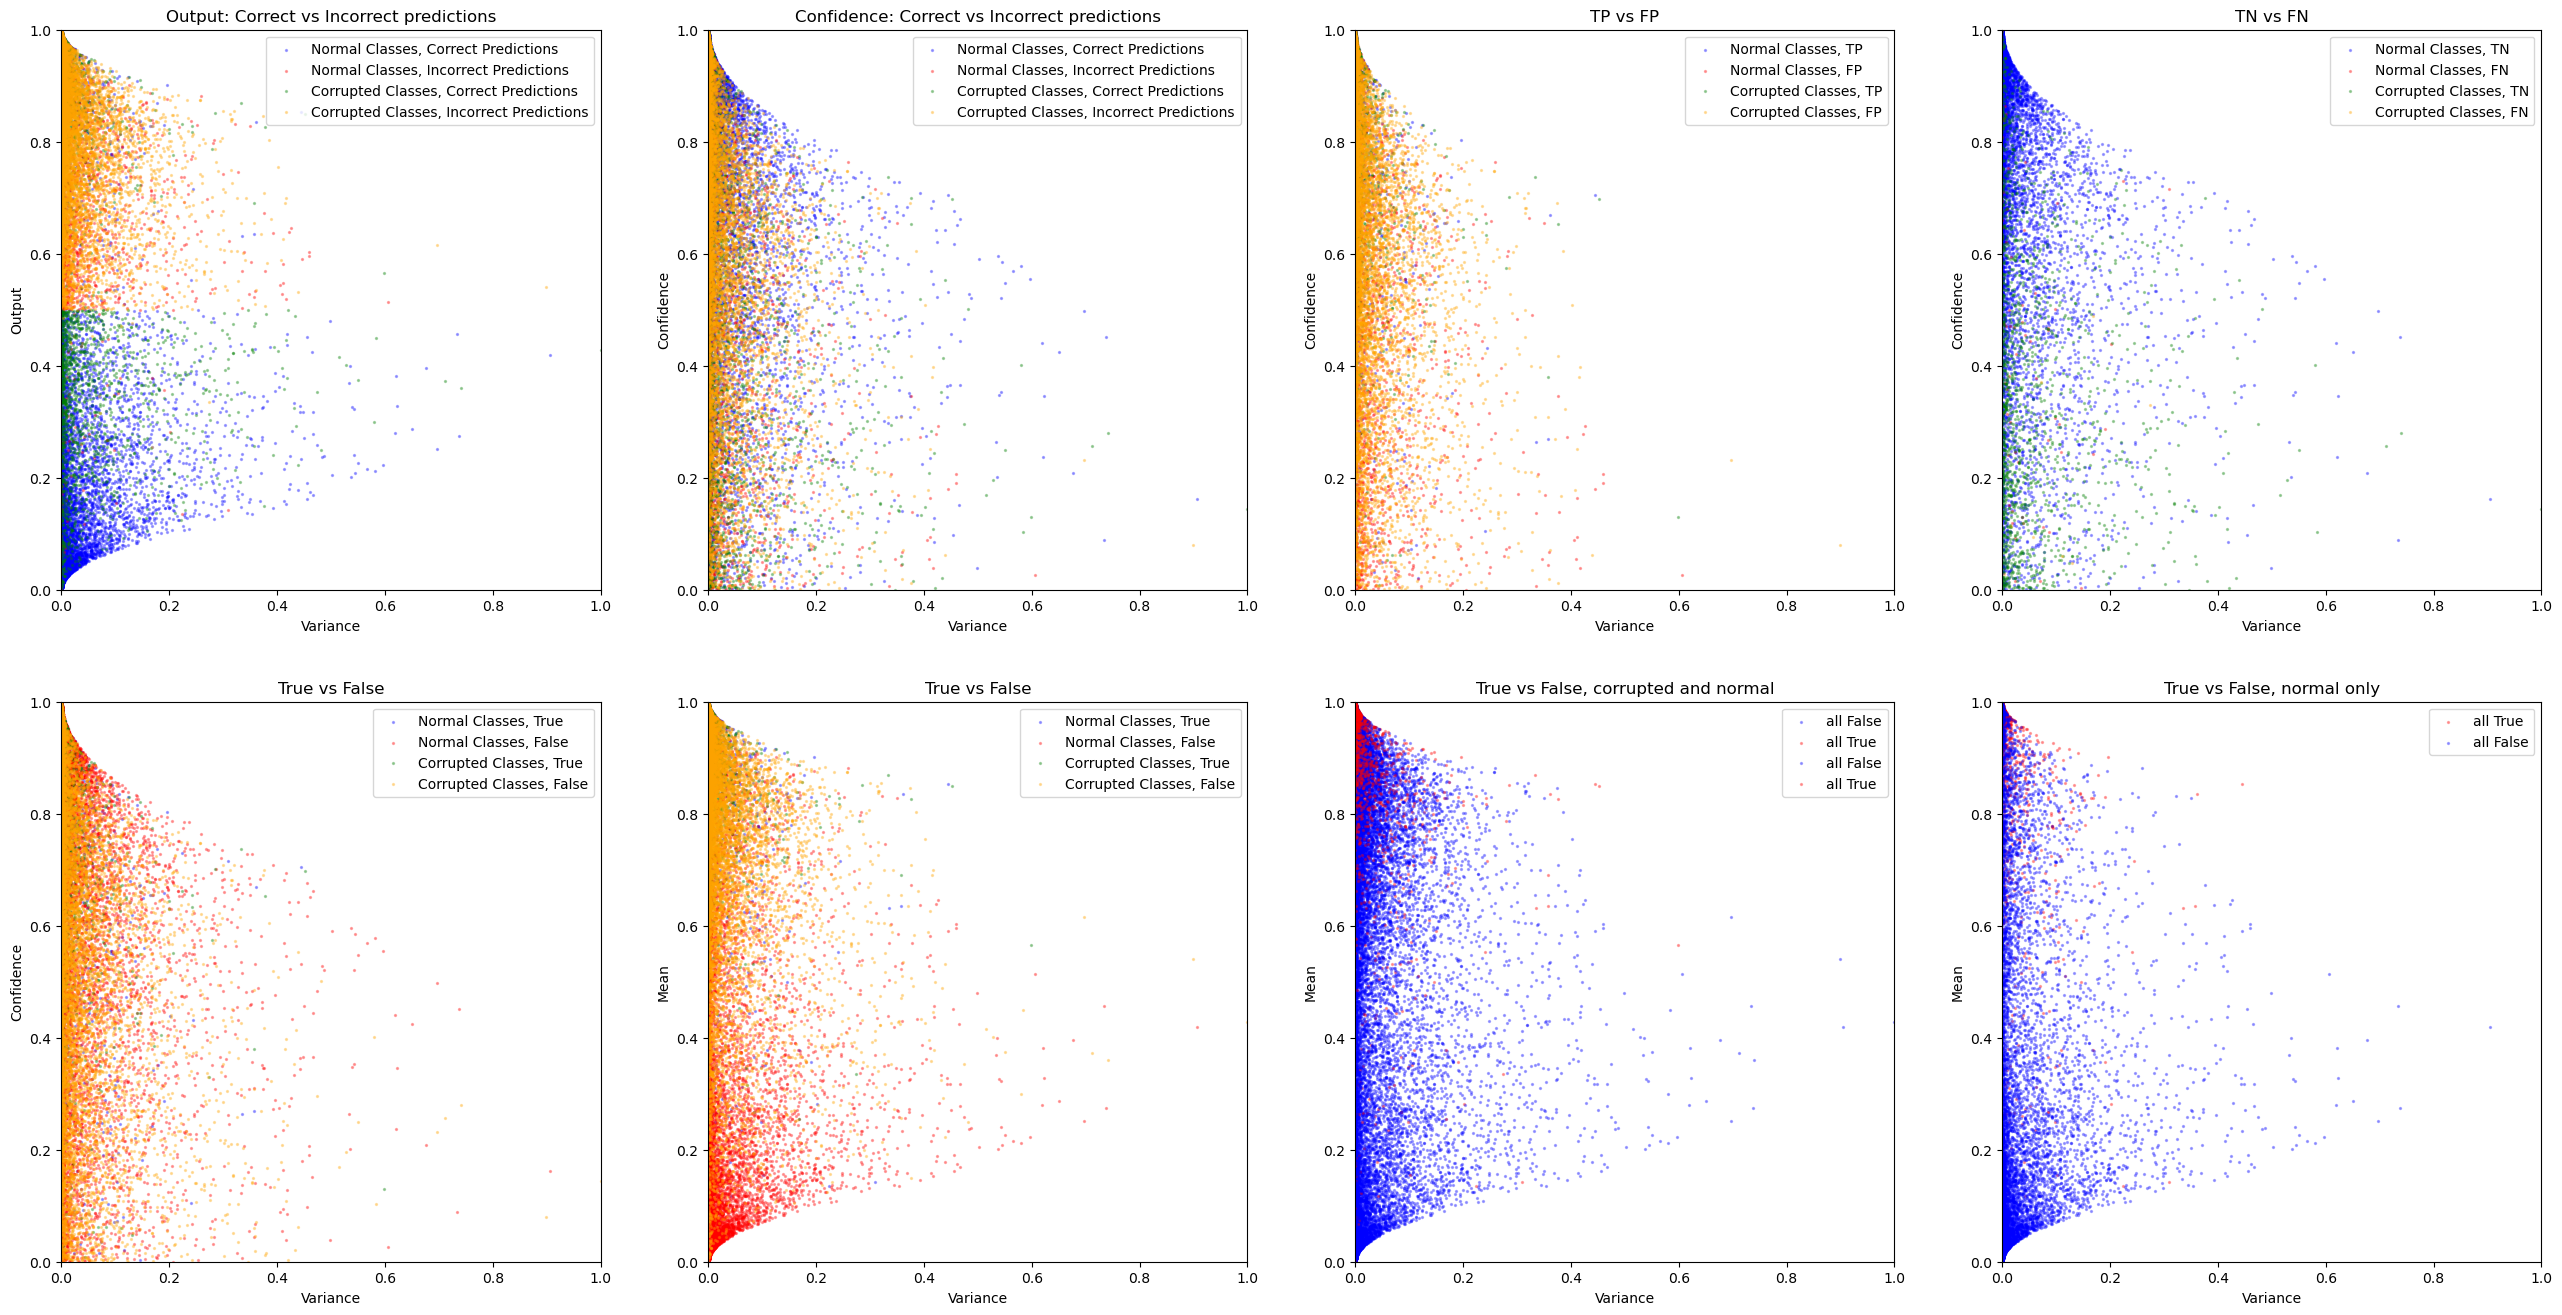

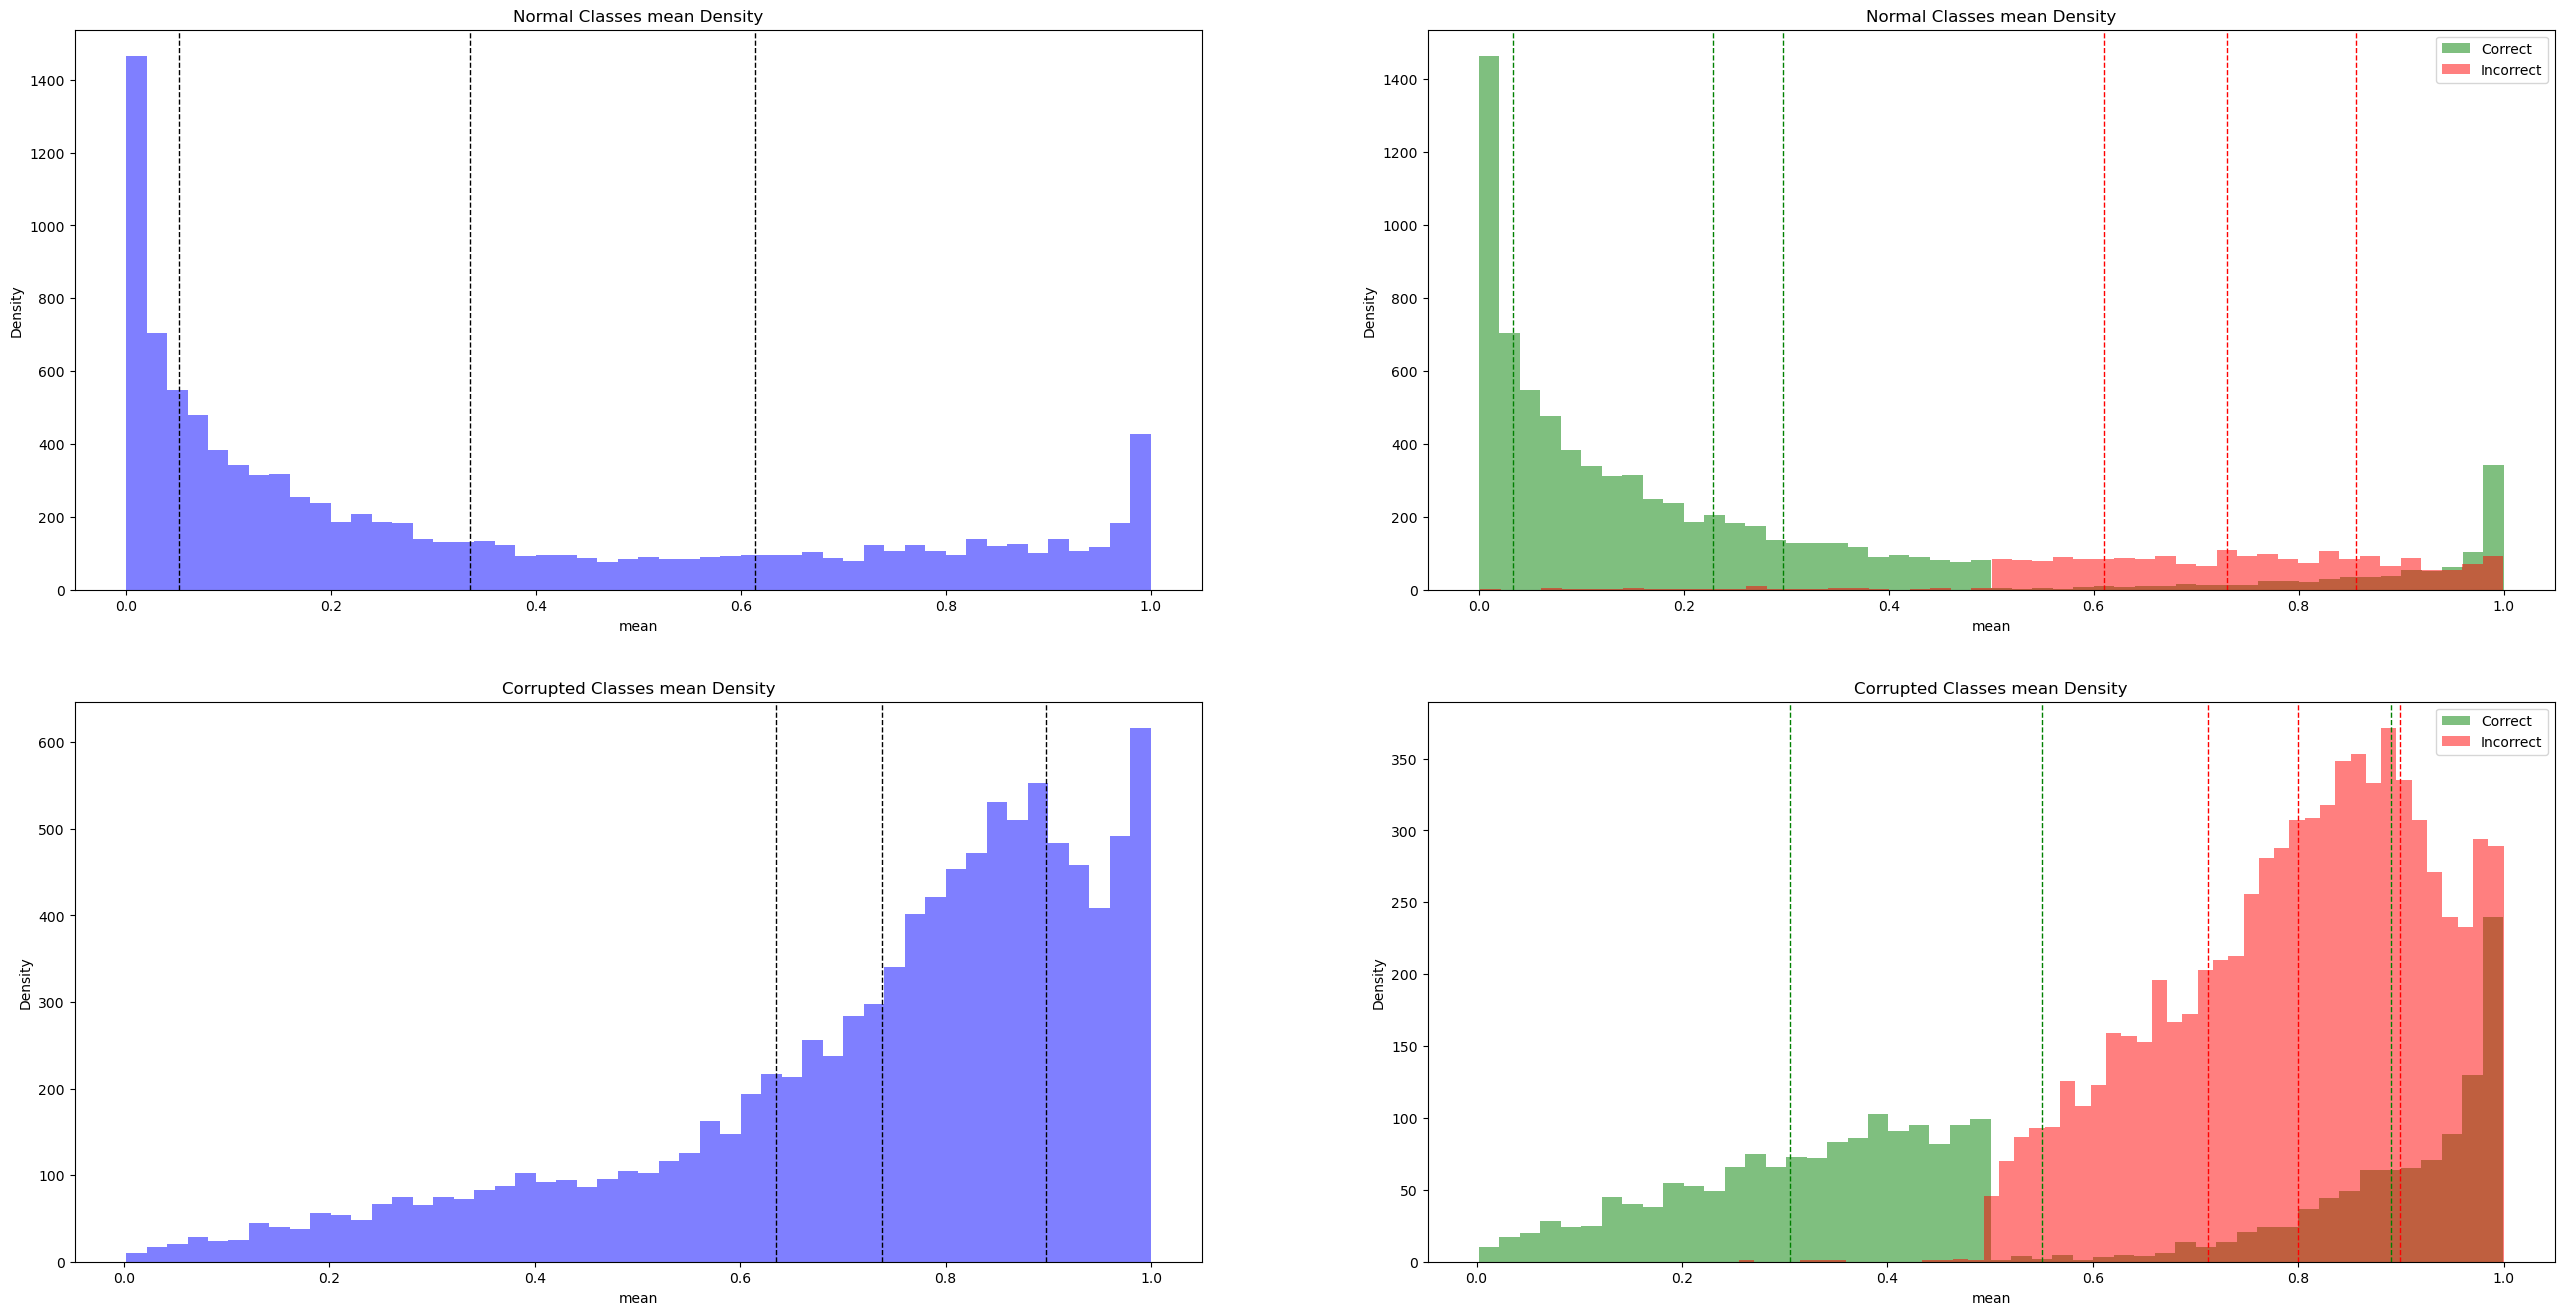

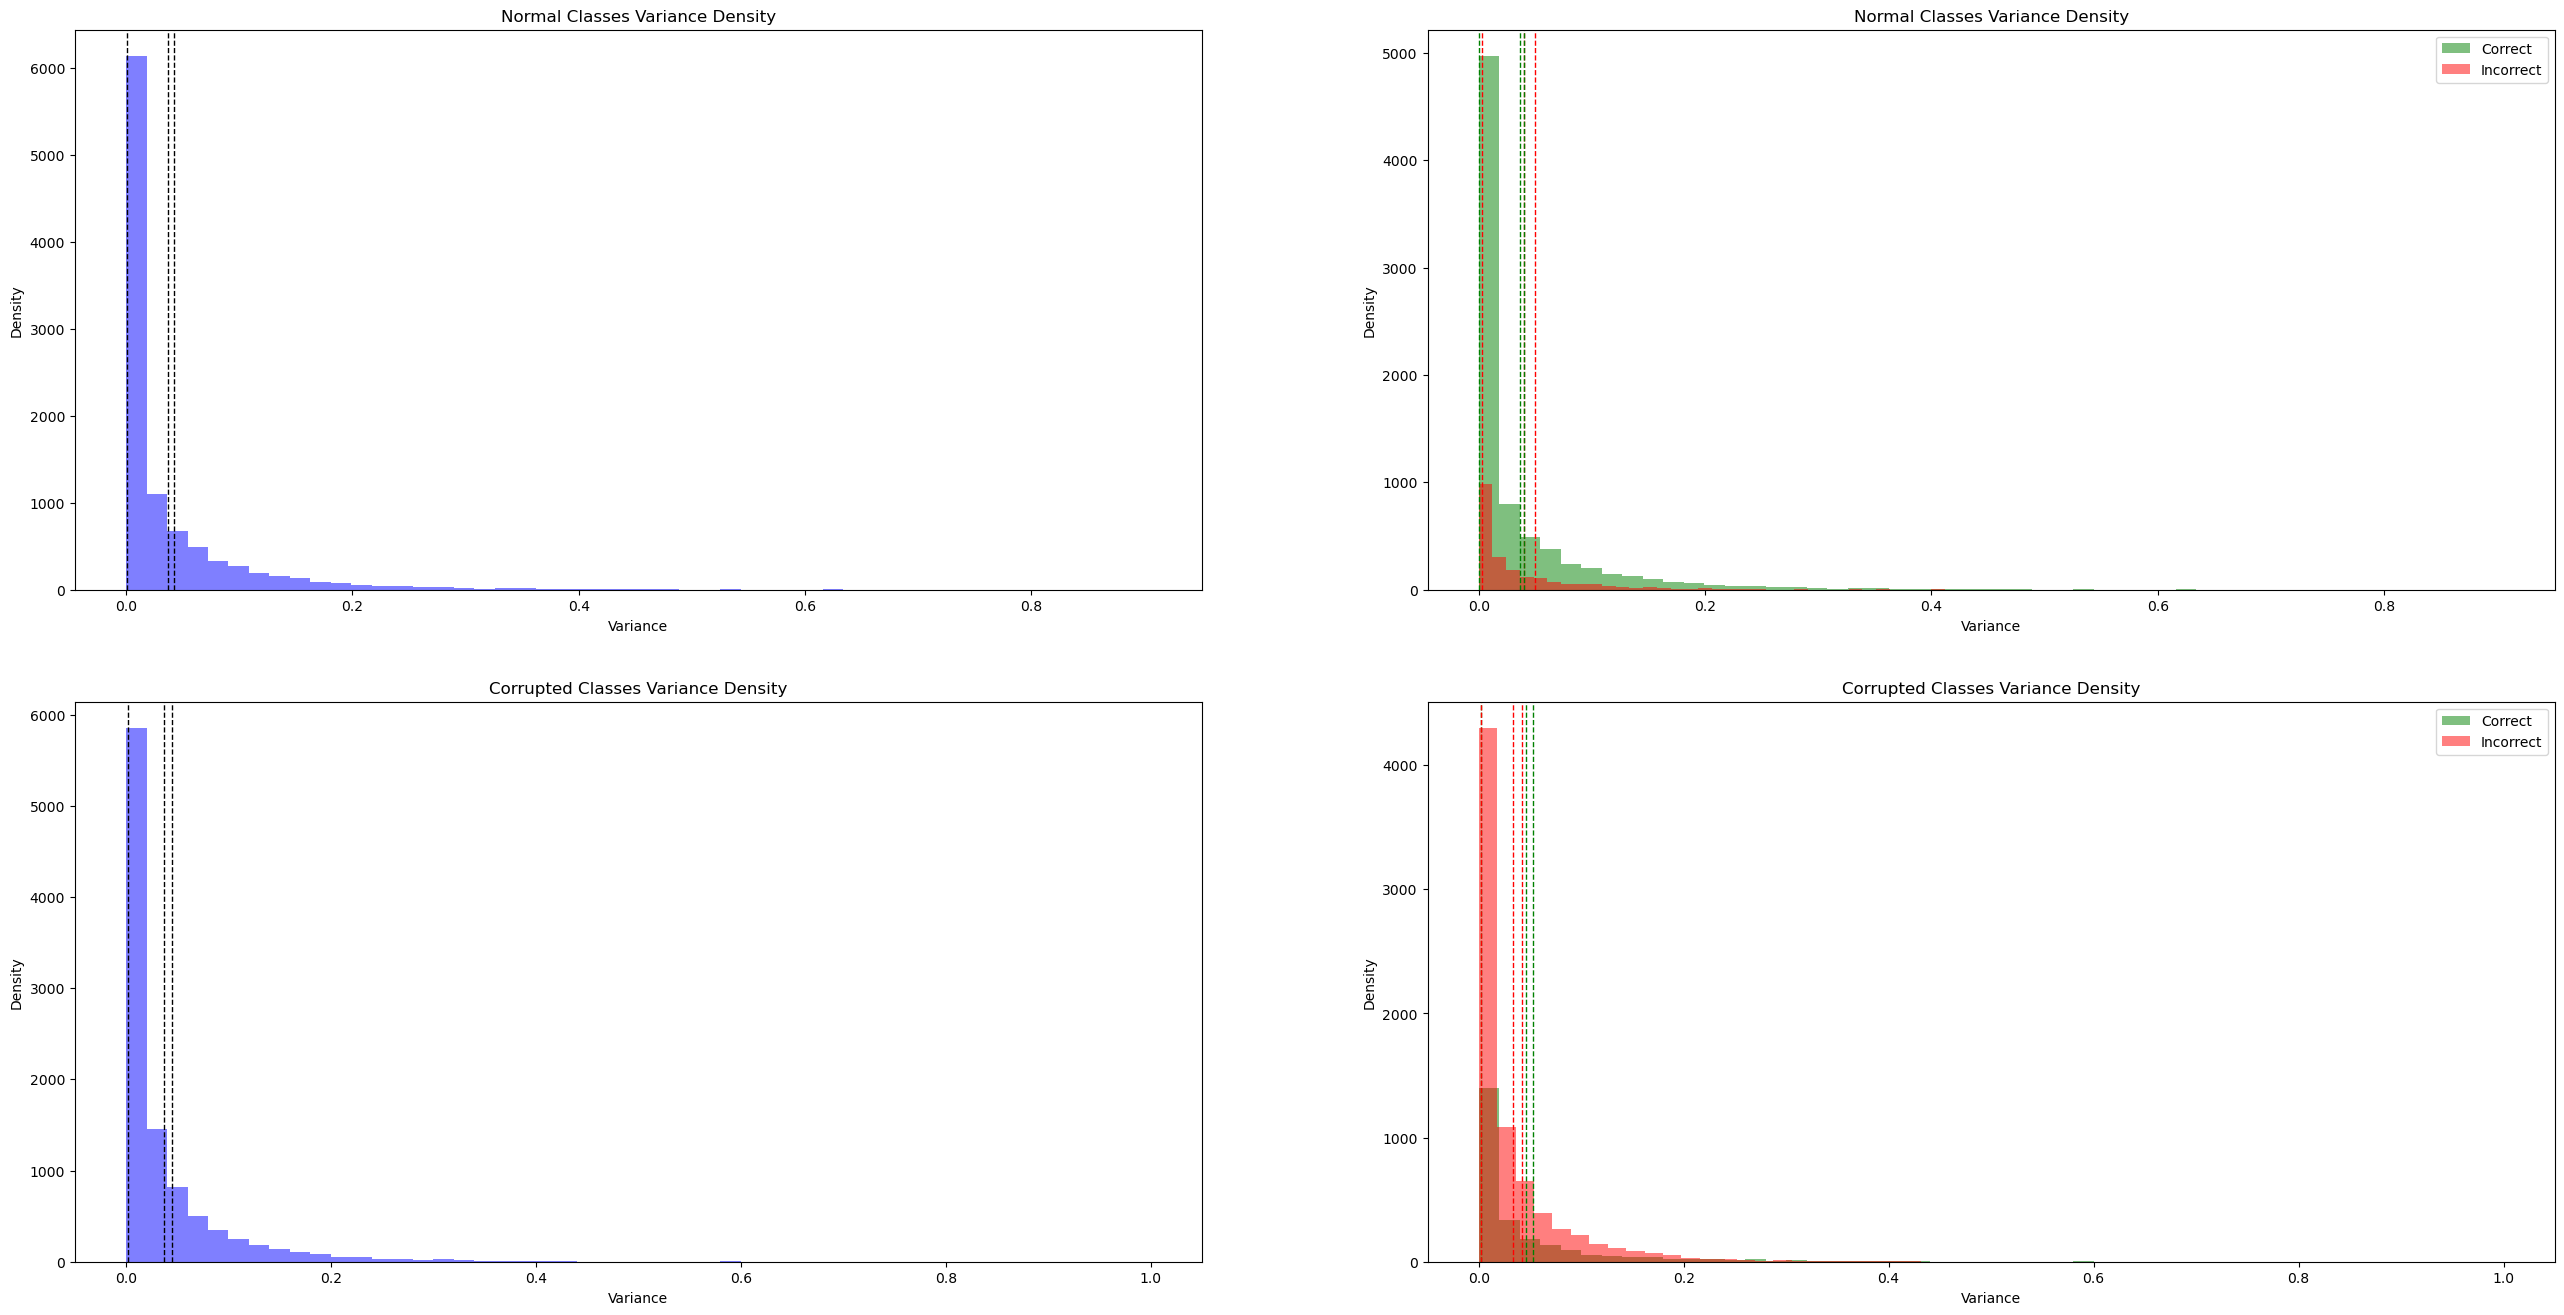

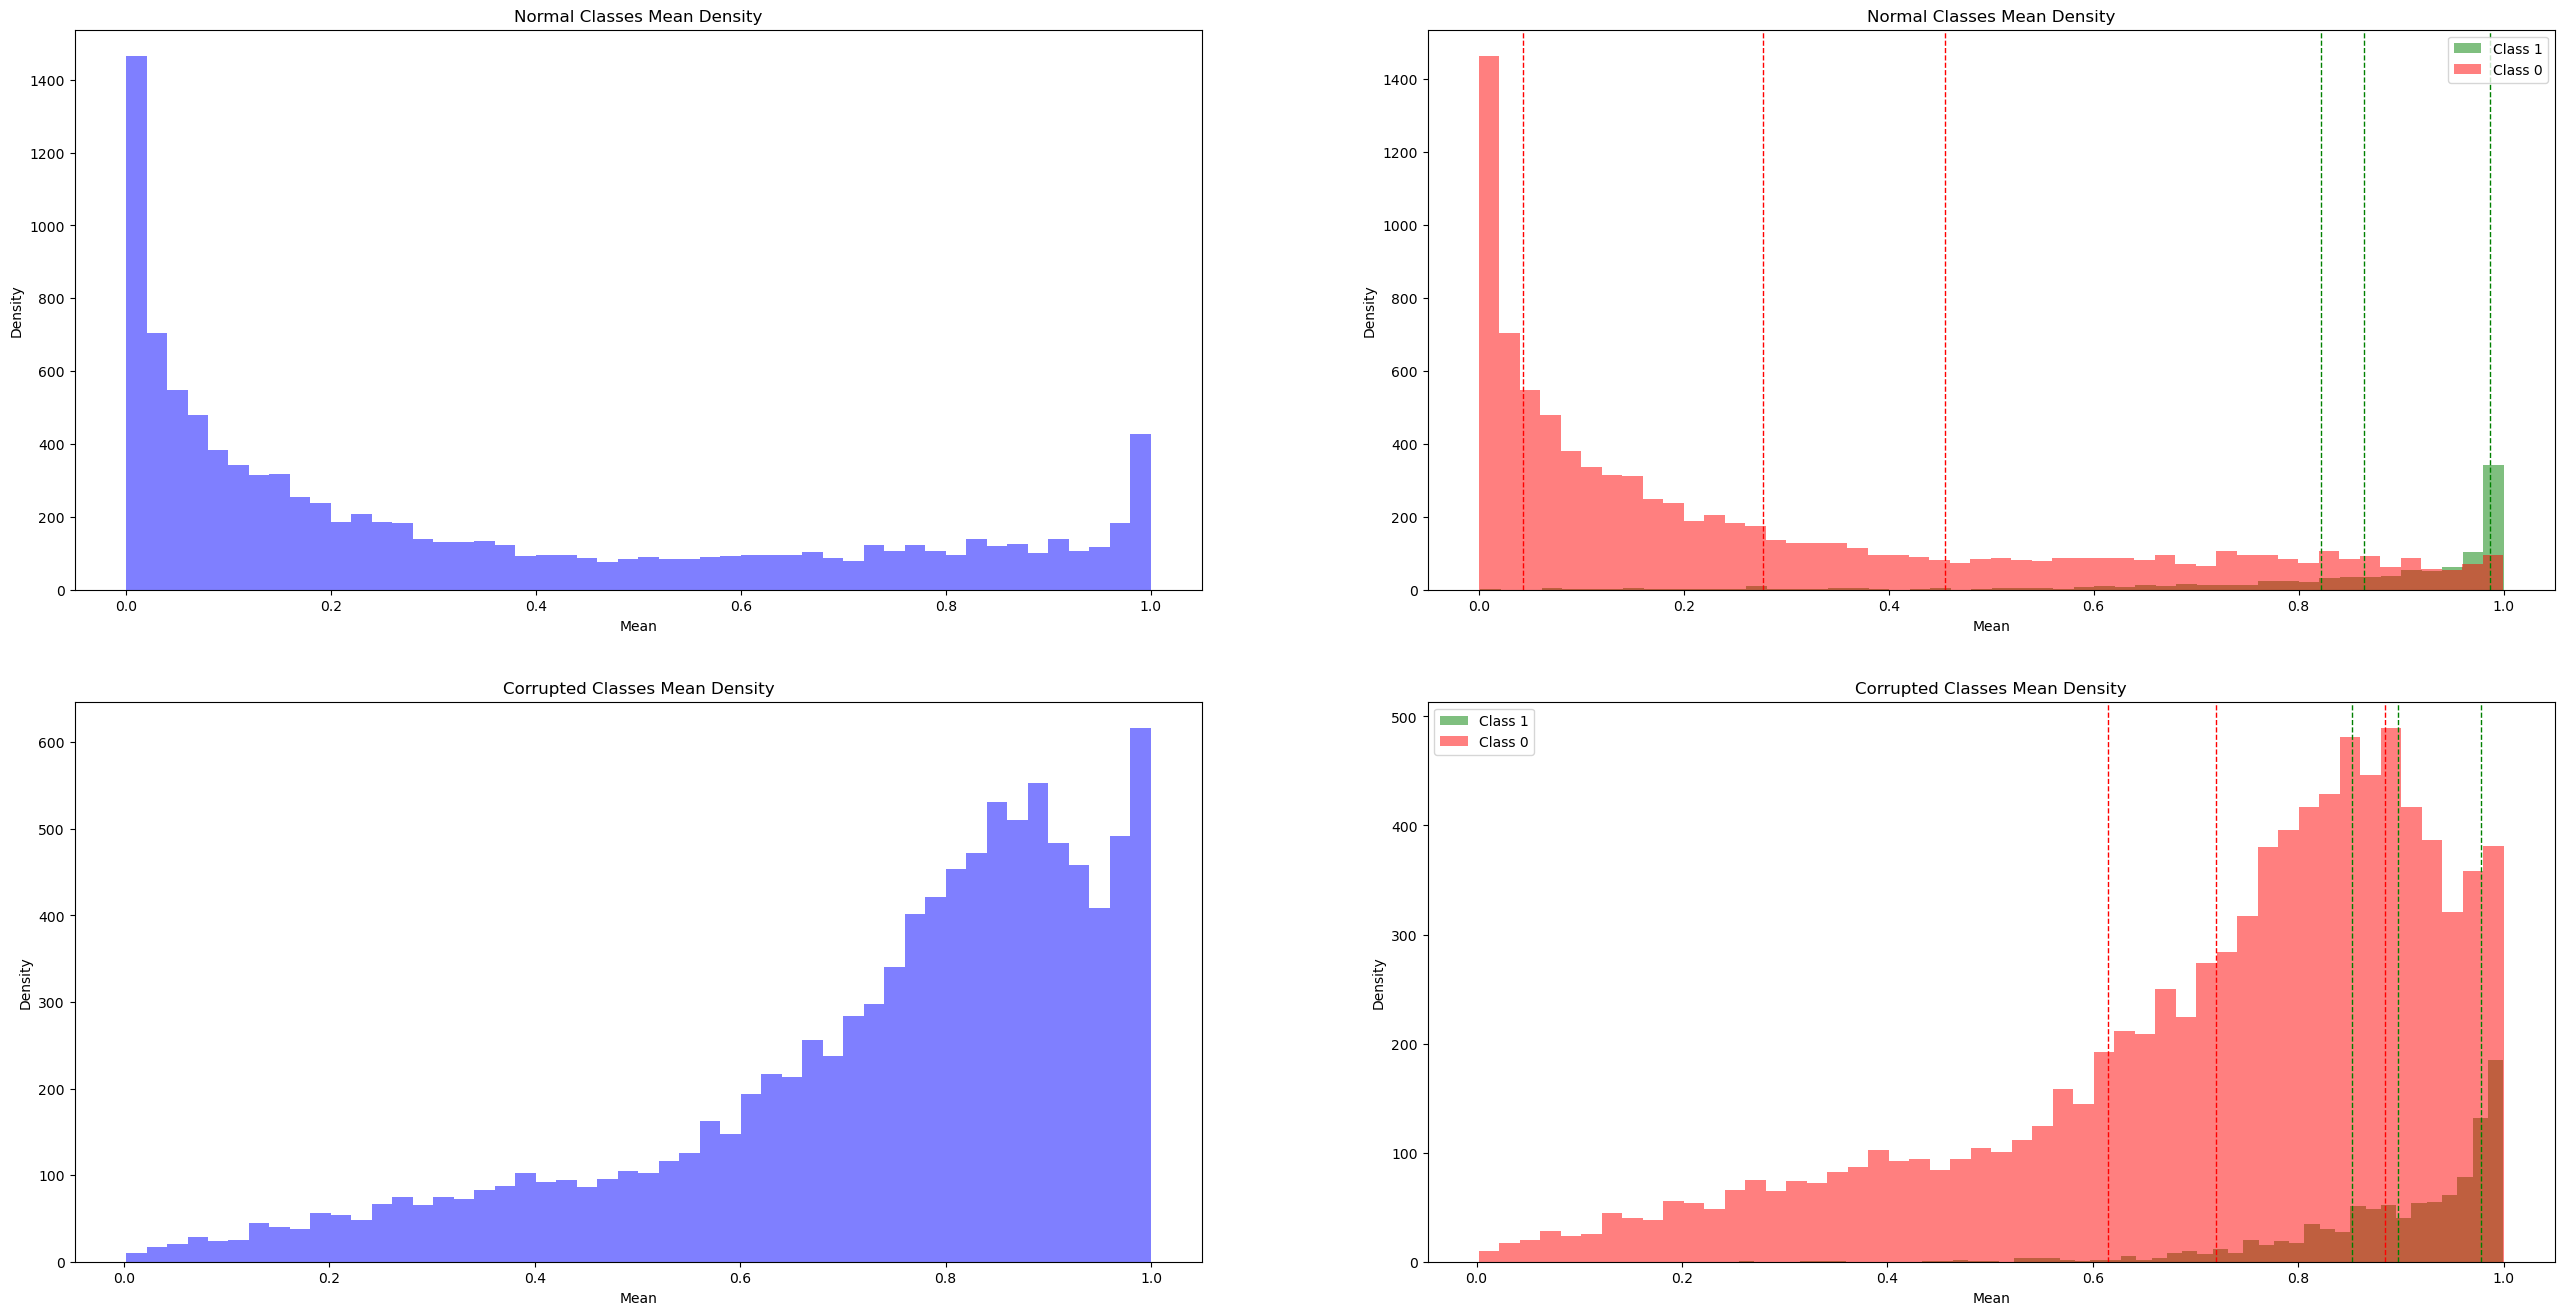

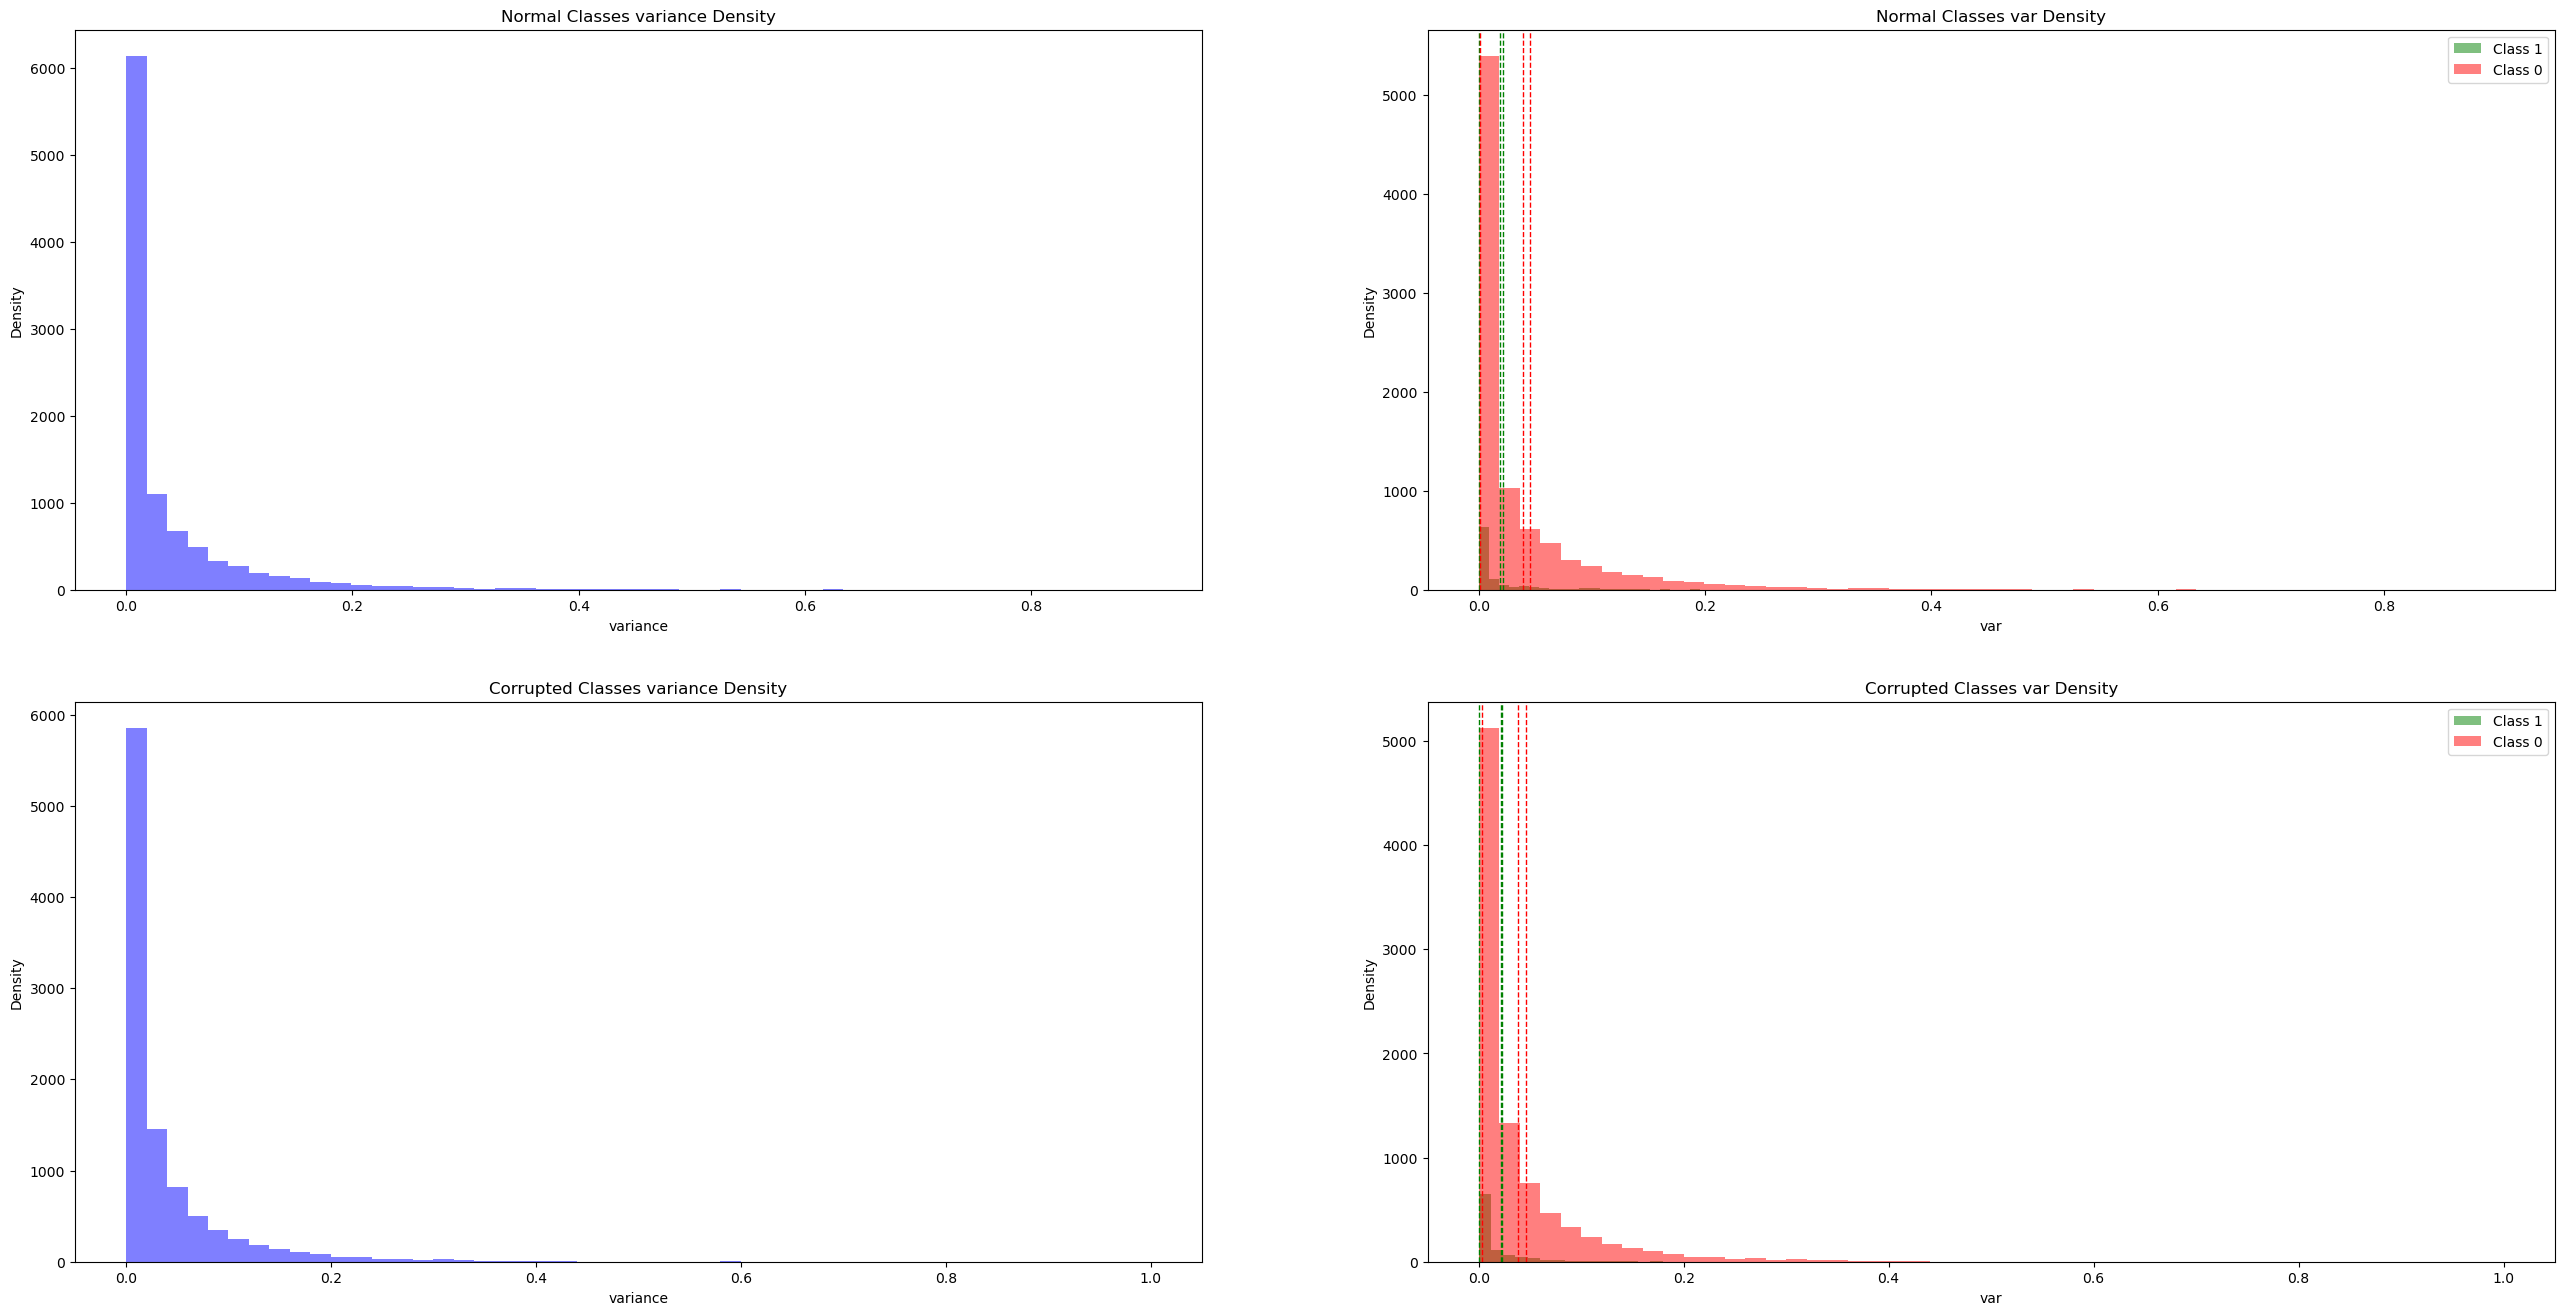

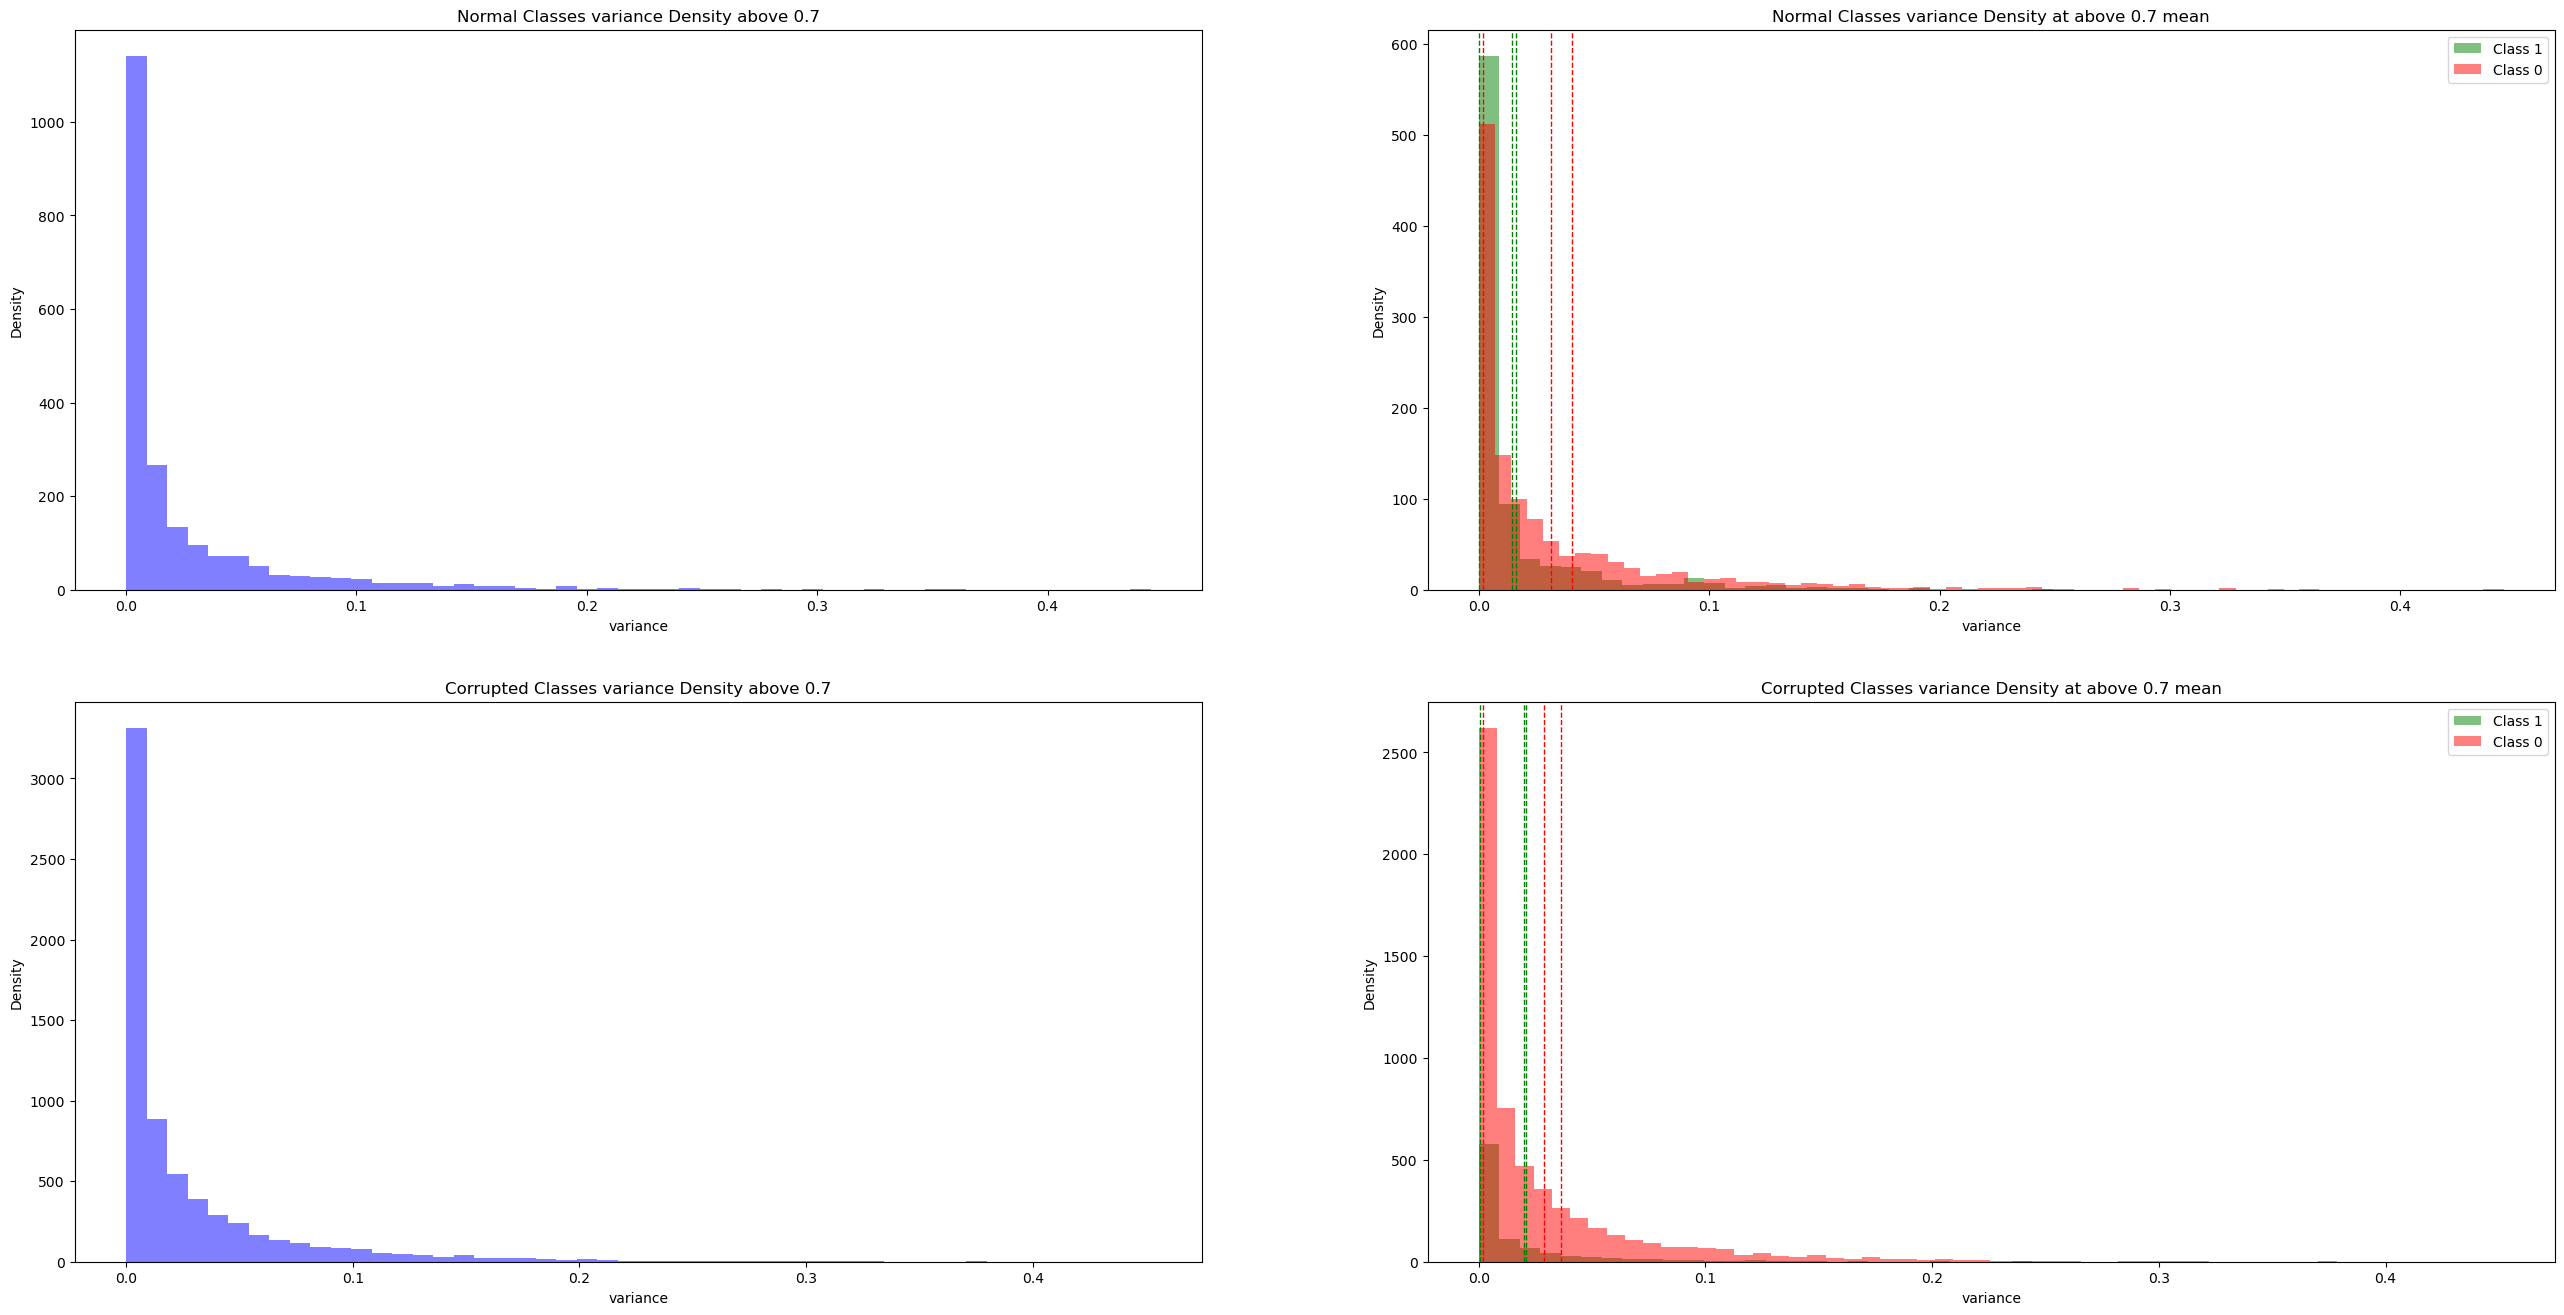

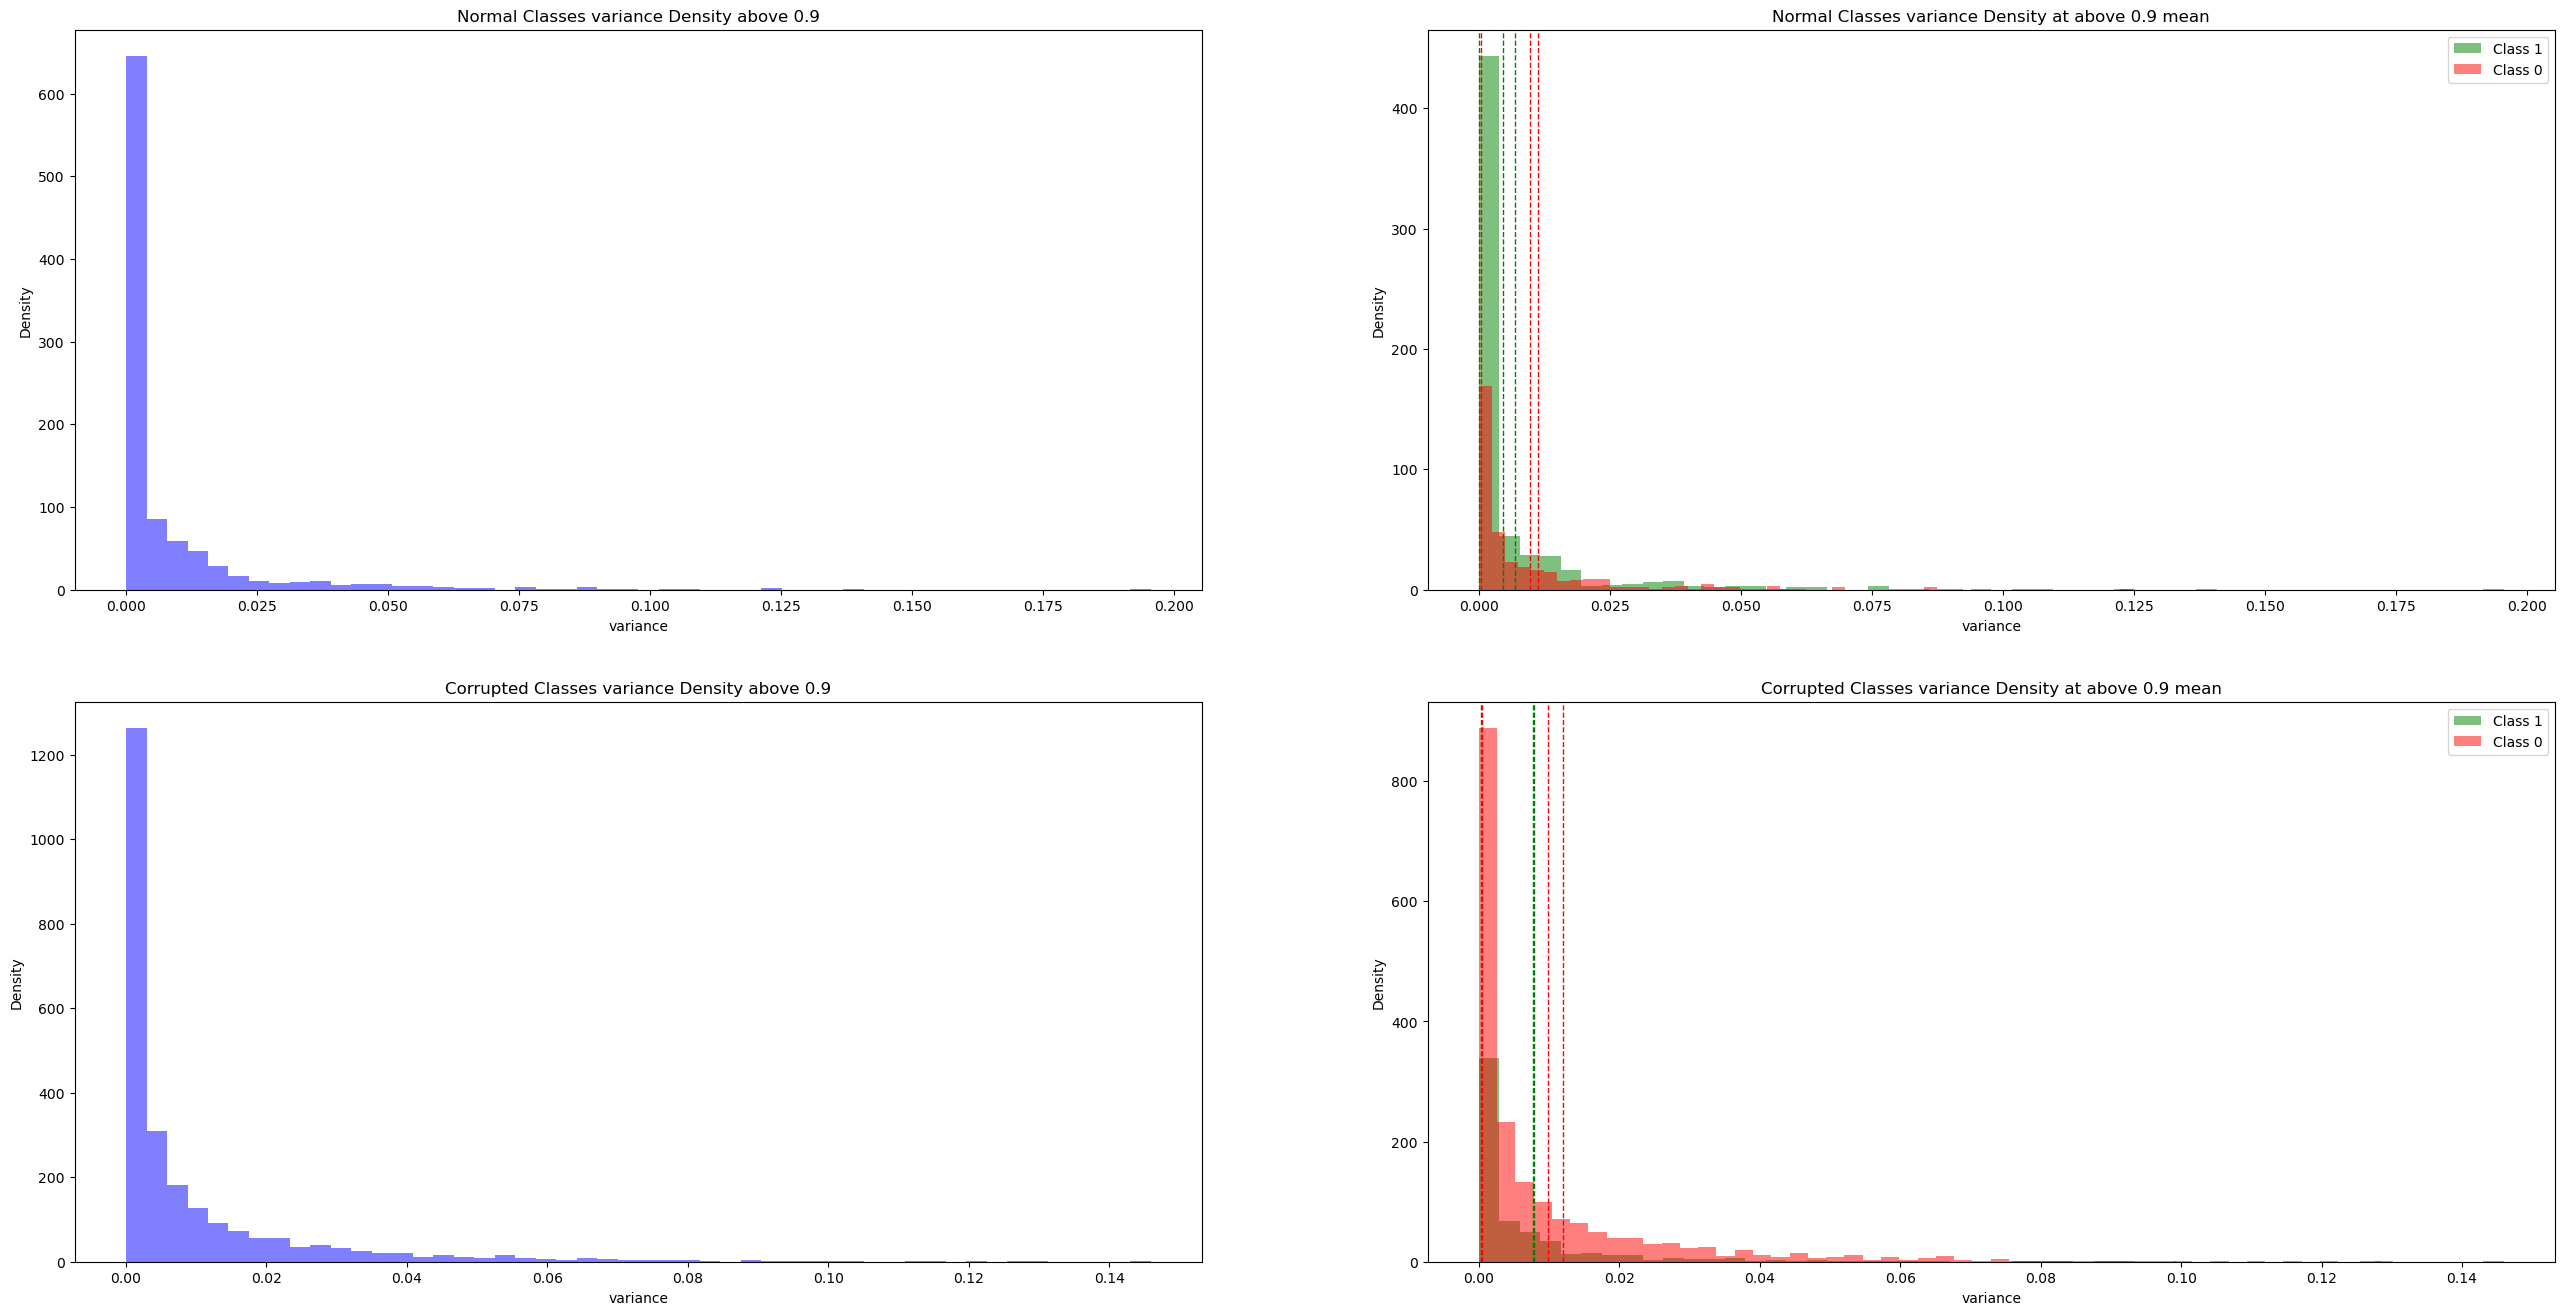

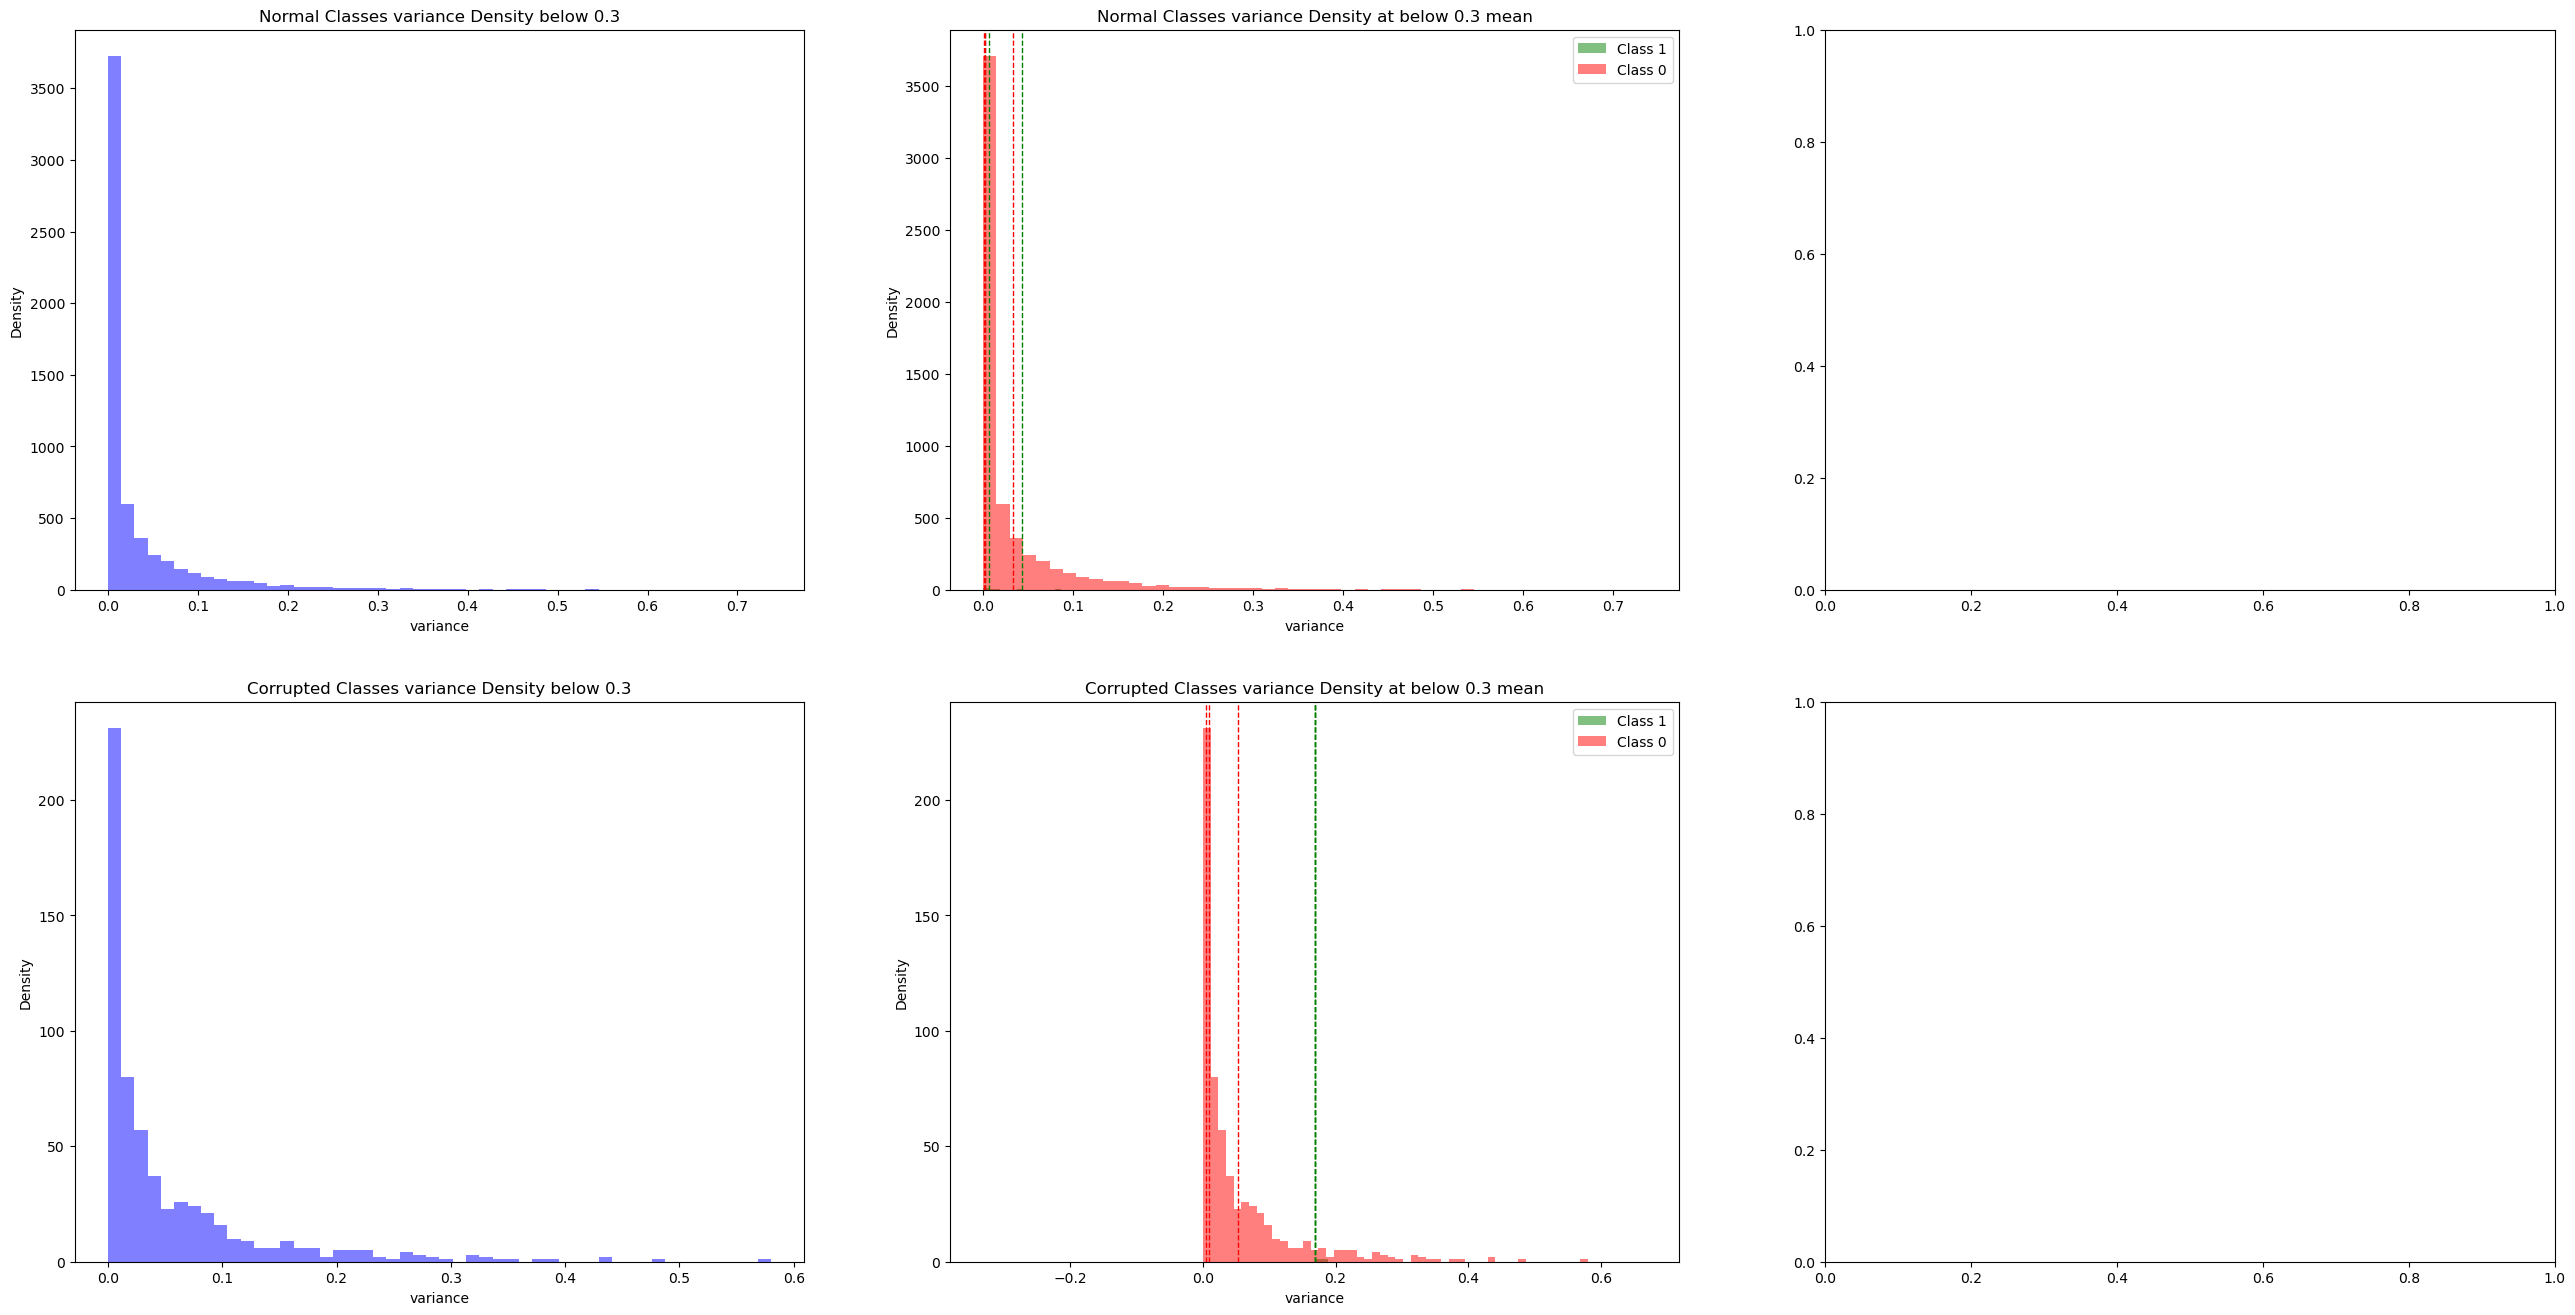

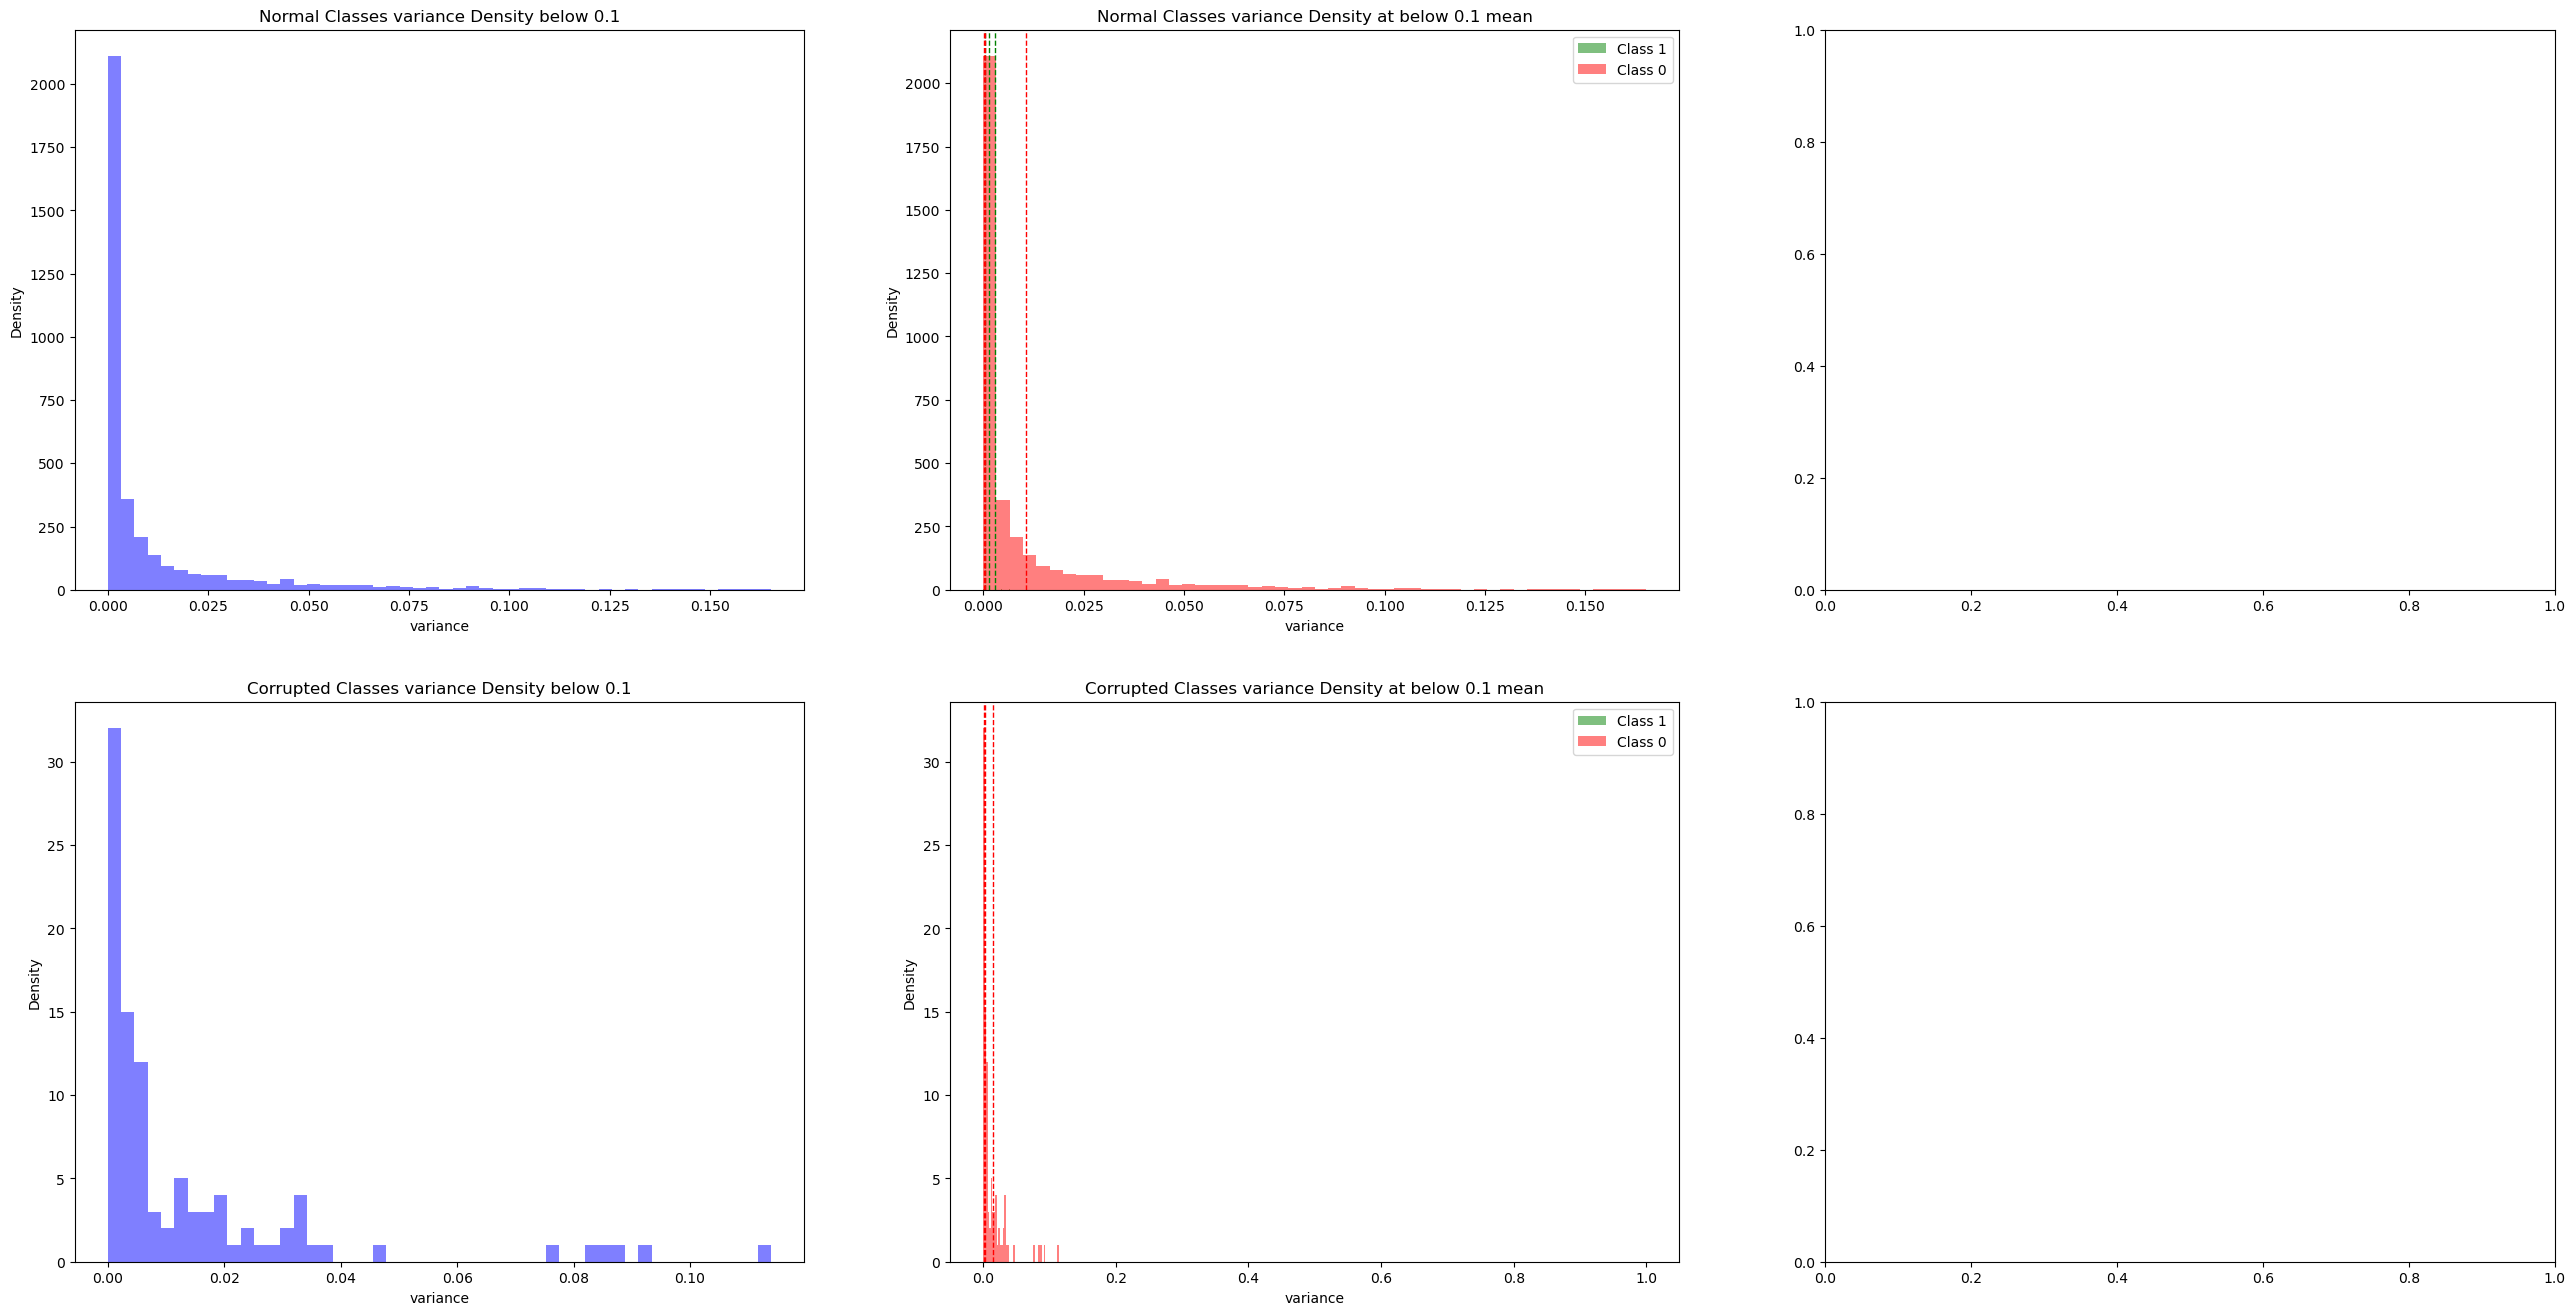

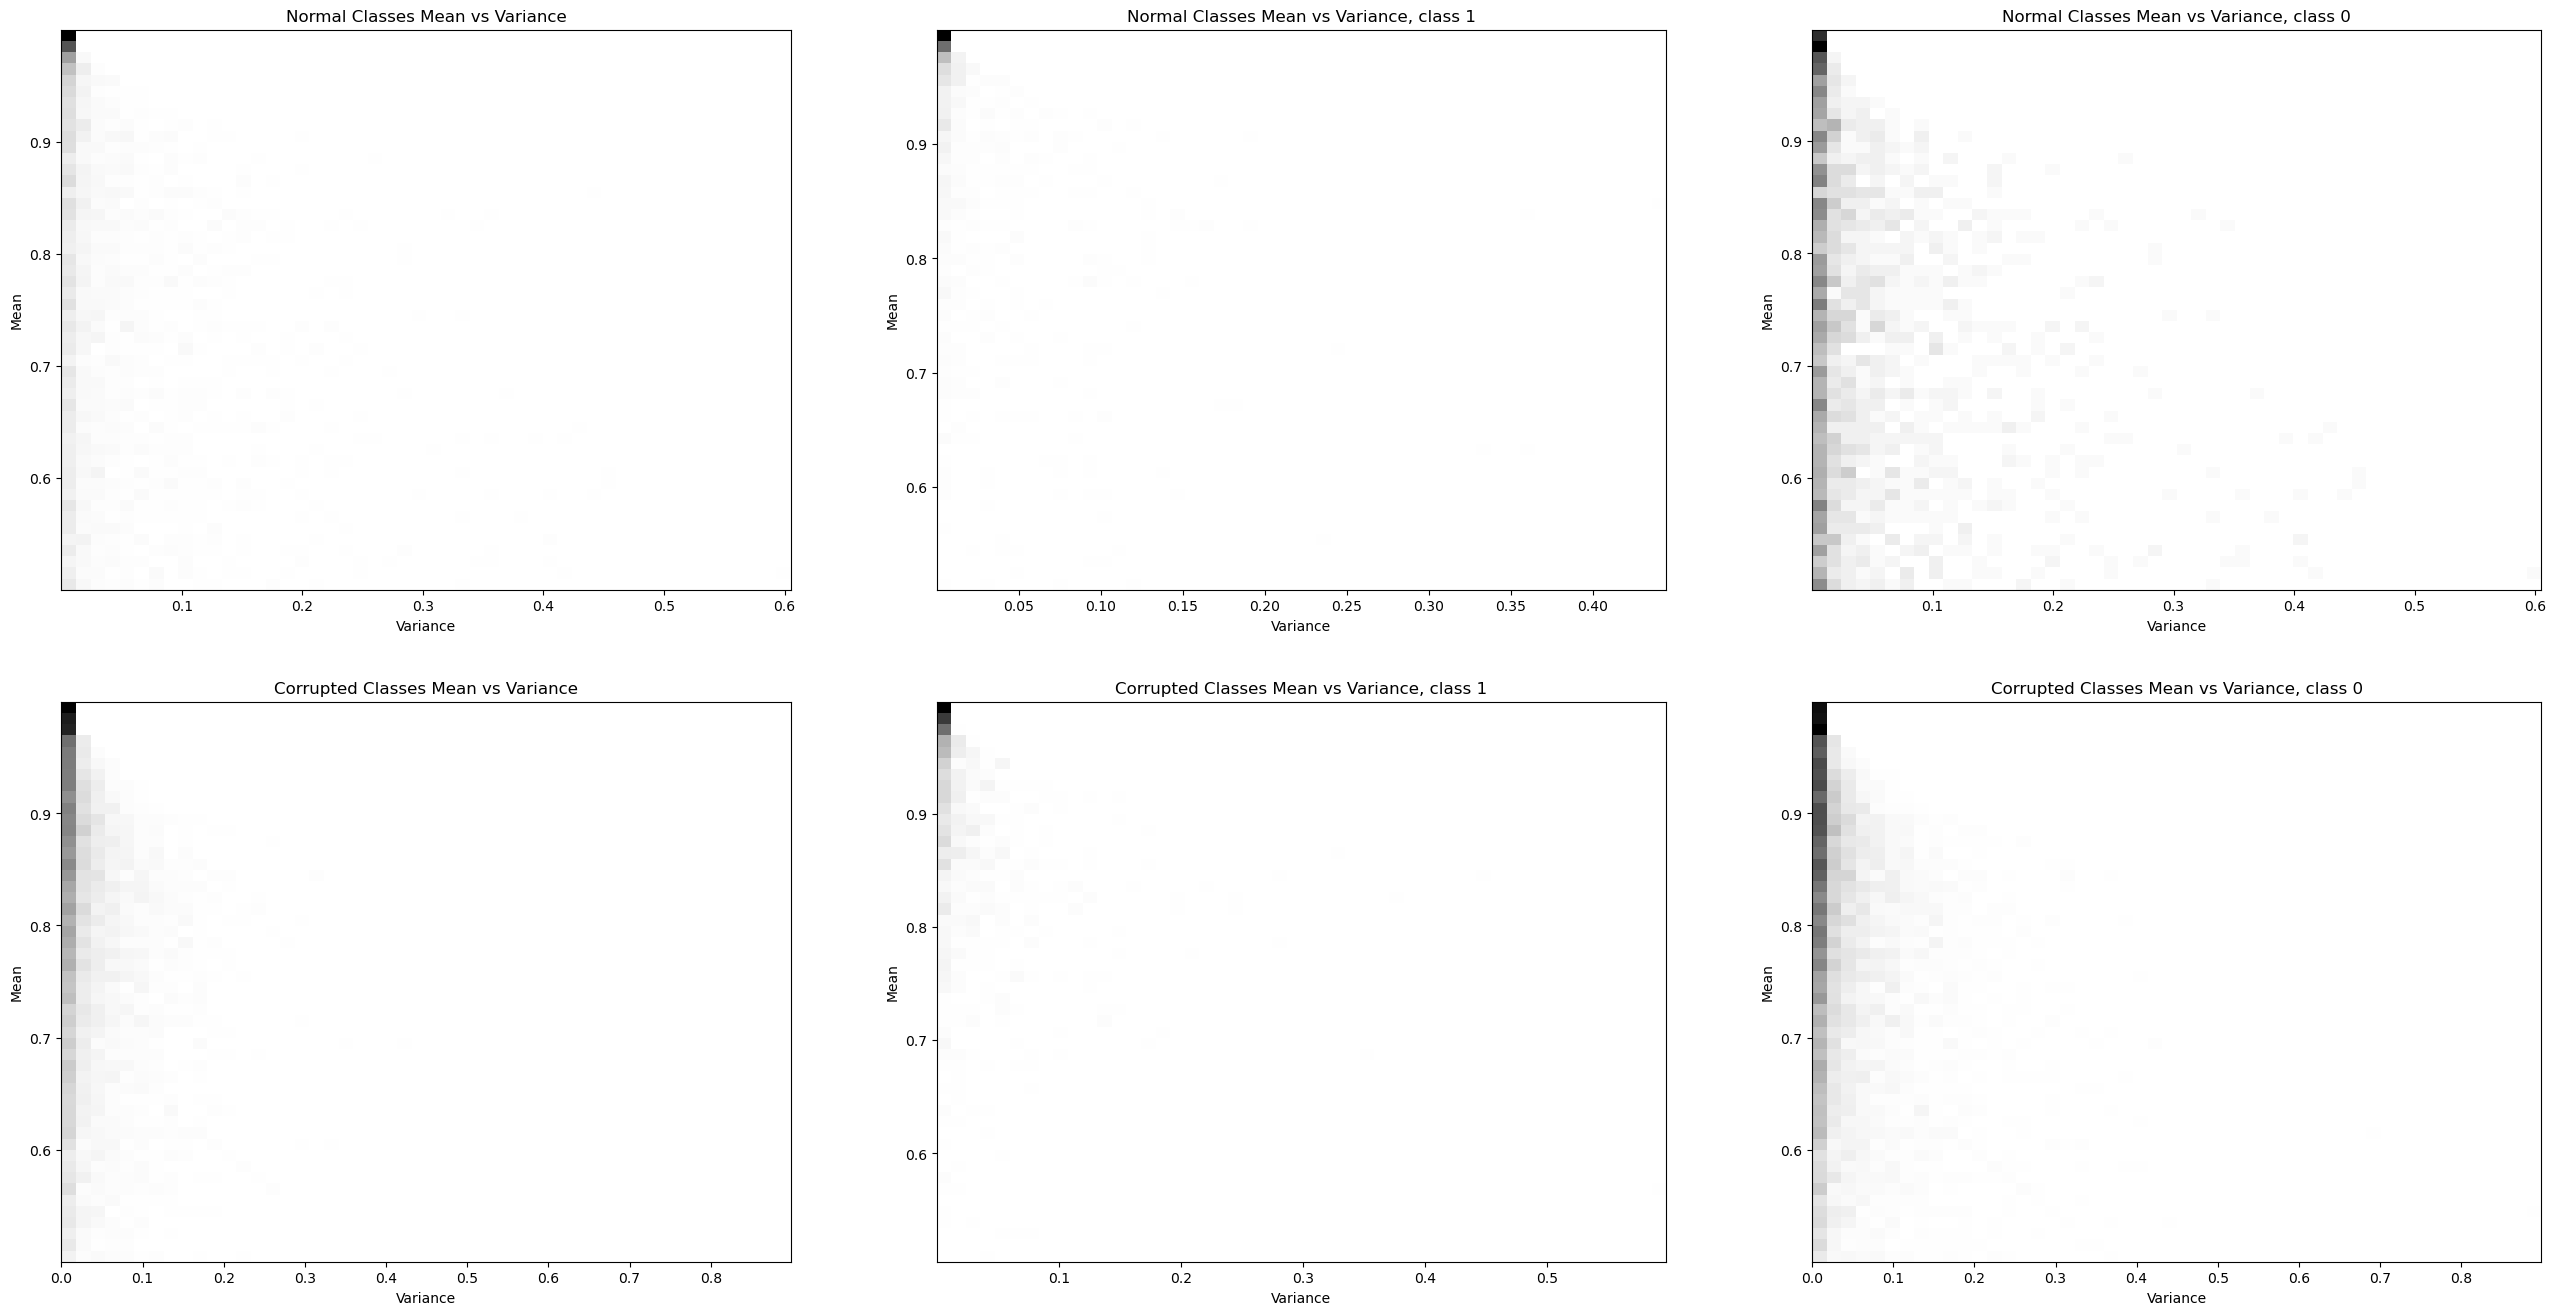

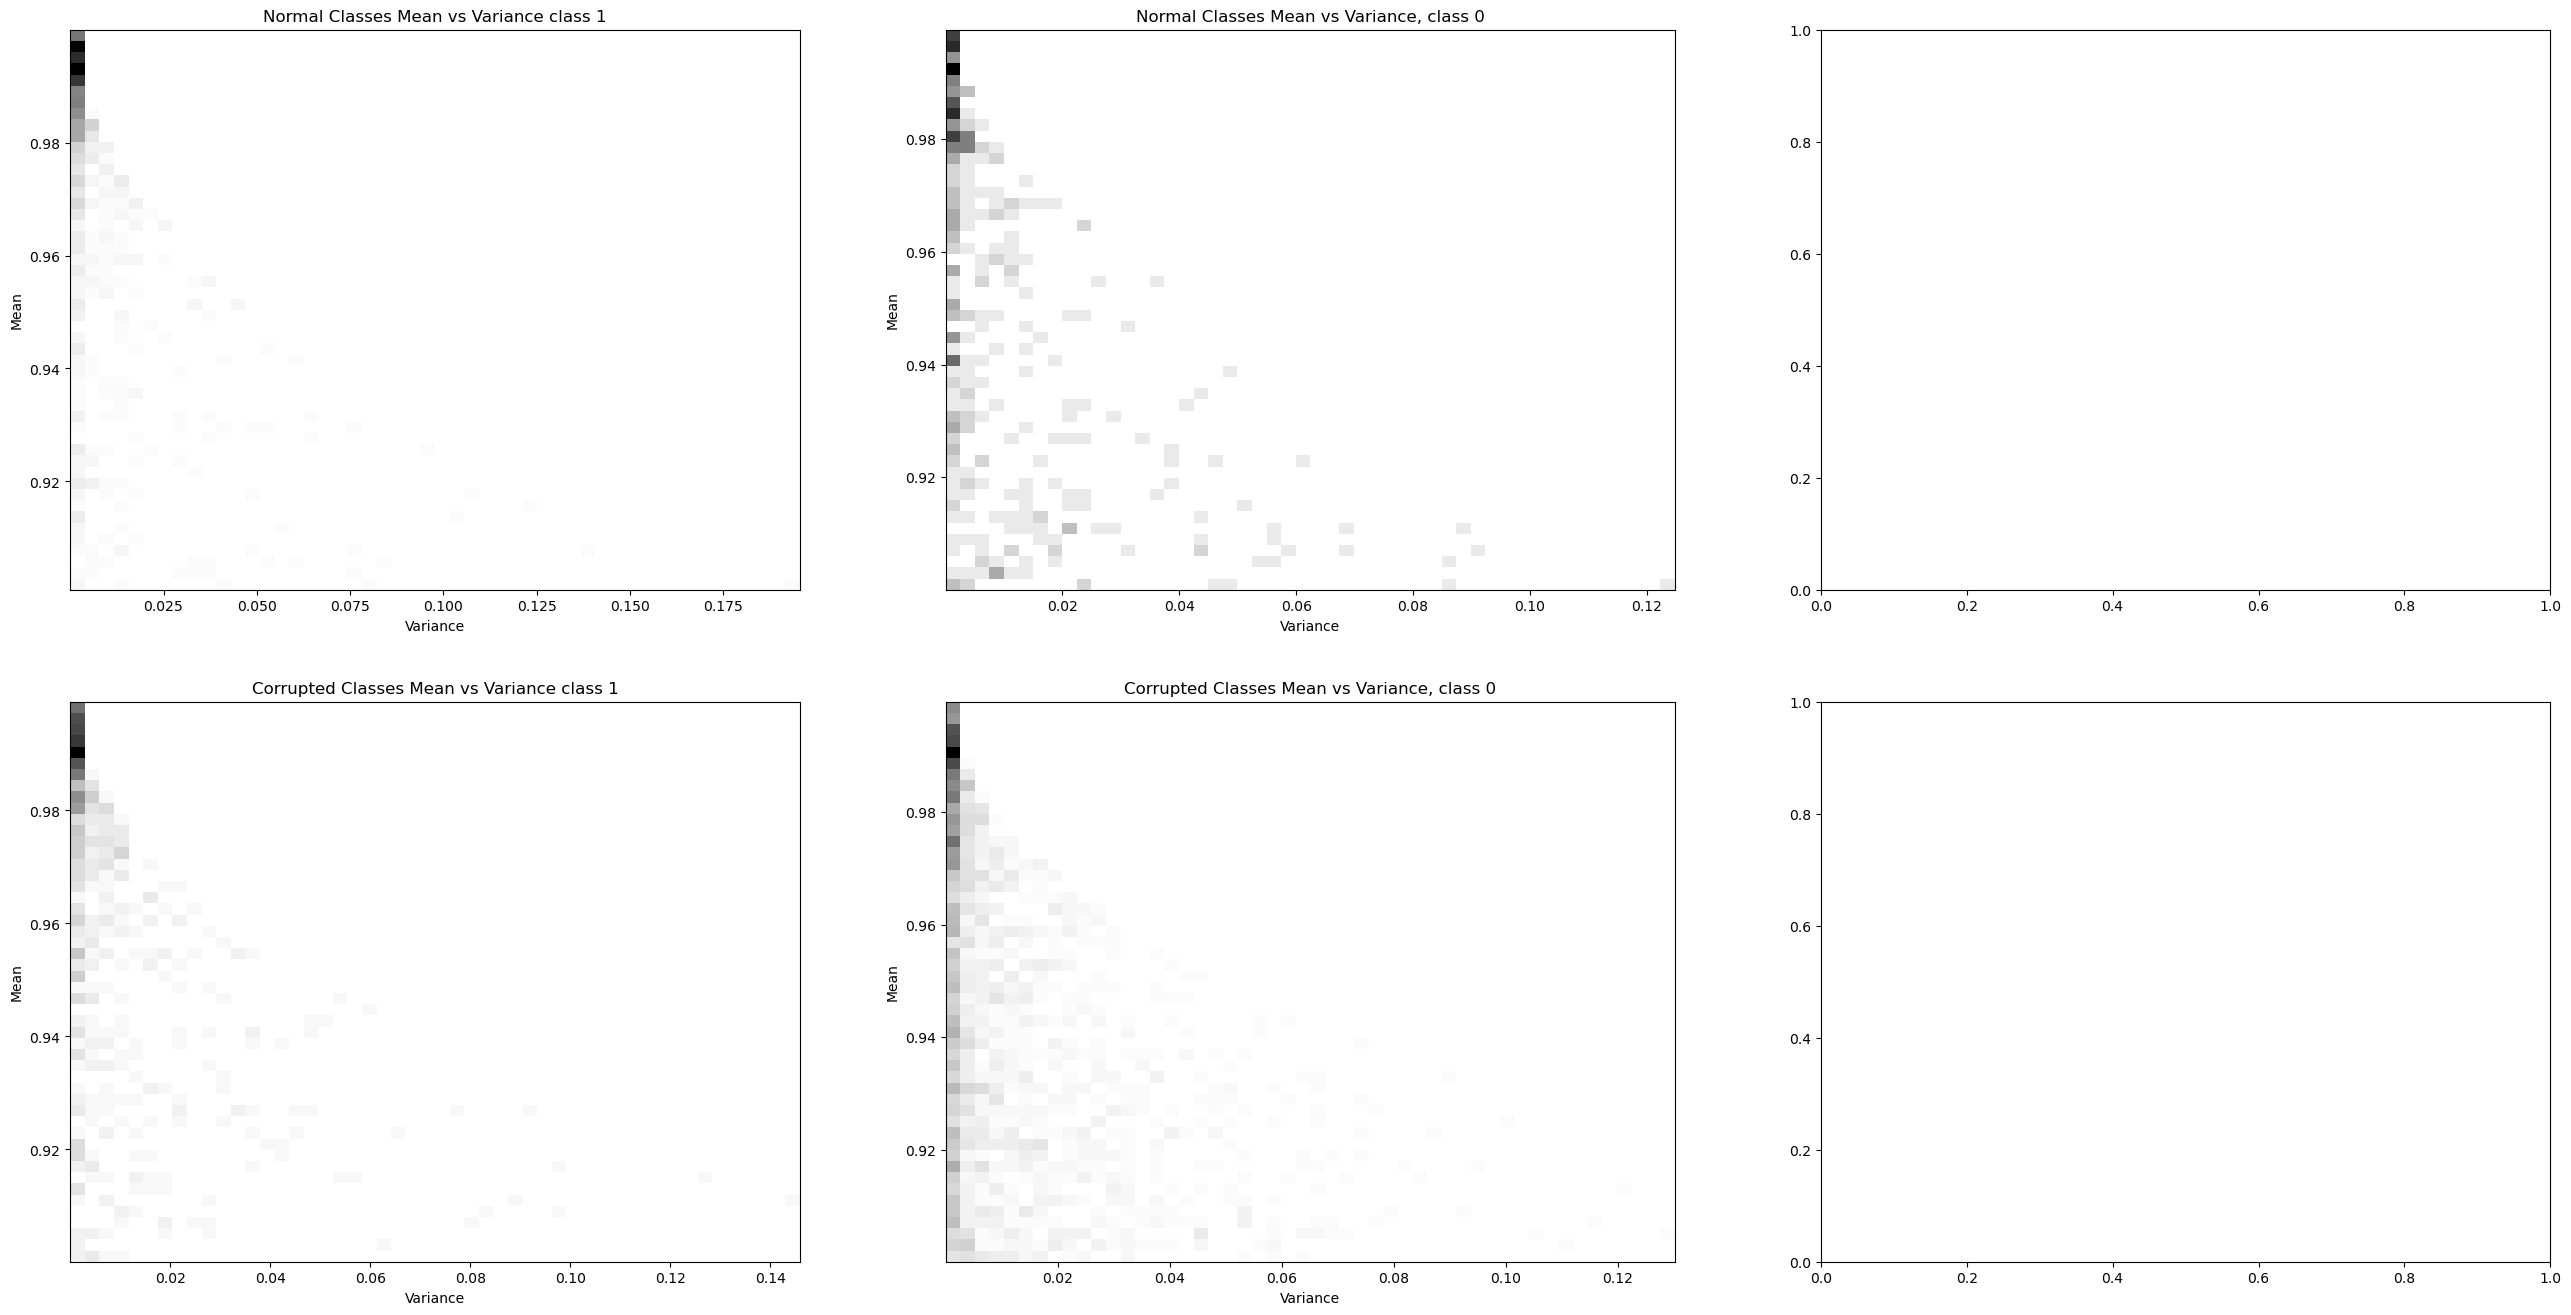

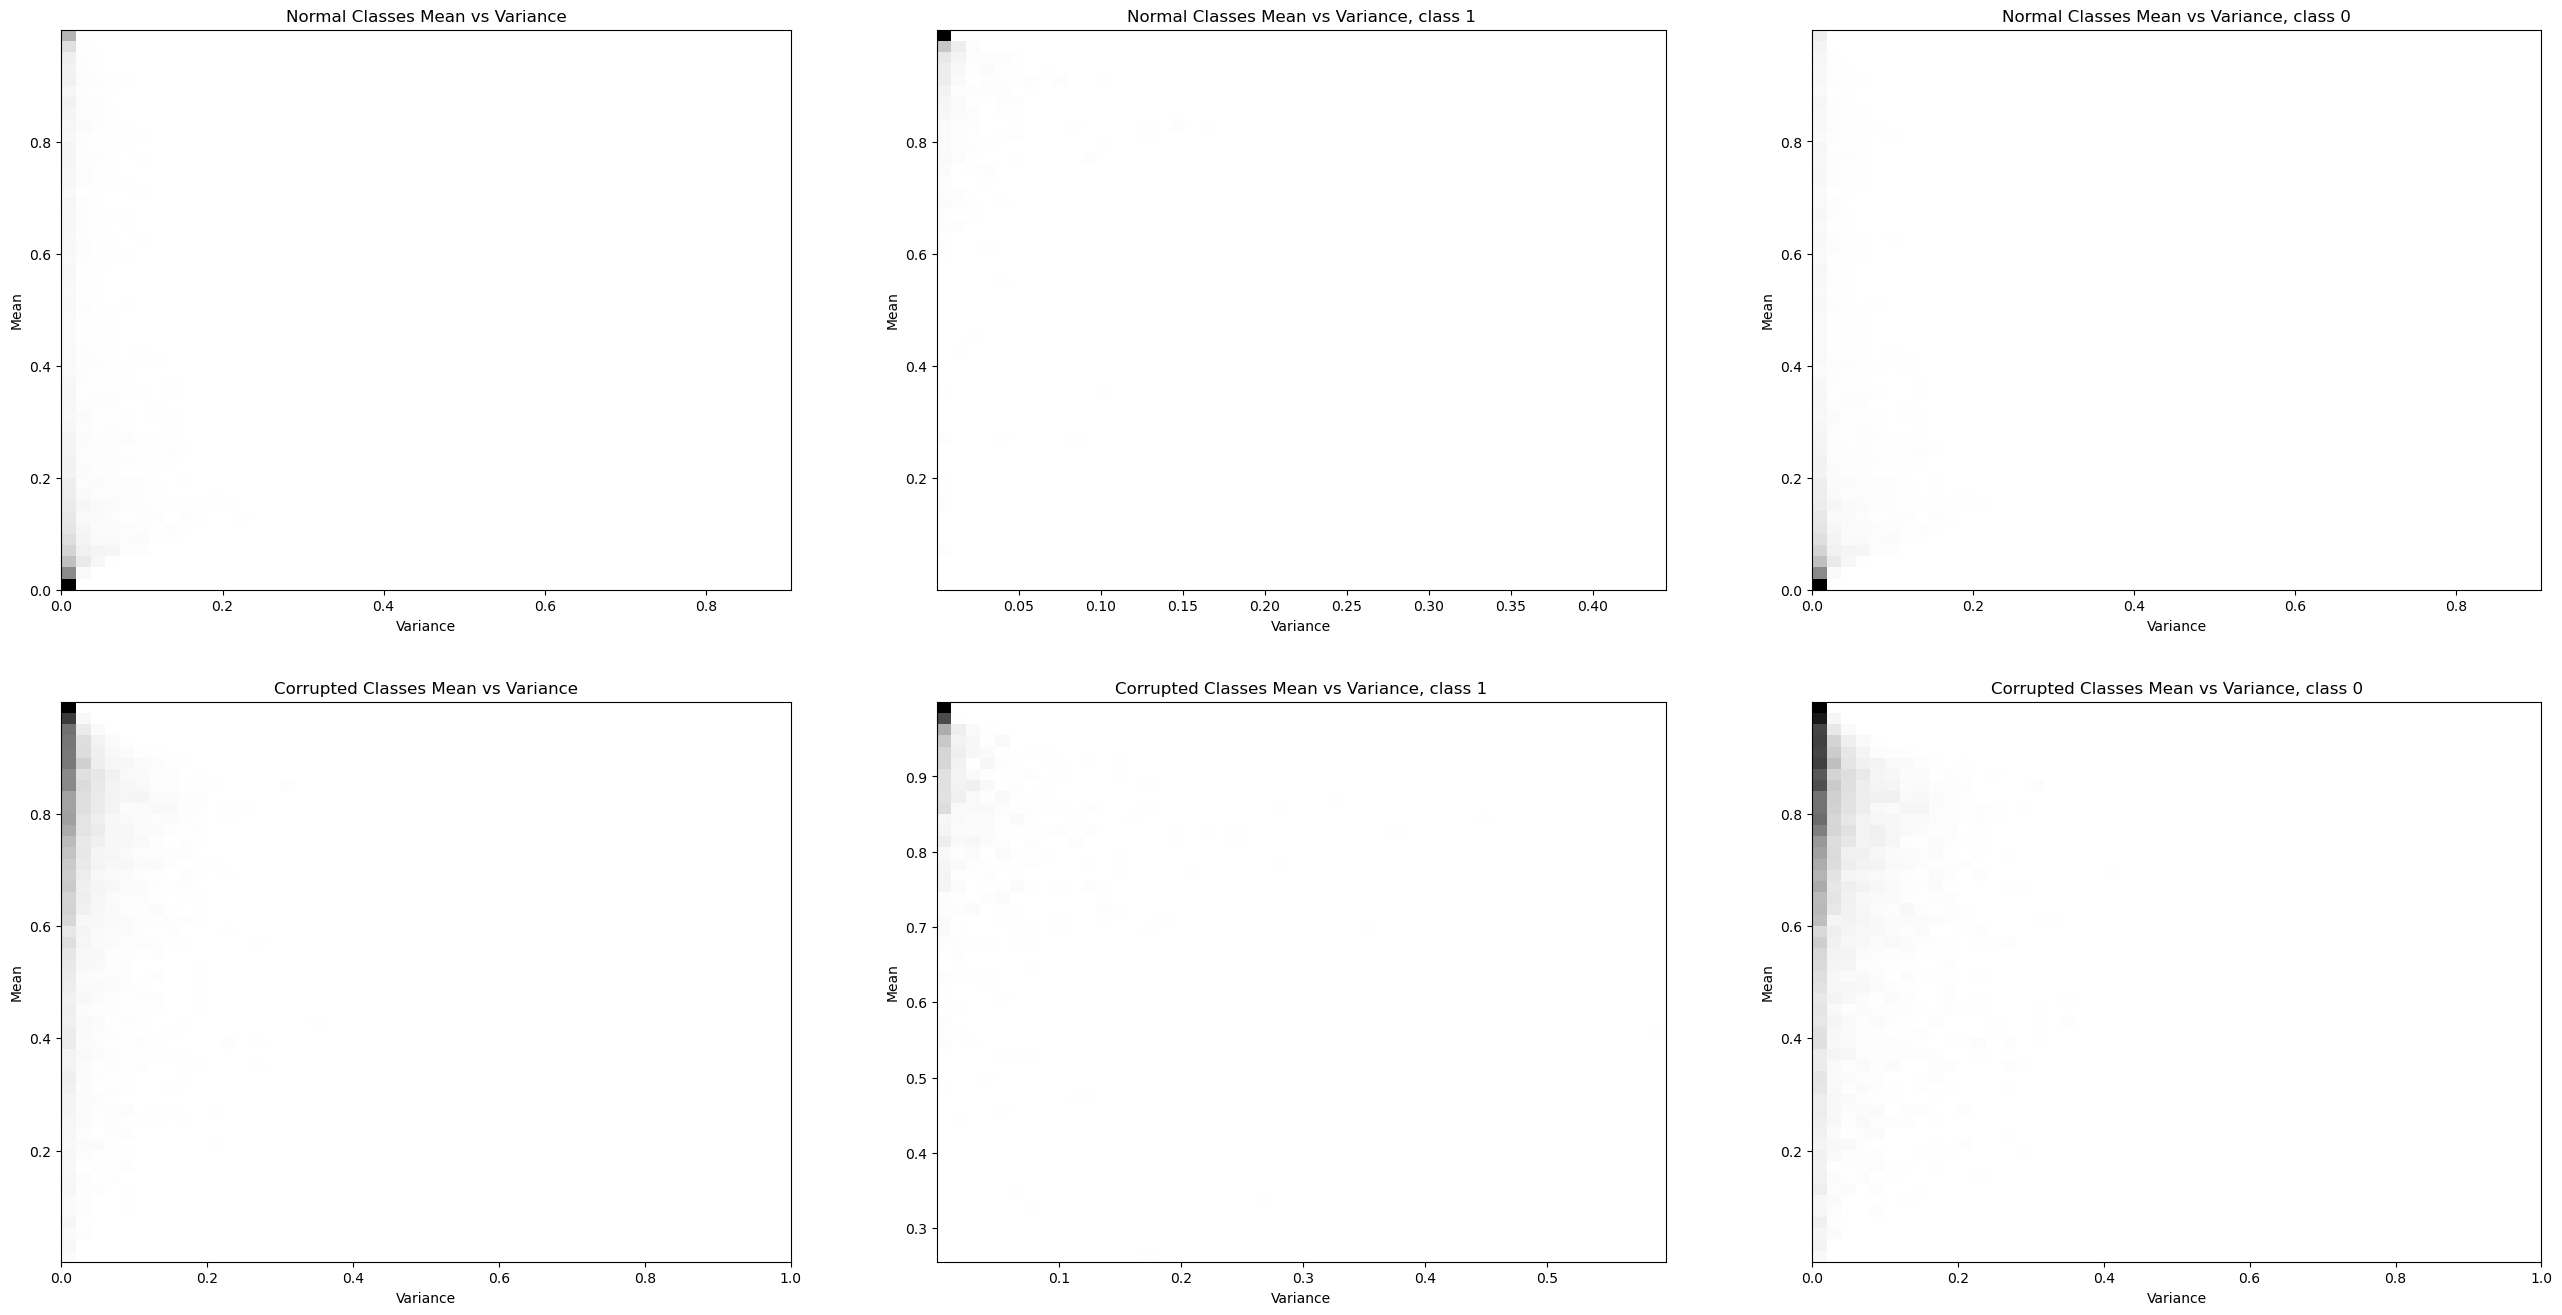

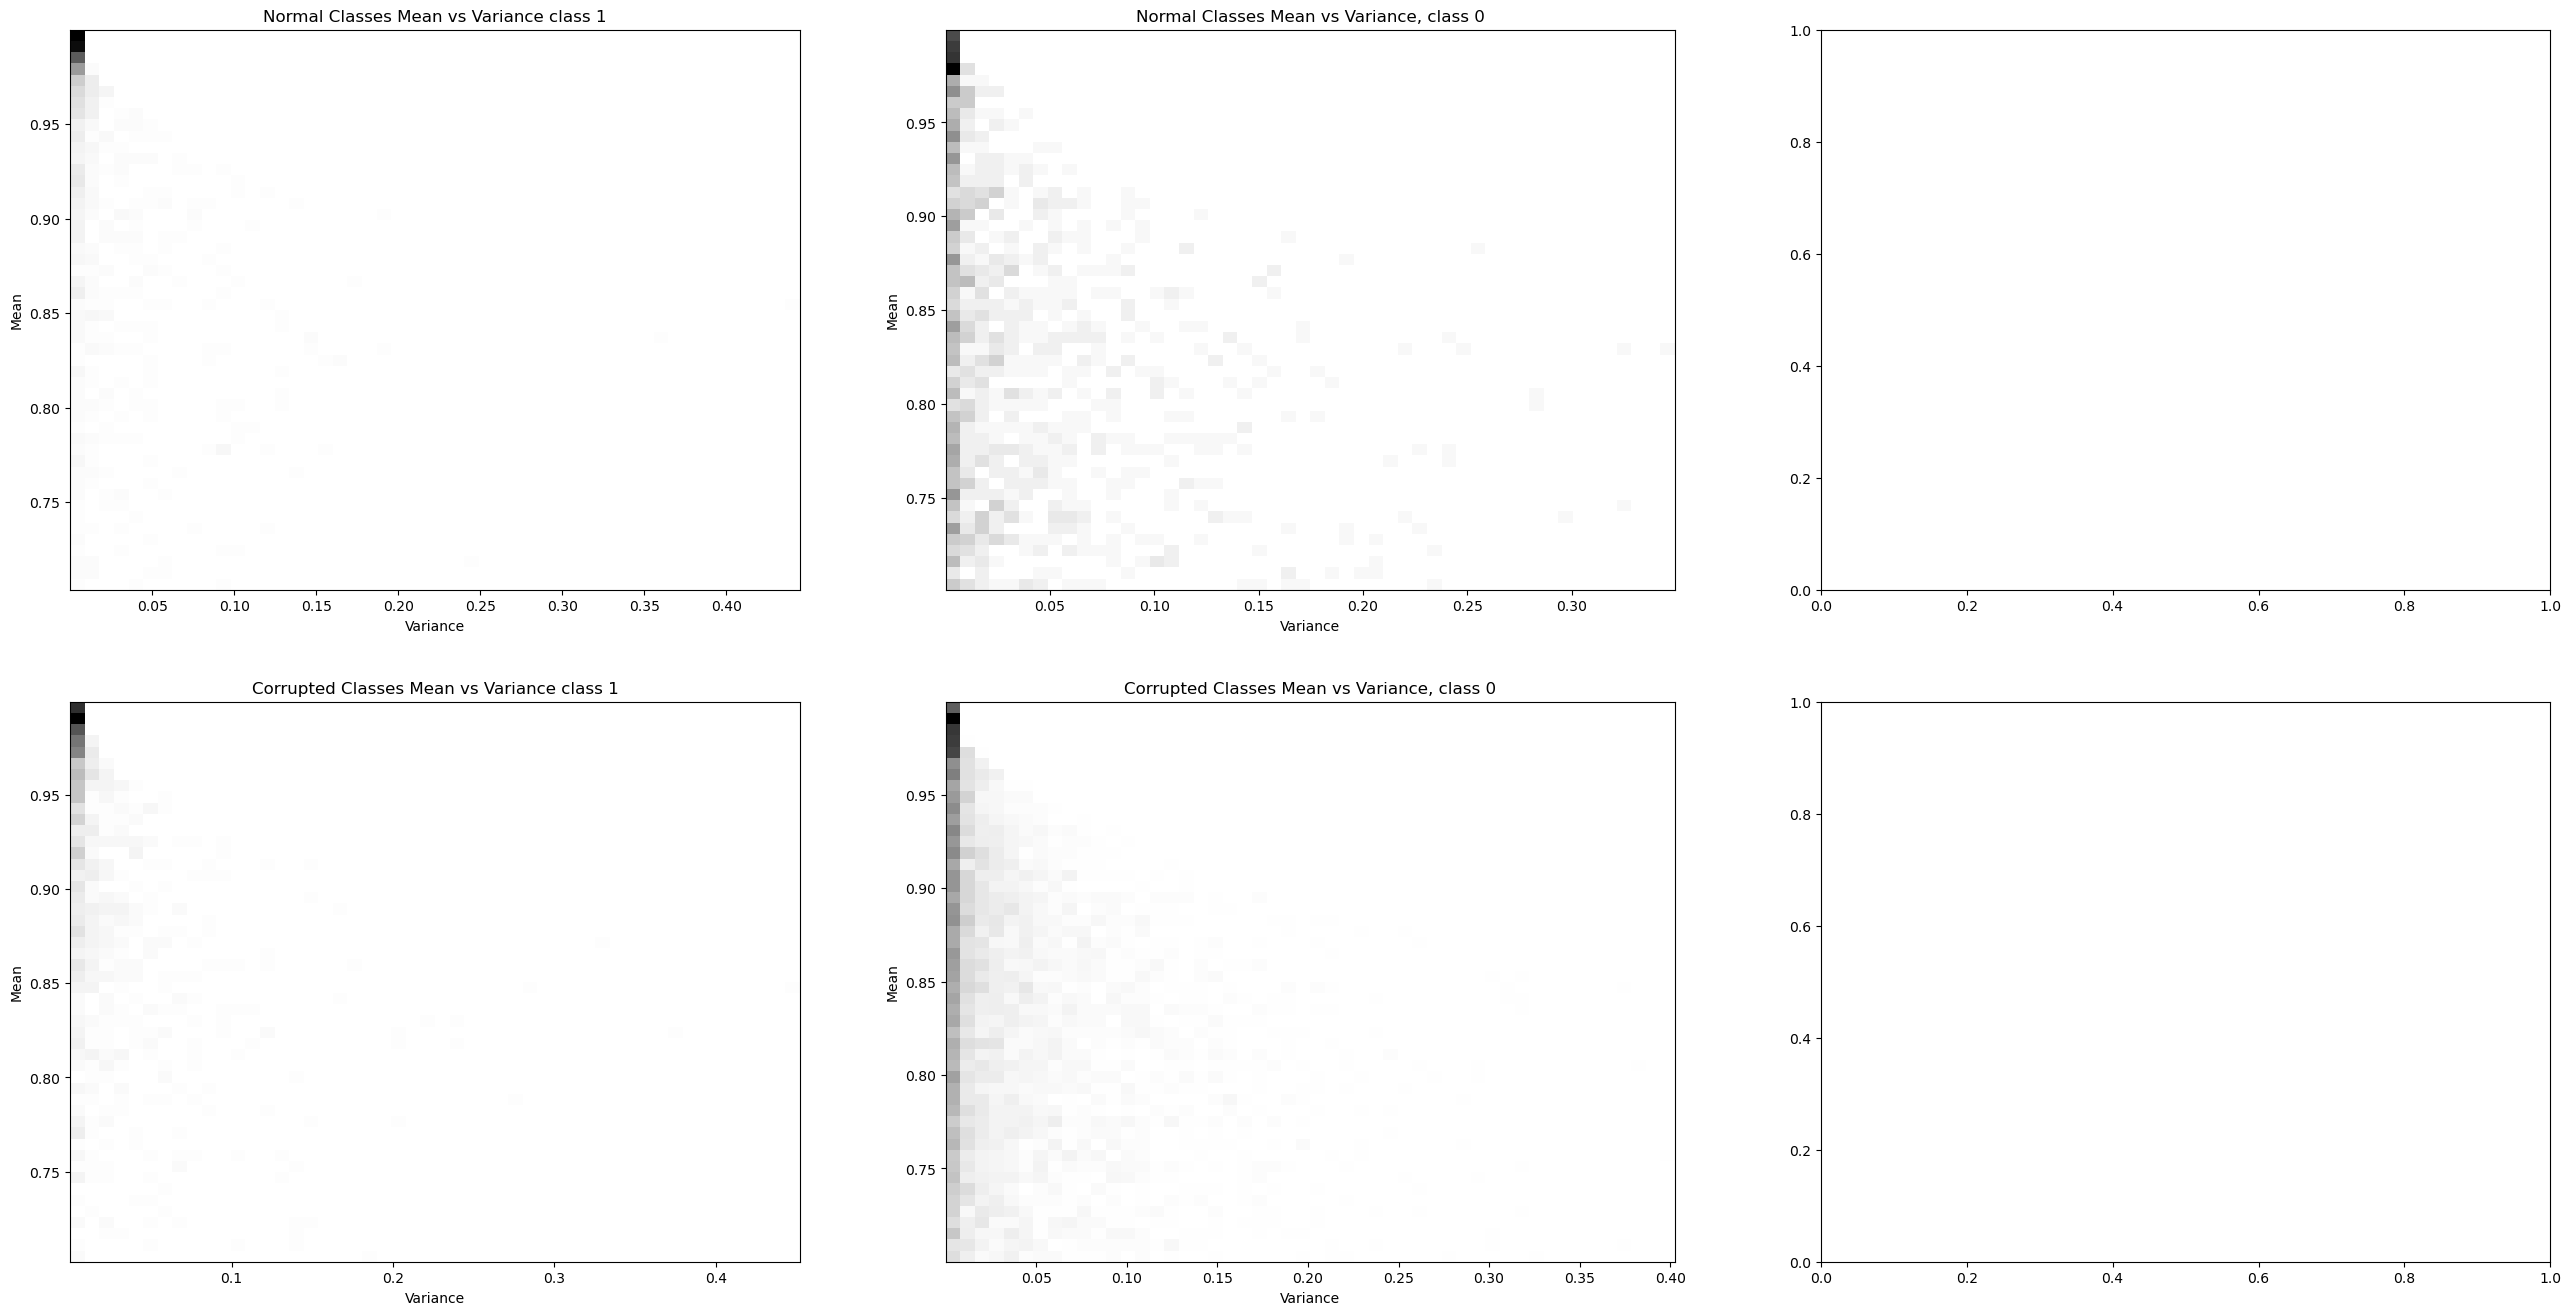

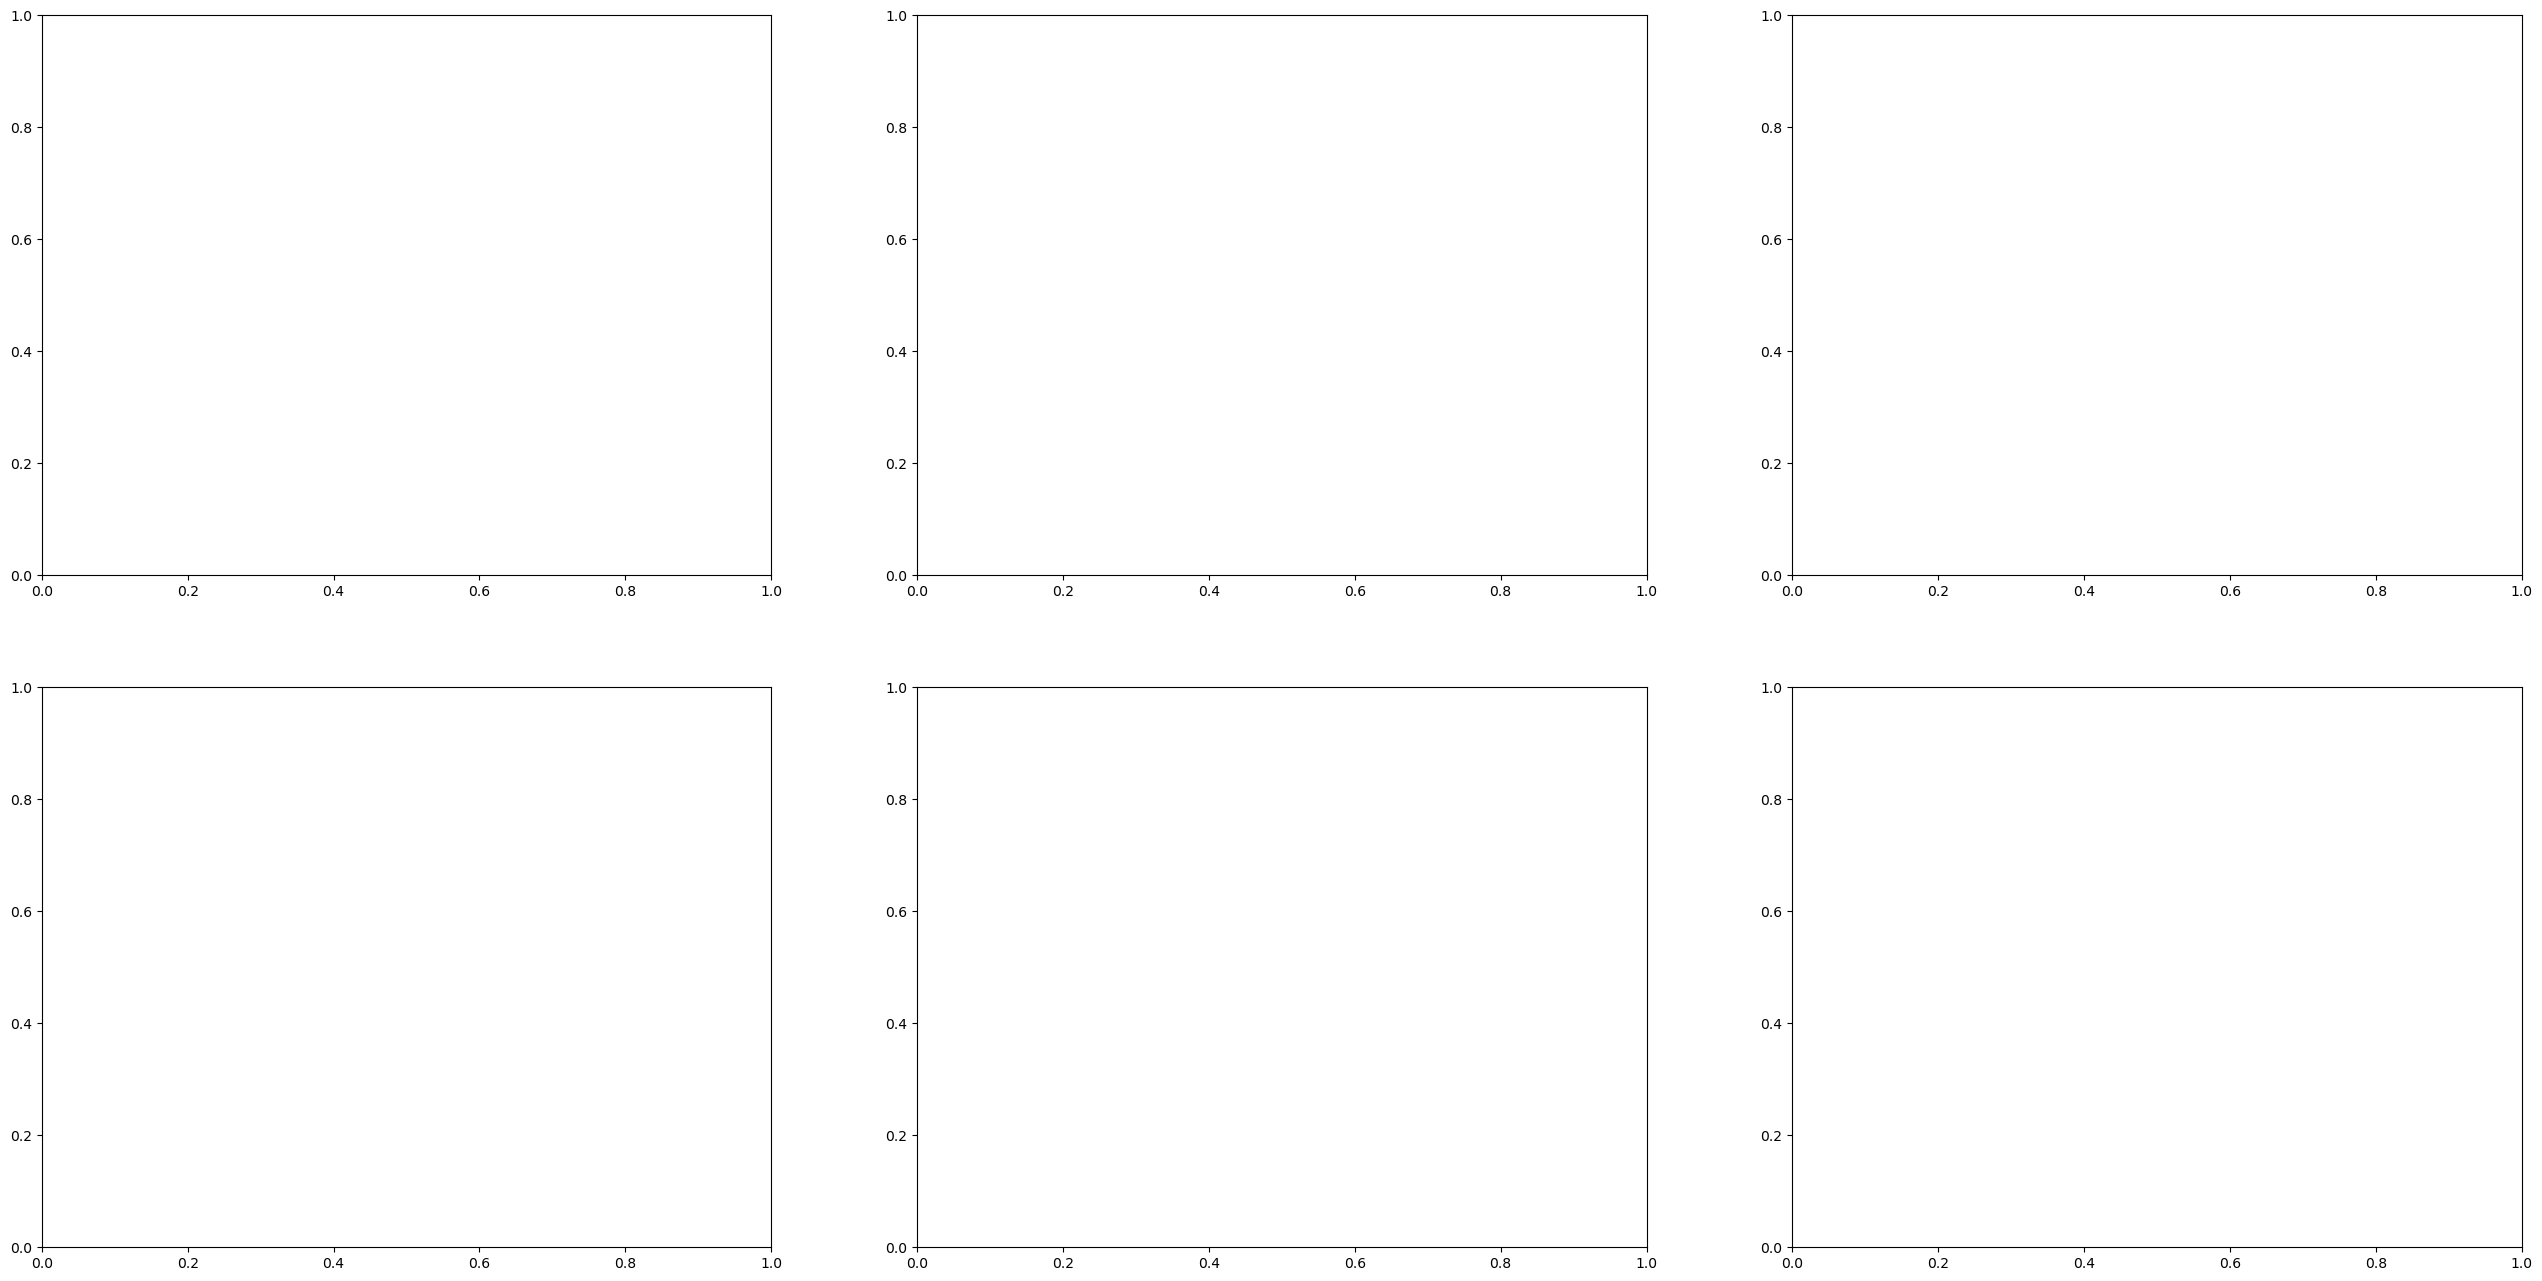

In [95]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
# sns
import seaborn as sns

def normalize_and_plot(x, y, color, label=None, axs=None, plot_quantile=False):
    """Normalize and plot the given data."""
    # Convert to numpy for plotting

    # Normalize x and y
    # x_numpy_normalized = (x - x.min()) / (x.max() - x.min())
    # y_numpy_normalized = (y - y.min()) / (y.max() - y.min())

    # Plotting
    # fix y axis between 0 and 1
    axs.set_ylim(0, 1)
    axs.set_xlim(0, 1)
    axs.scatter(x, y, color=color, label=label, s=2, alpha=0.3)
    if x.shape[0] > 0 and y.shape[0] > 0 and plot_quantile:

        # Prepare data for quantile regression
        df = pd.DataFrame({'x': x, 'y': y})

        # Fit a quantile regression model
        mod = smf.quantreg('y ~ x', df)
        res1 = mod.fit(q=0.5)
        res2 = mod.fit(q=0.95)

        # Get the fitted values
        y_pred1 = res1.predict(df['x'])
        y_pred2 = res2.predict(df['x'])

        # Plot the quantile regression line
        axs.plot(x, y_pred1, color=color, linewidth=2)
        axs.plot(x, y_pred2, color=color, linewidth=2)
        

print()

def plot_confidence_vs_variance_findings(dataframe_names, dataframes, plot_correctness=['correct', 'incorrect'], plot_quantile=False):

    # We want to get the max and min of the variance, mean and confidence values accross all dataframes
    # This is so we can normalize the values and plot them on the same scale
    max_variance = max([df['variance'].max() for df in dataframes.values()])
    min_variance = min([df['variance'].min() for df in dataframes.values()])
    max_mean = max([df['mean'].max() for df in dataframes.values()])
    min_mean = min([df['mean'].min() for df in dataframes.values()])
    max_confidence = max([df['confidence'].max() for df in dataframes.values()])
    min_confidence = min([df['confidence'].min() for df in dataframes.values()])

    j = len(dataframe_names)

    if j == 1: 
        j = 2

    fig, axs = plt.subplots(j, 4, figsize=(32, 16))
    fig6, axs6 = plt.subplots(j, 2, figsize=(32, 16))
    fig3, axs3 = plt.subplots(j, 2, figsize=(32, 16))
    fig4, axs4 = plt.subplots(j, 2, figsize=(32, 16))
    fig5, axs5 = plt.subplots(j, 2, figsize=(32, 16))
    fig12, axs12 = plt.subplots(j, 2, figsize=(32, 16))
    fig7, axs7 = plt.subplots(j, 2, figsize=(32, 16))
    fig14, axs14 = plt.subplots(j, 3, figsize=(32, 16))
    fig15, axs15 = plt.subplots(j, 3, figsize=(32, 16))
    fig10, axs10 = plt.subplots(j, 3, figsize=(32, 16))
    fig8, axs8 = plt.subplots(j, 3, figsize=(32, 16))
    fig2, axs2 = plt.subplots(j, 3, figsize=(32, 16))
    fig9, axs9 = plt.subplots(j, 3, figsize=(32, 16))
    fig21, axs21 = plt.subplots(j, 3, figsize=(32, 16))

    for i, name in enumerate(dataframe_names):

        if name == 'normal':
            colour_correct = 'blue'
            colour_false = 'red'
            colour_true = 'blue'
            colour_false = 'red'
            label = 'Normal Classes'
            df = dataframes['normal']
        elif name == 'held_out':
            colour_correct = 'green'
            colour_false = 'orange'
            colour_true = 'green'
            colour_false = 'orange'
            label = 'Held Out Classes'
            df = dataframes['held_out']
        elif name == 'corrupted':
            colour_correct = 'green'
            colour_false = 'orange'
            colour_true = 'green'
            colour_false = 'orange'
            label = 'Corrupted Classes'
            df = dataframes['corrupted']


        df['mean_normalized'] = (df['mean'] - min_confidence) / (max_mean - min_mean)
        df['variance_normalized'] = (df['variance'] - min_variance) / (max_variance - min_variance)
        df['confidence_normalized'] = (df['confidence'] - min_confidence) / (max_confidence - min_confidence)

        # Plot an intensity plot of the confidence vs variance for the correct and incorrect predictions
        axs2[i][0].hist2d(df['variance_normalized'], df['mean_normalized'], bins=(50, 50), cmap=plt.cm.binary)
        axs2[i][0].set_title(f'{label} Mean vs Variance')
        axs2[i][0].set_xlabel('Variance')
        axs2[i][0].set_ylabel('Mean')

        axs2[i][1].hist2d(df[df['label'] == 1]['variance_normalized'].to_numpy(), df[df['label'] == 1]['mean_normalized'].to_numpy(), bins=(50, 50), cmap=plt.cm.binary)
        axs2[i][1].set_title(f'{label} Mean vs Variance, class 1')
        axs2[i][1].set_xlabel('Variance')
        axs2[i][1].set_ylabel('Mean')

        axs2[i][2].hist2d(df[df['label'] == 0]['variance_normalized'].to_numpy(), df[df['label'] == 0]['mean_normalized'].to_numpy(), bins=(50, 50), cmap=plt.cm.binary)
        axs2[i][2].set_title(f'{label} Mean vs Variance, class 0')
        axs2[i][2].set_xlabel('Variance')
        axs2[i][2].set_ylabel('Mean')

        axs10[i][0].hist2d(df['variance_normalized'][df['mean_normalized'] > 0.5], df['mean_normalized'][df['mean_normalized'] > 0.5], bins=(50, 50), cmap=plt.cm.binary)
        axs10[i][0].set_title(f'{label} Mean vs Variance')
        axs10[i][0].set_xlabel('Variance')
        axs10[i][0].set_ylabel('Mean')

        axs10[i][1].hist2d(df[df['label'] == 1]['variance_normalized'][df['mean_normalized'] > 0.5].to_numpy(), df[df['label'] == 1]['mean_normalized'][df['mean_normalized'] > 0.5].to_numpy(), bins=(50, 50), cmap=plt.cm.binary)
        axs10[i][1].set_title(f'{label} Mean vs Variance, class 1')
        axs10[i][1].set_xlabel('Variance')
        axs10[i][1].set_ylabel('Mean')

        axs10[i][2].hist2d(df[df['label'] == 0]['variance_normalized'][df['mean_normalized'] > 0.5].to_numpy(), df[df['label'] == 0]['mean_normalized'][df['mean_normalized'] > 0.5].to_numpy(), bins=(50, 50), cmap=plt.cm.binary)
        axs10[i][2].set_title(f'{label} Mean vs Variance, class 0')
        axs10[i][2].set_xlabel('Variance')
        axs10[i][2].set_ylabel('Mean')

        axs8[i][0].hist2d(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 1], df['mean_normalized'][df['mean_normalized'] > 0.9][df['label'] == 1], bins=(50, 50), cmap=plt.cm.binary)
        axs8[i][0].set_title(f'{label} Mean vs Variance class 1')
        axs8[i][0].set_xlabel('Variance')
        axs8[i][0].set_ylabel('Mean')

        axs8[i][1].hist2d(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 0], df['mean_normalized'][df['mean_normalized'] > 0.9][df['label'] == 0], bins=(50, 50), cmap=plt.cm.binary)
        axs8[i][1].set_title(f'{label} Mean vs Variance, class 0')
        axs8[i][1].set_xlabel('Variance')
        axs8[i][1].set_ylabel('Mean')

        axs9[i][0].hist2d(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 1], df['mean_normalized'][df['mean_normalized'] > 0.7][df['label'] == 1], bins=(50, 50), cmap=plt.cm.binary)
        axs9[i][0].set_title(f'{label} Mean vs Variance class 1')
        axs9[i][0].set_xlabel('Variance')
        axs9[i][0].set_ylabel('Mean')

        axs9[i][1].hist2d(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 0], df['mean_normalized'][df['mean_normalized'] > 0.7][df['label'] == 0], bins=(50, 50), cmap=plt.cm.binary)
        axs9[i][1].set_title(f'{label} Mean vs Variance, class 0')
        axs9[i][1].set_xlabel('Variance')
        axs9[i][1].set_ylabel('Mean')
        # a plot where the x axis is the variance and the y axis is the density of the variance

        axs6[i][0].hist(df['mean_normalized'], bins=50, color='blue', alpha=0.5, label='All')
        axs6[i][0].set_title(f'{label} mean Density')
        axs6[i][0].set_xlabel('mean')
        axs6[i][0].set_ylabel('Density')
        # plot the mean and quantiles at 0.25 and 0.75
        axs6[i][0].axvline(df['mean_normalized'].mean(), color='k', linestyle='dashed', linewidth=1)
        axs6[i][0].axvline(df['mean_normalized'].quantile(0.25), color='k', linestyle='dashed', linewidth=1)
        axs6[i][0].axvline(df['mean_normalized'].quantile(0.75), color='k', linestyle='dashed', linewidth=1)


        axs6[i][1].hist(df[df['outcome'] == 1]['mean_normalized'].to_numpy(), bins=50, color='green', alpha=0.5, label='Correct')
        axs6[i][1].hist(df[df['outcome'] == 0]['mean_normalized'].to_numpy(), bins=50, color='red', alpha=0.5, label='Incorrect')
        axs6[i][1].set_title(f'{label} mean Density')
        axs6[i][1].set_xlabel('mean')
        axs6[i][1].set_ylabel('Density')
        axs6[i][1].legend()
        axs6[i][1].axvline(df[df['outcome'] == 1]['mean_normalized'].to_numpy().mean(), color='green', linestyle='dashed', linewidth=1)
        axs6[i][1].axvline(df[df['outcome'] == 0]['mean_normalized'].to_numpy().mean(), color='red', linestyle='dashed', linewidth=1)
        axs6[i][1].axvline(np.quantile(df[df['outcome'] == 1]['mean_normalized'].to_numpy(),0.75), color='green', linestyle='dashed', linewidth=1)
        axs6[i][1].axvline(np.quantile(df[df['outcome'] == 0]['mean_normalized'].to_numpy(), 0.75), color='red', linestyle='dashed', linewidth=1)
        axs6[i][1].axvline(np.quantile(df[df['outcome'] == 1]['mean_normalized'].to_numpy(), 0.25), color='green', linestyle='dashed', linewidth=1)
        axs6[i][1].axvline(np.quantile(df[df['outcome'] == 0]['mean_normalized'].to_numpy(), 0.25), color='red', linestyle='dashed', linewidth=1)


        axs3[i][0].hist(df['variance_normalized'], bins=50, color='blue', alpha=0.5, label='All')
        axs3[i][0].set_title(f'{label} Variance Density')
        axs3[i][0].set_xlabel('Variance')
        axs3[i][0].set_ylabel('Density')
        # plot the mean and quantiles at 0.25 and 0.75
        axs3[i][0].axvline(df['variance_normalized'].mean(), color='k', linestyle='dashed', linewidth=1)
        axs3[i][0].axvline(df['variance_normalized'].quantile(0.25), color='k', linestyle='dashed', linewidth=1)
        axs3[i][0].axvline(df['variance_normalized'].quantile(0.75), color='k', linestyle='dashed', linewidth=1)


        axs3[i][1].hist(df[df['outcome'] == 1]['variance_normalized'].to_numpy(), bins=50, color='green', alpha=0.5, label='Correct')
        axs3[i][1].hist(df[df['outcome'] == 0]['variance_normalized'].to_numpy(), bins=50, color='red', alpha=0.5, label='Incorrect')
        axs3[i][1].set_title(f'{label} Variance Density')
        axs3[i][1].set_xlabel('Variance')
        axs3[i][1].set_ylabel('Density')
        axs3[i][1].legend()
        axs3[i][1].axvline(df[df['outcome'] == 1]['variance_normalized'].to_numpy().mean(), color='green', linestyle='dashed', linewidth=1)
        axs3[i][1].axvline(df[df['outcome'] == 0]['variance_normalized'].to_numpy().mean(), color='red', linestyle='dashed', linewidth=1)
        axs3[i][1].axvline(np.quantile(df[df['outcome'] == 1]['variance_normalized'].to_numpy(),0.75), color='green', linestyle='dashed', linewidth=1)
        axs3[i][1].axvline(np.quantile(df[df['outcome'] == 0]['variance_normalized'].to_numpy(), 0.75), color='red', linestyle='dashed', linewidth=1)
        axs3[i][1].axvline(np.quantile(df[df['outcome'] == 1]['variance_normalized'].to_numpy(), 0.25), color='green', linestyle='dashed', linewidth=1)
        axs3[i][1].axvline(np.quantile(df[df['outcome'] == 0]['variance_normalized'].to_numpy(), 0.25), color='red', linestyle='dashed', linewidth=1)





        axs4[i][0].hist(df['mean_normalized'], bins=50, color='blue', alpha=0.5, label='All')
        axs4[i][0].set_title(f'{label} Mean Density')
        axs4[i][0].set_xlabel('Mean')
        axs4[i][0].set_ylabel('Density')
        axs4[i][1].legend()


        axs4[i][1].hist(df[df['label'] == 1]['mean_normalized'].to_numpy(), bins=50, color='green', alpha=0.5, label='Class 1')
        axs4[i][1].hist(df[df['label'] == 0]['mean_normalized'].to_numpy(), bins=50, color='red', alpha=0.5, label='Class 0')
        axs4[i][1].set_title(f'{label} Mean Density')
        axs4[i][1].set_xlabel('Mean')
        axs4[i][1].set_ylabel('Density')
        axs4[i][1].legend()

        if df[df['label'] == 1]['mean_normalized'].to_numpy().shape[0] > 0:
            axs4[i][1].axvline(df[df['label'] == 1]['mean_normalized'].to_numpy().mean(), color='green', linestyle='dashed', linewidth=1)
            axs4[i][1].axvline(np.quantile(df[df['label'] == 1]['mean_normalized'].to_numpy(),0.75), color='green', linestyle='dashed', linewidth=1)
            axs4[i][1].axvline(np.quantile(df[df['label'] == 1]['mean_normalized'].to_numpy(), 0.25), color='green', linestyle='dashed', linewidth=1)

        if df[df['label'] == 0]['mean_normalized'].to_numpy().shape[0] > 0:
            axs4[i][1].axvline(df[df['label'] == 0]['mean_normalized'].to_numpy().mean(), color='red', linestyle='dashed', linewidth=1)
            axs4[i][1].axvline(np.quantile(df[df['label'] == 0]['mean_normalized'].to_numpy(), 0.75), color='red', linestyle='dashed', linewidth=1)
            axs4[i][1].axvline(np.quantile(df[df['label'] == 0]['mean_normalized'].to_numpy(), 0.25), color='red', linestyle='dashed', linewidth=1)



        axs5[i][0].hist(df['variance_normalized'], bins=50, color='blue', alpha=0.5, label='All')
        axs5[i][0].set_title(f'{label} variance Density')
        axs5[i][0].set_xlabel('variance')
        axs5[i][0].set_ylabel('Density')
        axs5[i][1].legend()


        axs5[i][1].hist(df[df['label'] == 1]['variance_normalized'].to_numpy(), bins=50, color='green', alpha=0.5, label='Class 1')
        axs5[i][1].hist(df[df['label'] == 0]['variance_normalized'].to_numpy(), bins=50, color='red', alpha=0.5, label='Class 0')
        axs5[i][1].set_title(f'{label} var Density')
        axs5[i][1].set_xlabel('var')
        axs5[i][1].set_ylabel('Density')
        axs5[i][1].legend()

        if df[df['label'] == 1]['variance_normalized'].to_numpy().shape[0] > 0:
            axs5[i][1].axvline(df[df['label'] == 1]['variance_normalized'].to_numpy().mean(), color='green', linestyle='dashed', linewidth=1)
            axs5[i][1].axvline(np.quantile(df[df['label'] == 1]['variance_normalized'].to_numpy(),0.75), color='green', linestyle='dashed', linewidth=1)
            axs5[i][1].axvline(np.quantile(df[df['label'] == 1]['variance_normalized'].to_numpy(), 0.25), color='green', linestyle='dashed', linewidth=1)

        if df[df['label'] == 0]['variance_normalized'].to_numpy().shape[0] > 0:
            axs5[i][1].axvline(df[df['label'] == 0]['variance_normalized'].to_numpy().mean(), color='red', linestyle='dashed', linewidth=1)
            axs5[i][1].axvline(np.quantile(df[df['label'] == 0]['variance_normalized'].to_numpy(), 0.75), color='red', linestyle='dashed', linewidth=1)
            axs5[i][1].axvline(np.quantile(df[df['label'] == 0]['variance_normalized'].to_numpy(), 0.25), color='red', linestyle='dashed', linewidth=1)



        axs7[i][0].hist(df['variance_normalized'][df['mean_normalized'] > 0.9], bins=50, color='blue', alpha=0.5, label='All')
        axs7[i][0].set_title(f'{label} variance Density above 0.9')
        axs7[i][0].set_xlabel('variance')
        axs7[i][0].set_ylabel('Density')
        axs7[i][1].legend()

        axs7[i][1].hist(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 1], bins=50, color='green', alpha=0.5, label='Class 1')
        axs7[i][1].hist(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 0], bins=50, color='red', alpha=0.5, label='Class 0')
        axs7[i][1].set_title(f'{label} variance Density at above 0.9 mean')
        axs7[i][1].set_xlabel('variance')
        axs7[i][1].set_ylabel('Density')
        axs7[i][1].legend()

        if df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 1].shape[0] > 0:
            axs7[i][1].axvline(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 1].mean(), color='green', linestyle='dashed', linewidth=1)
            axs7[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 1],0.75), color='green', linestyle='dashed', linewidth=1)
            axs7[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 1], 0.25), color='green', linestyle='dashed', linewidth=1)

        if df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 0].shape[0] > 0:
            axs7[i][1].axvline(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 0].mean(), color='red', linestyle='dashed', linewidth=1)
            axs7[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 0], 0.75), color='red', linestyle='dashed', linewidth=1)
            axs7[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] > 0.9][df['label'] == 0], 0.25), color='red', linestyle='dashed', linewidth=1)


        axs12[i][0].hist(df['variance_normalized'][df['mean_normalized'] > 0.7], bins=50, color='blue', alpha=0.5, label='All')
        axs12[i][0].set_title(f'{label} variance Density above 0.7')
        axs12[i][0].set_xlabel('variance')
        axs12[i][0].set_ylabel('Density')
        axs12[i][1].legend()

        axs12[i][1].hist(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 1], bins=50, color='green', alpha=0.5, label='Class 1')
        axs12[i][1].hist(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 0], bins=50, color='red', alpha=0.5, label='Class 0')
        axs12[i][1].set_title(f'{label} variance Density at above 0.7 mean')
        axs12[i][1].set_xlabel('variance')
        axs12[i][1].set_ylabel('Density')
        axs12[i][1].legend()

        if df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 1].shape[0] > 0:
            axs12[i][1].axvline(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 1].mean(), color='green', linestyle='dashed', linewidth=1)
            axs12[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 1],0.75), color='green', linestyle='dashed', linewidth=1)
            axs12[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 1], 0.25), color='green', linestyle='dashed', linewidth=1)

        if df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 0].shape[0] > 0:
            axs12[i][1].axvline(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 0].mean(), color='red', linestyle='dashed', linewidth=1)
            axs12[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 0], 0.75), color='red', linestyle='dashed', linewidth=1)
            axs12[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] > 0.7][df['label'] == 0], 0.25), color='red', linestyle='dashed', linewidth=1)
        

        # below 0.3

        axs15[i][0].hist(df['variance_normalized'][df['mean_normalized'] < 0.1], bins=50, color='blue', alpha=0.5, label='All')
        axs15[i][0].set_title(f'{label} variance Density below 0.1')
        axs15[i][0].set_xlabel('variance')
        axs15[i][0].set_ylabel('Density')
        axs15[i][1].legend()

        axs15[i][1].hist(df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 1], bins=50, color='green', alpha=0.5, label='Class 1')
        axs15[i][1].hist(df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 0], bins=50, color='red', alpha=0.5, label='Class 0')
        axs15[i][1].set_title(f'{label} variance Density at below 0.1 mean')
        axs15[i][1].set_xlabel('variance')
        axs15[i][1].set_ylabel('Density')
        axs15[i][1].legend()

        if df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 1].shape[0] > 0:
            axs15[i][1].axvline(df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 1].mean(), color='green', linestyle='dashed', linewidth=1)
            axs15[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 1],0.35), color='green', linestyle='dashed', linewidth=1)
            axs15[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 1], 0.25), color='green', linestyle='dashed', linewidth=1)

        if df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 0].shape[0] > 0:
            axs15[i][1].axvline(df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 0].mean(), color='red', linestyle='dashed', linewidth=1)
            axs15[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 0], 0.35), color='red', linestyle='dashed', linewidth=1)
            axs15[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] < 0.1][df['label'] == 0], 0.25), color='red', linestyle='dashed', linewidth=1)


        axs14[i][0].hist(df['variance_normalized'][df['mean_normalized'] < 0.3], bins=50, color='blue', alpha=0.5, label='All')
        axs14[i][0].set_title(f'{label} variance Density below 0.3')
        axs14[i][0].set_xlabel('variance')
        axs14[i][0].set_ylabel('Density')
        axs14[i][1].legend()

        axs14[i][1].hist(df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 1], bins=50, color='green', alpha=0.5, label='Class 1')
        axs14[i][1].hist(df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 0], bins=50, color='red', alpha=0.5, label='Class 0')
        axs14[i][1].set_title(f'{label} variance Density at below 0.3 mean')
        axs14[i][1].set_xlabel('variance')
        axs14[i][1].set_ylabel('Density')
        axs14[i][1].legend()

        if df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 1].shape[0] > 0:
            axs14[i][1].axvline(df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 1].mean(), color='green', linestyle='dashed', linewidth=1)
            axs14[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 1],0.35), color='green', linestyle='dashed', linewidth=1)
            axs14[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 1], 0.25), color='green', linestyle='dashed', linewidth=1)

        if df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 0].shape[0] > 0:
            axs14[i][1].axvline(df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 0].mean(), color='red', linestyle='dashed', linewidth=1)
            axs14[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 0], 0.35), color='red', linestyle='dashed', linewidth=1)
            axs14[i][1].axvline(np.quantile(df['variance_normalized'][df['mean_normalized'] < 0.3][df['label'] == 0], 0.25), color='red', linestyle='dashed', linewidth=1)

        
        # low_confidence_high_variance = df.loc[(df_test.index < 1000) & (df_test['confidence'] < 0.05)].sort_values('variance', ascending=False).index[0]
        # high_confidence_high_variance = df.loc[(df_test.index < 1000) & (df_test['confidence'] > 0.475)].sort_values('variance', ascending=False).index[0]
        # low_confidence_low_variance = df.loc[(df_test.index < 1000) & (df_test['confidence'] < 0.05)].sort_values('variance', ascending=True).index[0]
        # high_confidence_low_variance = df.loc[(df_test.index < 1000) & (df_test['confidence'] > 0.475)].sort_values('variance', ascending=True).index[0]
        # # create a density plot of the individual predictions

        # ip_low_confidence_high_variance = df.loc[low_confidence_high_variance]['individual_predictions']
        # ip_high_confidence_high_variance = df.loc[high_confidence_high_variance]['individual_predictions']
        # ip_low_confidence_low_variance = df.loc[low_confidence_low_variance]['individual_predictions']
        # ip_high_confidence_low_variance = df.loc[high_confidence_low_variance]['individual_predictions']

        # if(ip_low_confidence_high_variance):
        #     axs21[i][0].hist(ip_low_confidence_high_variance, bins=10, color='blue', alpha=0.5, label='All', range=(0,1))
        #     axs21[i][0].set_title(f'Low confidence high variance {label}')

        # if(ip_high_confidence_high_variance):
        #     axs21[i][1].hist(ip_high_confidence_high_variance, bins=10, color='blue', alpha=0.5, label='All', range=(0,1))
        #     axs21[i][1].set_title(f'High confidence high variance {label}')

        # if(ip_low_confidence_high_variance):
        #     axs21[i][2].hist(ip_low_confidence_low_variance, bins=10, color='blue', alpha=0.5, label='All', range=(0,1))
        #     axs21[i][2].set_title(f'Low confidence low variance {label}')

        # axs21[i][3].hist(ip_high_confidence_low_variance, bins=10, color='blue', alpha=0.5, label='All', range=(0,1))
        # axs21[i][3].set_title(f'High confidence low variance {label}')



        print(colour_correct, colour_false, colour_true, colour_false)
        if 'correct' in plot_correctness:
            normalize_and_plot(df[df['outcome'] == 1]['variance_normalized'].to_numpy(), df[df['outcome'] == 1]['mean_normalized'].to_numpy(), colour_correct, f'{label}, Correct Predictions', axs[0][0])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(df[df['outcome'] == 0]['variance_normalized'].to_numpy(), df[df['outcome'] == 0]['mean_normalized'].to_numpy(), colour_false, f'{label}, Incorrect Predictions', axs[0][0])
        # Add labels and legend
        axs[0][0].set_title(f'Output: Correct vs Incorrect predictions')
        axs[0][0].set_xlabel('Variance')
        axs[0][0].set_ylabel('Output')
        axs[0][0].legend()

        if 'correct' in plot_correctness:
            normalize_and_plot(df[df['outcome'] == 1]['variance_normalized'].to_numpy(), df[df['outcome'] == 1]['confidence_normalized'].to_numpy(), colour_correct, f'{label}, Correct Predictions', axs[0][1])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(df[df['outcome'] == 0]['variance_normalized'].to_numpy(), df[df['outcome'] == 0]['confidence_normalized'].to_numpy(), colour_false, f'{label}, Incorrect Predictions', axs[0][1])
        # Add labels and legend
        axs[0][1].set_title(f'Confidence: Correct vs Incorrect predictions')
        axs[0][1].set_xlabel('Variance')
        axs[0][1].set_ylabel('Confidence')
        axs[0][1].legend()

        if 'correct' in plot_correctness:
            normalize_and_plot(df[df['tp'] == 1]['variance_normalized'].to_numpy(), df[df['tp'] == 1]['confidence_normalized'].to_numpy(), colour_correct, f'{label}, TP', axs[0][2])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(df[df['fp'] == 1]['variance_normalized'].to_numpy(), df[df['fp'] == 1]['confidence_normalized'].to_numpy(), colour_false, f'{label}, FP', axs[0][2])
        axs[0][2].set_title(f'TP vs FP')
        axs[0][2].set_xlabel('Variance')
        axs[0][2].set_ylabel('Confidence')
        axs[0][2].legend()

        if 'correct' in plot_correctness:
            normalize_and_plot(df[df['tn'] == 1]['variance_normalized'].to_numpy(), df[df['tn'] == 1]['confidence_normalized'].to_numpy(), colour_correct, f'{label}, TN', axs[0][3])
        if 'incorrect' in plot_correctness:
            normalize_and_plot(df[df['fn'] == 1]['variance_normalized'].to_numpy(), df[df['fn'] == 1]['confidence_normalized'].to_numpy(), colour_false, f'{label}, FN', axs[0][3])
        axs[0][3].set_title(f'TN vs FN')
        axs[0][3].set_xlabel(f'Variance')
        axs[0][3].set_ylabel(f'Confidence')
        axs[0][3].legend()

        # plot class 0 vs class 1 plots
        normalize_and_plot(df[df['label'] == 1]['variance_normalized'].to_numpy(), df[df['label'] == 1]['confidence_normalized'].to_numpy(), colour_true, f'{label}, True', axs[1][0])
        normalize_and_plot(df[df['label'] == 0]['variance_normalized'].to_numpy(), df[df['label'] == 0]['confidence_normalized'].to_numpy(), colour_false, f'{label}, False', axs[1][0])
        axs[1][0].set_title(f'True vs False')
        axs[1][0].set_xlabel(f'Variance')
        axs[1][0].set_ylabel(f'Confidence')
        axs[1][0].legend()

        normalize_and_plot(df[df['label'] == 1]['variance_normalized'].to_numpy(), df[df['label'] == 1]['mean_normalized'].to_numpy(), colour_true, f'{label}, True', axs[1][1])
        normalize_and_plot(df[df['label'] == 0]['variance_normalized'].to_numpy(), df[df['label'] == 0]['mean_normalized'].to_numpy(), colour_false, f'{label}, False', axs[1][1])
        axs[1][1].set_title(f'True vs False')
        axs[1][1].set_xlabel(f'Variance')
        axs[1][1].set_ylabel(f'Mean')
        axs[1][1].legend()

        normalize_and_plot(df[df['label'] == 0]['variance_normalized'].to_numpy(), df[df['label'] == 0]['mean_normalized'].to_numpy(), 'blue', f'all False', axs[1][2])
        normalize_and_plot(df[df['label'] == 1]['variance_normalized'].to_numpy(), df[df['label'] == 1]['mean_normalized'].to_numpy(), 'red', f'all True', axs[1][2])
        axs[1][2].set_title(f'True vs False, corrupted and normal')
        axs[1][2].set_xlabel(f'Variance')
        axs[1][2].set_ylabel(f'Mean')
        axs[1][2].legend()

        if name != 'corrupted':

            normalize_and_plot(df[df['label'] == 1]['variance_normalized'].to_numpy(), df[df['label'] == 1]['mean_normalized'].to_numpy(), 'red', f'all True', axs[1][3])
            normalize_and_plot(df[df['label'] == 0]['variance_normalized'].to_numpy(), df[df['label'] == 0]['mean_normalized'].to_numpy(), 'blue', f'all False', axs[1][3])
            axs[1][3].set_title(f'True vs False, normal only')
            axs[1][3].set_xlabel(f'Variance')
            axs[1][3].set_ylabel(f'Mean')
            axs[1][3].legend()
    




    





plot_confidence_vs_variance_findings(['normal', 'corrupted'], {'normal': df_test, 'corrupted': df_corrupted }, ['correct', 'incorrect'])




# Display the plot
plt.show()

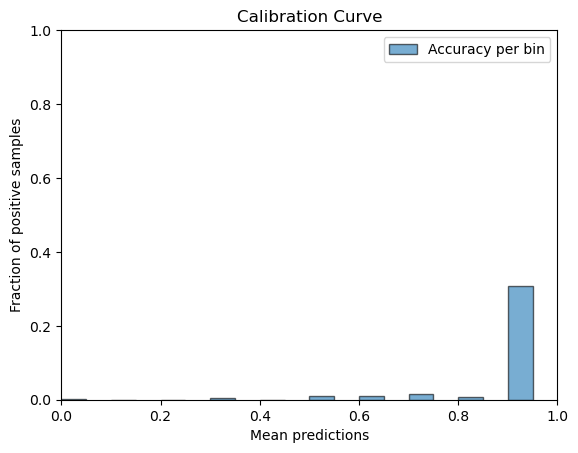

,title,auc,accuracy,precision,recall,f1_score,ece
0,df_test,0.971,0.6578,0.225521,0.995,0.367701,0.349276


In [ ]:
from sklearn.metrics import confusion_matrix
# Get the AUC
from sklearn.metrics import roc_auc_score
# display the confusion matrix
import seaborn as sns

from sklearn.metrics import roc_curve

def calculate_ece(labels, predictions, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bins[:-1]
    bin_uppers = bins[1:]

    ece = 0.0
    bin_proportion_of_class_1 = []
    bin_mean_confidences = []
    bin_counts = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find indices of predictions that fall into the current bin
        in_bin = np.where((predictions > bin_lower) & (predictions <= bin_upper))[0]
        if len(in_bin) > 0:
            # True labels and predicted probabilities in the bin
            bin_labels = labels[in_bin]
            bin_predictions = predictions[in_bin]
            
            # Accuracy and confidence in the bin
            proportion_of_class_1 = np.mean(bin_labels)
            mean_predictions = np.mean(bin_predictions)

            # debug
            # print(f'Bin: {bin_lower} - {bin_upper}')
            # print(f'Proportion of class 1: {proportion_of_class_1}')
            # print(f'Mean predictions: {mean_predictions}')
            # print(f'Number of samples in bin: {len(in_bin)}')
        

            
            # ECE contribution from this bin, weighted by the number of samples in the bin
            ece += np.abs(proportion_of_class_1 - mean_predictions) * len(in_bin) / len(predictions)

            # Save results for plotting
            bin_proportion_of_class_1.append(proportion_of_class_1)
            bin_mean_confidences.append(mean_predictions)
            bin_counts.append(len(in_bin))
        else:
            bin_proportion_of_class_1.append(0)
            bin_mean_confidences.append(0)
            bin_counts.append(0)

    # print("ECE:", ece)

    # Plotting
    plt.bar(bin_lowers, bin_proportion_of_class_1, width=1/20, align='edge', edgecolor='black', alpha=0.6, label='Accuracy per bin')
    # plt.plot(bin_lowers, bin_mean_confidences, marker='o', color='red', linestyle='--', label='Confidence per bin')
    plt.xlabel('Mean predictions')
    plt.ylabel('Fraction of positive samples')
    # x is between 0 and 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

    return ece


def evaluation_report(df, title='No Title passed in'):
    # print(f'\n\nEvaluation: {title}\n\n')
    if df.empty:
        # print("No data to evaluate")
        return
    
    tp_count = df['tp'].sum()
    tn_count = df['tn'].sum()
    fp_count = df['fp'].sum()
    fn_count = df['fn'].sum()


    accuracy = ( tp_count + tn_count ) / ( tp_count + tn_count + fp_count + fn_count )

    precision = tp_count / ( tp_count + fp_count )

    recall = tp_count / ( tp_count + fn_count )

    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )

    try:
        auc = roc_auc_score(df['label'], df['mean'])
    except Exception as e:  
        auc = 0

    ece = calculate_ece(df['label'], df['mean'])

    result_df = pd.DataFrame({
        'title': [title],
        'auc': [auc],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1_score': [f1_score],
        'ece': [ece]
    })

    return result_df



evaluation_report(df_test, 'df_test')
# evaluation_report(df_held_out, 'df_held_out')
# evaluation_report(df_corrupted, 'df_corrupted')

In [ ]:

if False:
    true_positive_indices = df_test[df_test['tp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
    false_positive_indices = df_test[df_test['fp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
    true_negative_indices = df_test[df_test['tn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
    false_negative_indices = df_test[df_test['fn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()

    most_confident_outputs = false_negative_indices[0:24]

    print(most_confident_outputs)

    import matplotlib.pyplot as plt

    if True:

        fig, axes = plt.subplots(4, 4, figsize=(20, 20))

        for i, ax in enumerate(axes.flat):
            # Get the index of the current image
            index = most_confident_outputs[i]

            # Display the image
            ax.imshow(test_images[index], cmap='gray')

            # Get the predictions of the individual models and the ensemble
            # 2 x 10000 x 1
            individual_pred = df_test['individual_predictions'].iloc[index]
            ensemble_pred = df_test['mean'].iloc[index]
            ensemble_var = df_test['variance'].iloc[index]

            # Display the predictions
            ax.set_title(f'Ensemble: {ensemble_pred}\nVariance: {ensemble_var}\nLabel: {test_labels[index]}')

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])

        # Display the figure
        plt.show()
        # 

In [ ]:
# print(df_test.head())

# TODO need to normalize the data

def create_x_y(df, feature='mean'):
    y = df['label'].to_numpy()
    


    if feature == 'mean':
        x = df['mean'].to_numpy().reshape(-1, 1)
    elif feature == 'variance':
        x = df['variance'].to_numpy().reshape(-1, 1)
    elif feature == 'mean_variance':
        x = np.vstack((df['mean'], df['variance'])).T
    elif feature == 'individual_predictions':
        x = np.stack(df['individual_predictions'].to_numpy())

    return x, y


# Create a meta model which uses the individual predictions as features to predict the label from the validation set and tested on the test set

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


### Evaluation

trained on val, tested on test


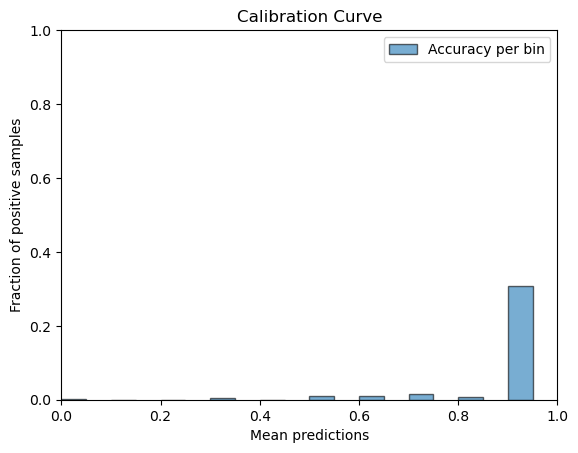

,title,auc,accuracy,precision,recall,f1_score,ece
0,Base Model,0.971,0.6578,0.225521,0.995,0.367701,0.349276


trained on val, tested on corrupted


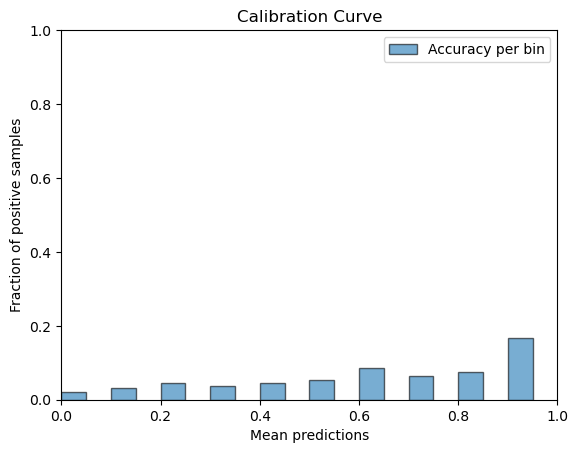

,title,auc,accuracy,precision,recall,f1_score,ece
0,Base Model,0.75453,0.454,0.143086,0.894,0.246689,0.520278


trained on val corrupted, tested on corrupted


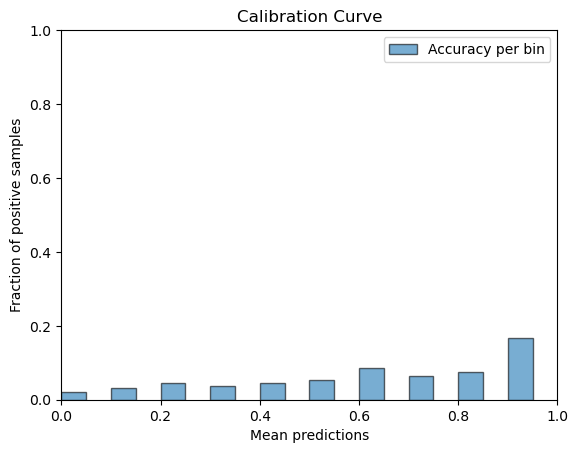

,title,auc,accuracy,precision,recall,f1_score,ece
0,Base Model,0.75453,0.454,0.143086,0.894,0.246689,0.520278


trained on val corrupted, tested on held out


In [ ]:
if True:
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    # logistic regression
    from sklearn.linear_model import LogisticRegression

    # sequential model
    from tensorflow.keras.models import Sequential

    def compare_meta_models(train_df, test_df, title=''):
        result_dataframes = []

        for feature in ['base_model']:
            if not feature == 'base_model':
                x_train, y_train = create_x_y(train_df, feature=feature)
                x_test, y_test = create_x_y(test_df, feature=feature)

                # Define the model
                model = Sequential()
                Input(shape=(x_train.shape[1],))
                model.add(Dense(32, activation='relu'))  # Input layer
                model.add(Dense(64, activation='relu'))  # Hidden layer
                model.add(Dense(128, activation='relu'))  # Hidden layer
                model.add(Dense(64, activation='relu'))  # Hidden layer
                model.add(Dense(32, activation='relu'))  # Hidden layer
                model.add(Dense(16, activation='relu'))  # Hidden layer
                model.add(Dense(1, activation='sigmoid'))  # Output layer

                # Compile the model
                model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

                # Fit the model
                early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
                model.fit(x_train, y_train, epochs=1000, batch_size=32, verbose=0)

                # Make predictions on the test set
                y_pred = model.predict(x_test, verbose=0)

                # make the size of points related to the normalized variance 
                normalized_variance = (test_df['variance'] - test_df['variance'].min()) / (test_df['variance'].max() - test_df['variance'].min())

                size_of_points = 30 * normalized_variance + 1

                # Make the colour of the points related to the label
                colour = np.where(test_df['label'] == 1, 'red', 'blue')


                # new figure
                plt.figure()
                plt.scatter(test_df['mean'], y_pred, s=size_of_points, c=colour, alpha=0.5)
                plt.xlabel('Ensemble Mean')
                plt.ylabel('Meta Model Prediction')
                plt.title(f'Meta Model: {feature}')
                plt.show()
                # Create a copy of df but replace the predictions with the meta model predictions
                df_test_meta = df_test.copy()
                df_test_meta['mean'] = y_pred
                # if mean is greater than 0.5 then the prediction is 1
                df_test_meta['prediction'] = np.where(df_test_meta['mean'] > 0.5, 1, 0)

                result_dataframes.append(evaluation_report(df_test_meta, f'{title} Meta Model: {feature}'));
            else:
                result_dataframes.append(evaluation_report(test_df, f'{title} Base Model'));

        return pd.concat(result_dataframes)


    # Display the results
    print('trained on val, tested on test')
    result_df = compare_meta_models(df_val, df_test)
    display(result_df)
    print('trained on val, tested on corrupted')
    result_df_corrupted = compare_meta_models(df_val, df_corrupted,)
    display(result_df_corrupted)
    print('trained on val corrupted, tested on corrupted')
    result_df_val_corrupted = compare_meta_models(df_val_corrupted, df_corrupted)
    display(result_df_val_corrupted)
    print('trained on val corrupted, tested on held out')
    if config['heldOutClasses']:
        result_df_held_out = compare_meta_models(df_val, df_held_out, 'Held Out')
        display(result_df_held_out)
        

